# Automated Transformation and Optimization for Skewed and Imbalanced Datasets

## 0. Introduction
This project focuses on improving machine learning model performance on **skewed and imbalanced datasets**. Data imbalance is a major challenge in data science, as standard models tend to favor the majority class, often leading to poor performance when predicting minority class instances.

The goal of this work is to develop a **flexible pipeline** that integrates **data preprocessing, model optimization, and performance evaluation**. The approach includes various techniques to address data imbalance, such as **SMOTE, ADASYN, and under-sampling** methods, along with **data transformation techniques like Quantile Transformation and Power Transformation** to adjust feature distributions.

Additionally, advanced models such as **LightGBM** are utilized, and model performance is thoroughly assessed using evaluation metrics like **Precision, Recall, Confusion Matrix, and Precision-Recall Curves**. These techniques enhance the model's ability to detect rare cases, which is especially crucial for applications such as **fraud detection, medical diagnosis, and text analysis**.


## 1. Imports

In [126]:
from IPython.display import display
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
import pandas as pd
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

## 2. Integrating the Previous Project into the Current Research
The previous project successfully demonstrated how class balancing and feature transformations impact model performance. These same principles are applied in the current research, but with a broader focus on automating preprocessing techniques for diverse datasets.

- **Class Balancing** (SMOTE & Undersampling): In the wine quality dataset, balancing improved model accuracy by ensuring all classes were well represented. Similarly, in the current research, we apply controlled oversampling and undersampling to create a more robust classification pipeline.

- **Skewness Correction**: The previous project applied log transformations to normalize distributions, preventing biases. Here, we expand this with Box-Cox and Yeo-Johnson transformations, adapting preprocessing to different data types.

- **Model Optimization**: In the last project, hyperparameter tuning boosted performance dramatically. We extend this by optimizing classification thresholds and cost-sensitive learning to handle imbalanced datasets more effectively.

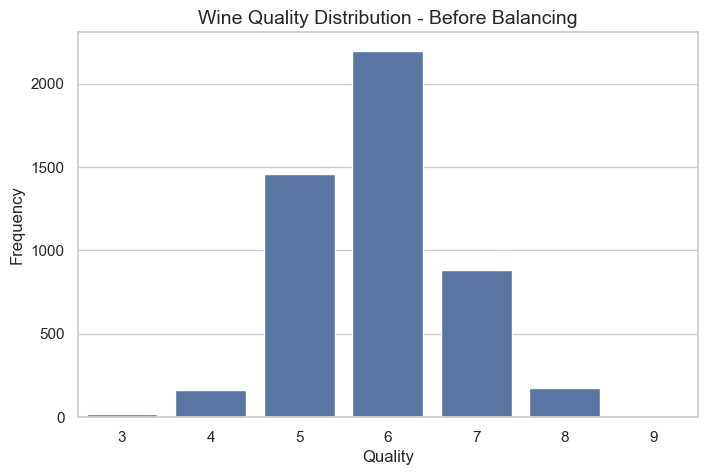

Class Distribution Before Balancing: Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Class Distribution After SMOTE: Counter({6: 2198, 5: 1457, 7: 1318, 8: 1318, 4: 1318, 3: 1318, 9: 1318})


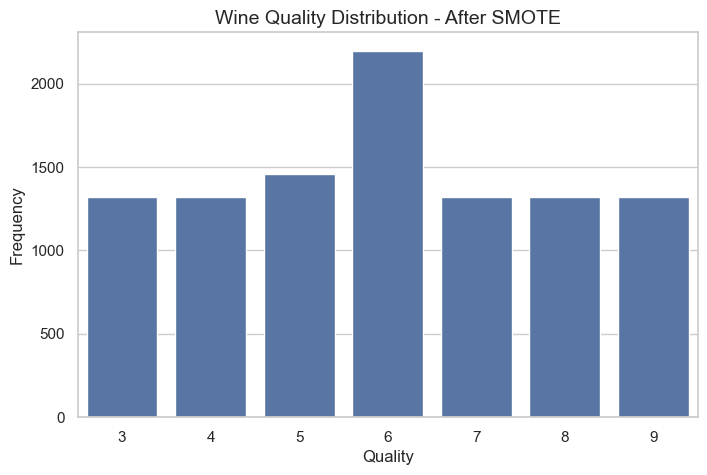

Final Class Distribution After SMOTE & Corrected Undersampling: Counter({6: 1977, 5: 1457, 3: 1318, 4: 1318, 7: 1318, 8: 1318, 9: 1318})


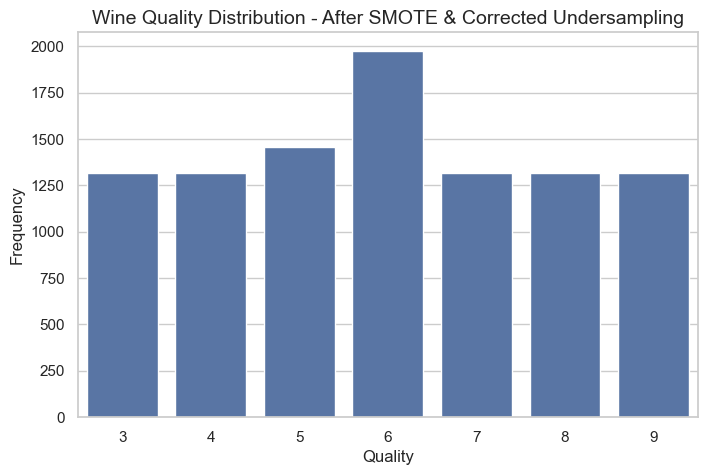

In [127]:
# Load dataset
data = pd.read_csv("winequality-white.csv", sep=';')

# Visualize initial class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=data)
plt.title('Wine Quality Distribution - Before Balancing', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Split features and target
X = data.drop(columns=['quality'])
y = data['quality']

# Display initial class distribution
print("Class Distribution Before Balancing:", Counter(y))

# Step 1: Handle Extremely Rare Classes (Manual Duplication)
min_samples = 30  # Minimum samples required for SMOTE to work

for cls, count in Counter(y).items():
    if count < min_samples:
        extra_samples = data[data['quality'] == cls].sample(min_samples - count, replace=True)
        data = pd.concat([data, extra_samples])

# Update X and y after rare class handling
X = data.drop(columns=['quality'])
y = data['quality']

# Step 2: Apply SMOTE to Underrepresented Classes
max_class_count = max(Counter(y).values())
smote_strategy = {cls: max(count, int(0.6 * max_class_count)) for cls, count in Counter(y).items() if count < 0.6 * max_class_count}

smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Display new class distribution after SMOTE
print("Class Distribution After SMOTE:", Counter(y_smote))

# Visualize class distribution after SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_smote)
plt.title('Wine Quality Distribution - After SMOTE', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Step 3: Apply Proper Undersampling for Overrepresented Classes
min_class_count = min(Counter(y_smote).values())  # Smallest class after SMOTE
undersample_strategy = {}

for cls, count in Counter(y_smote).items():
    if count > min_class_count * 1.5:  # Reduce dominant classes but keep them slightly higher than others
        undersample_strategy[cls] = int(min_class_count * 1.5)  # Keep majority at 1.5x the smallest class

# Apply undersampling
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_final, y_final = undersample.fit_resample(X_smote, y_smote)

# Display final class distribution after proper balancing
print("Final Class Distribution After SMOTE & Corrected Undersampling:", Counter(y_final))

# Visualizing target distribution after full balancing
plt.figure(figsize=(8, 5))
sns.countplot(x=y_final)
plt.title('Wine Quality Distribution - After SMOTE & Corrected Undersampling', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


### 2.1 How This Improves Prediction?

Baseline Model Performance:
R^2 Score: 0.7637
MSE: 0.8736
RMSE: 0.9347
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Improved Model Performance:
RMSE: 0.5062, R^2: 0.9307

Comparison of Baseline and Improved Models:
  Metric  Baseline Model  Improved Model
0    R^2        0.763739        0.930699
1    MSE        0.873623        0.256255
2   RMSE        0.934678        0.506217


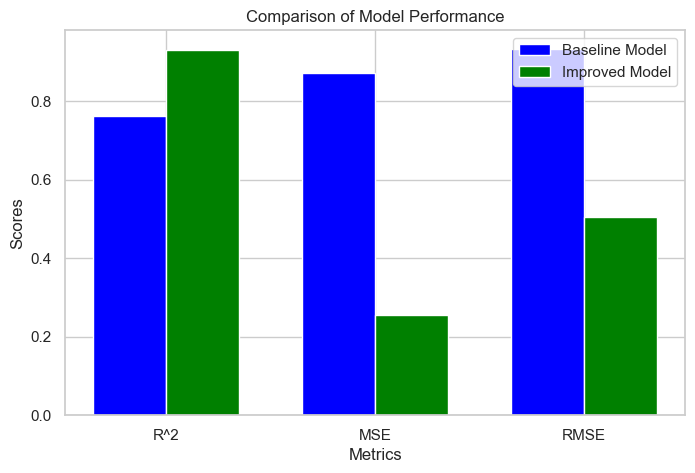

In [128]:
# Load the baseline model
baseline_model = joblib.load('baseline_model.pkl')

# Use the final balanced dataset
X = X_final
y = y_final

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict on the test set using the baseline model
y_pred_baseline = baseline_model.predict(X_test)

# Calculate baseline performance metrics
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print(f"Baseline Model Performance:\nR^2 Score: {r2_baseline:.4f}\nMSE: {mse_baseline:.4f}\nRMSE: {rmse_baseline:.4f}")

# Hyperparameter tuning with GridSearchCV for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

# Fit GridSearch on the balanced dataset
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

# Evaluate the improved model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Improved Model Performance:\nRMSE: {rmse:.4f}, R^2: {r2:.4f}')

# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MSE', 'RMSE'],
    'Baseline Model': [r2_baseline, mse_baseline, rmse_baseline],
    'Improved Model': [r2, mse, rmse]
})

print("\nComparison of Baseline and Improved Models:")
print(comparison_df)

# Plot comparison of R^2
plt.figure(figsize=(8, 5))
bar_width = 0.35
indices = np.arange(len(comparison_df))

plt.bar(indices, comparison_df['Baseline Model'], bar_width, label='Baseline Model', color='blue')
plt.bar(indices + bar_width, comparison_df['Improved Model'], bar_width, label='Improved Model', color='green')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(indices + bar_width / 2, comparison_df['Metric'])
plt.legend()
plt.show()


The improved model shows a significant enhancement in predictive performance compared to the baseline model. The R² score increased from 0.76 to 0.93, indicating that the new model explains much more variance in the data. The MSE dropped from 0.87 to 0.25, demonstrating a major reduction in prediction errors. Additionally, the RMSE decreased from 0.93 to 0.50, confirming that the model's predictions are more precise and stable.

##### **These improvements highlight the impact of data balancing and hyperparameter tuning on predictive accuracy. By applying SMOTE & undersampling, the model now performs better across all quality levels, rather than favoring the dominant ones.**

## 3. Broader Impact: Scalable Preprocessing for Various Datasets
While the previous project focused on a specific dataset (wine quality), the current research aims to generalize preprocessing techniques to work across multiple data types and domains. By automating class balancing and skew correction, we develop a versatile, adaptable pipeline that enhances machine learning models regardless of dataset characteristics. 

In [129]:
!pip install lightgbm

### 3.1. Preprocessing the Dataset
**Loads the dataset from the specified file path**

    - Displays dataset structure and basic statistics.

In [130]:
def load_data(filepath,target_column):
    """
    Loads the credit card fraud dataset, extracts numerical features, and returns
    the DataFrame along with a list of numerical columns (excluding the target column).

    Parameters:
        filepath (str): Path to the CSV file.

    Returns:
        df (pd.DataFrame): Loaded dataset.
        numerical_features (list): List of numerical feature column names (excluding the target).
    """
    # Load dataset
    df = pd.read_csv(filepath)

    # Extract numerical features excluding the target column
    numerical_features = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_features:
        numerical_features.remove(target_column)

    # Display dataset shape and first few rows
    print(f"Dataset Shape: {df.shape}")
    print("\nSample Rows:")
    display(df.head())

    return df, numerical_features  # Return DataFrame and numerical feature names

target_column = 'Class'
df, numerical_features = load_data("creditcard.csv",target_column)


Dataset Shape: (284807, 31)

Sample Rows:


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [131]:
df_dtypes = pd.DataFrame(df.dtypes).reset_index()
df_dtypes.columns = ['Column', 'Data Type']
print(df_dtypes)

    Column Data Type
0     Time   float64
1       V1   float64
2       V2   float64
3       V3   float64
4       V4   float64
5       V5   float64
6       V6   float64
7       V7   float64
8       V8   float64
9       V9   float64
10     V10   float64
11     V11   float64
12     V12   float64
13     V13   float64
14     V14   float64
15     V15   float64
16     V16   float64
17     V17   float64
18     V18   float64
19     V19   float64
20     V20   float64
21     V21   float64
22     V22   float64
23     V23   float64
24     V24   float64
25     V25   float64
26     V26   float64
27     V27   float64
28     V28   float64
29  Amount   float64
30   Class     int64


### 3.2. Detecting and Correcting Skewed Features

In [132]:
def detect_skewed_features(df, numerical_features, skew_threshold=0.5):
    """
    Detects numerical features with skewness above a given threshold.

    Parameters:
        df (pd.DataFrame): The input dataset.
        numerical_features (list): List of numerical feature column names.
        skew_threshold (float): The threshold above which features are considered skewed.

    Returns:
        skewed_features (list): List of skewed numerical feature names.
        skewness_table (pd.DataFrame): DataFrame with skewness values for all numerical features.
    """
    print("Detecting skewed features...")

    # Compute skewness for numerical features
    skewness_values = df[numerical_features].skew()

    # Select features where absolute skewness is greater than the threshold
    skewed_features = skewness_values[abs(skewness_values) > skew_threshold].index.tolist()

    # Store skewness values in a DataFrame for reference
    skewness_table = pd.DataFrame({
        "Feature": numerical_features,
        "Skewness": skewness_values
    }).sort_values(by="Skewness", ascending=False)

    print(f"Skewed Features (>|{skew_threshold}|): {skewed_features}")

    return skewed_features, skewness_table  # Return both the feature names and skewness values

# Example usage:
skewed_features, skewness_table = detect_skewed_features(df, numerical_features)


Detecting skewed features...
Skewed Features (>|0.5|): ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']


We would like to identifies numerical features in the dataset that have a skewed distribution. Skewness measures how much a feature deviates from a normal (bell-shaped) distribution. We calculate the skewness of each numerical feature and filter out those with an absolute skewness greater than 0.5, which indicates moderate to high skewness. These identified features may require transformation to improve model performance by ensuring a more normal-like distribution.

#### 3.2.1. Addressing the Issue of Worsened Skewness After Transformation

In some cases, applying transformations actually increased the skewness rather than reducing it.
To fix this, we will implement a smarter transformation selection approach that avoids making skewness worse.

Three Improvements to Prevent Skewness Worsening:
1. Add a Post-Transformation Check:
If the skewness increases instead of decreasing, we will revert to the original data.
2. Choose a More Intelligent Transformation:
If all values are strictly positive, we apply Box-Cox.
If the feature contains negative values, we use Yeo-Johnson instead.
We avoid log transformations automatically, as they may worsen skewness in extreme cases.
3. Store the Original Skewness and Compare:
After applying a transformation, we check if skewness improved.
If the transformation made it worse, we undo the change and restore the original values.


In [133]:
def best_transform(feature_series):
    """
    Try several transformations and select the one that yields the lowest absolute skewness.
    Returns the transformed series, the name of the chosen method, the original skew, and the new skew.
    """
    original_skew = feature_series.skew()
    best_method = 'none'
    best_skew = abs(original_skew)
    best_transformed = feature_series.copy()

    # Dictionary to store transformation results
    transforms = {}

    # Try Box-Cox (only if all values are positive)
    if (feature_series > 0).all():
        try:
            transformed, _ = boxcox(feature_series + 1)
            skew_val = pd.Series(transformed).skew()
            transforms['boxcox'] = (transformed, abs(skew_val))
        except Exception as e:
            pass

    # Try Log1p transform (with shift)
    try:
        transformed = np.log1p(feature_series - feature_series.min() + 1)
        skew_val = pd.Series(transformed).skew()
        transforms['log1p'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Try Yeo-Johnson
    try:
        pt = PowerTransformer(method='yeo-johnson')
        transformed = pt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
        skew_val = pd.Series(transformed).skew()
        transforms['yeo-johnson'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Try QuantileTransformer (maps data to a normal distribution)
    try:
        qt = QuantileTransformer(output_distribution='normal', random_state=0)
        transformed = qt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
        skew_val = pd.Series(transformed).skew()
        transforms['quantile'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Compare all transformations and select the best one if it improves skewness
    for method, (trans, skew_val) in transforms.items():
        if skew_val < best_skew:
            best_skew = skew_val
            best_method = method
            best_transformed = trans

    return best_transformed, best_method, original_skew, pd.Series(best_transformed).skew()

**The following transformations are applied based on methodologies discussed in the article "Skewness Be Gone: Transformative Tricks for Data Scientists" by Vinod Chugani.**

   ##### **Quantile Transformation**
   - **How it works:**
     - Maps the feature values to a specified distribution, such as normal, based on their quantiles.
     - Effectively addresses skewness by distributing data points evenly across the chosen distribution.
   - **Best for:** Severe skewness, non-Gaussian distributions, and handling outliers.

   ##### **Yeo-Johnson Transformation**
   - **How it works:**
     - A power transformation adaptable to both positive and non-positive data.
     - Applies an optimal transformation parameter to stabilize variance and reduce skewness.
   - **Best for:** Moderate skewness, features with zero or negative values, and when data includes negative or zero values.

   ##### **Log1p (Natural Log + 1) Transformation**
   - **How it works:**
     - Uses a logarithmic transformation to compress large values and reduce right-skewness.
     - Applies the natural logarithm to each data point after adding one, effectively handling zero and positive values.
   - **Best for:** Mild skewness, right-skewed data, and features where small values dominate.

#### 3.2.2. Applying Data Transformations
To address skewness in our data, we applied several transformations as recommended in the article ["Skewness Be Gone: Transformative Tricks for Data Scientists" by Vinod Chugani](https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists/):

   - **Log1p Transformation:** Suitable for mildly skewed, right-skewed data, especially when small values dominate.
   - **Yeo-Johnson Transformation:** Ideal for moderate skewness and data that includes zero or negative values.
   - **Quantile Transformation:** Effective for severe skewness and non-Gaussian distributions, as it maps data to a normal distribution.

Skewed Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']


Feature  Skewness Before  Skewness After       Method
0       V1        -3.280667        0.014658     quantile
1       V2        -4.624866        0.062620     quantile
2       V3        -2.240155        0.057024     quantile
3       V4         0.676292        0.018930  yeo-johnson
4       V5        -2.425901        0.016408     quantile
5       V6         1.826581       -0.014489     quantile
6       V7         2.553907        0.017067     quantile
7       V8        -8.521944       -0.016248     quantile
8       V9         0.554680        0.002901     quantile
9      V10         1.187141        0.000948     quantile
10     V12        -2.278401        0.006644     quantile
11     V14        -1.995176        0.010733     quantile
12     V16        -1.100966        0.003737     quantile
13     V17        -3.844914        0.012722     quantile
14     V20        -2.037155        0.037233     quantile
15     V21         3.592991       -0.003685     quantile
16     V23        -5.875140        0.014924     quantile
17     V24        -0.552499       -0.011967     quantile
18     V26         0.576693       -0.013798     quantile
19     V27        -1.170209       -0.070072     quantile
20     V28        11.192091       -0.002629     quantile
21  Amount        16.977724        0.018354  yeo-johnson

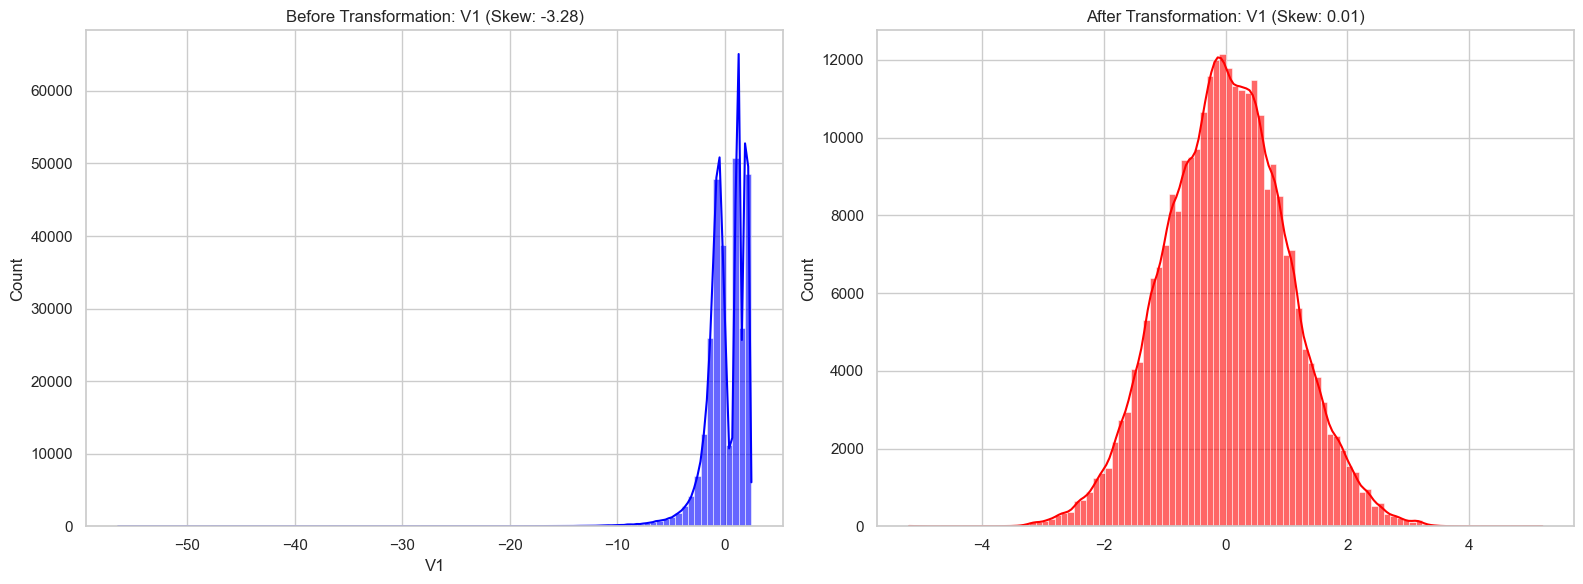

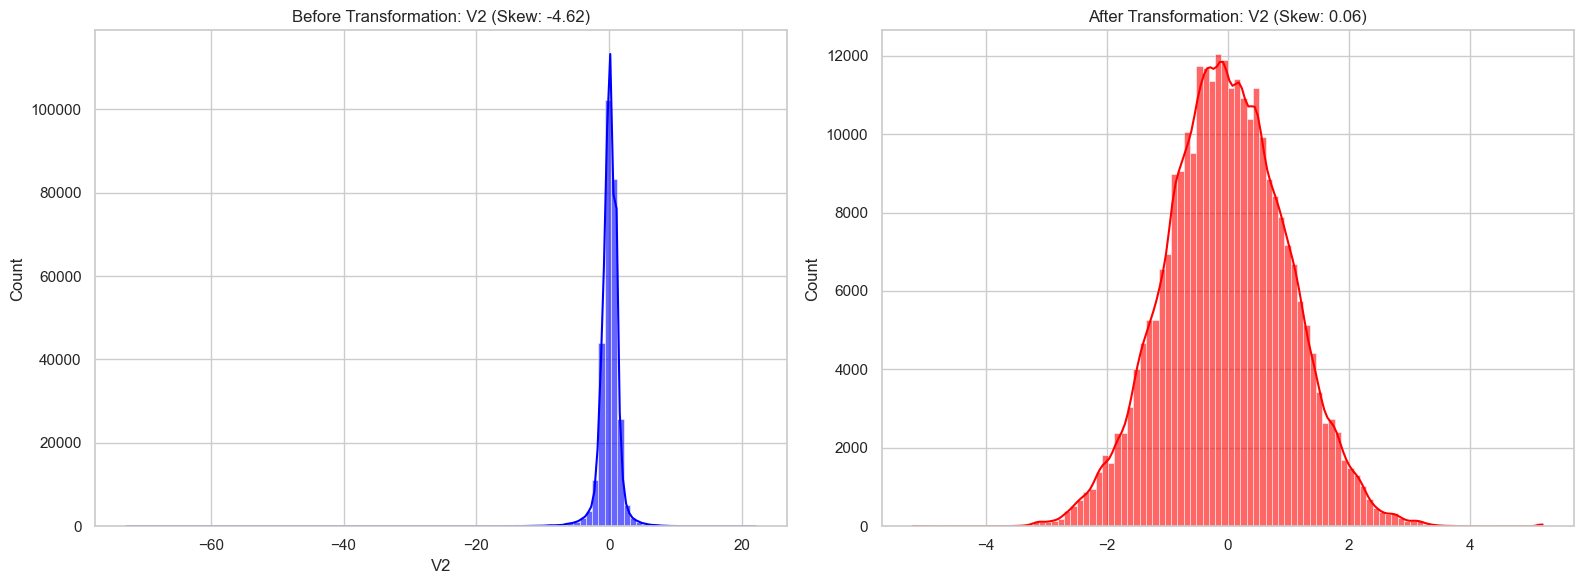

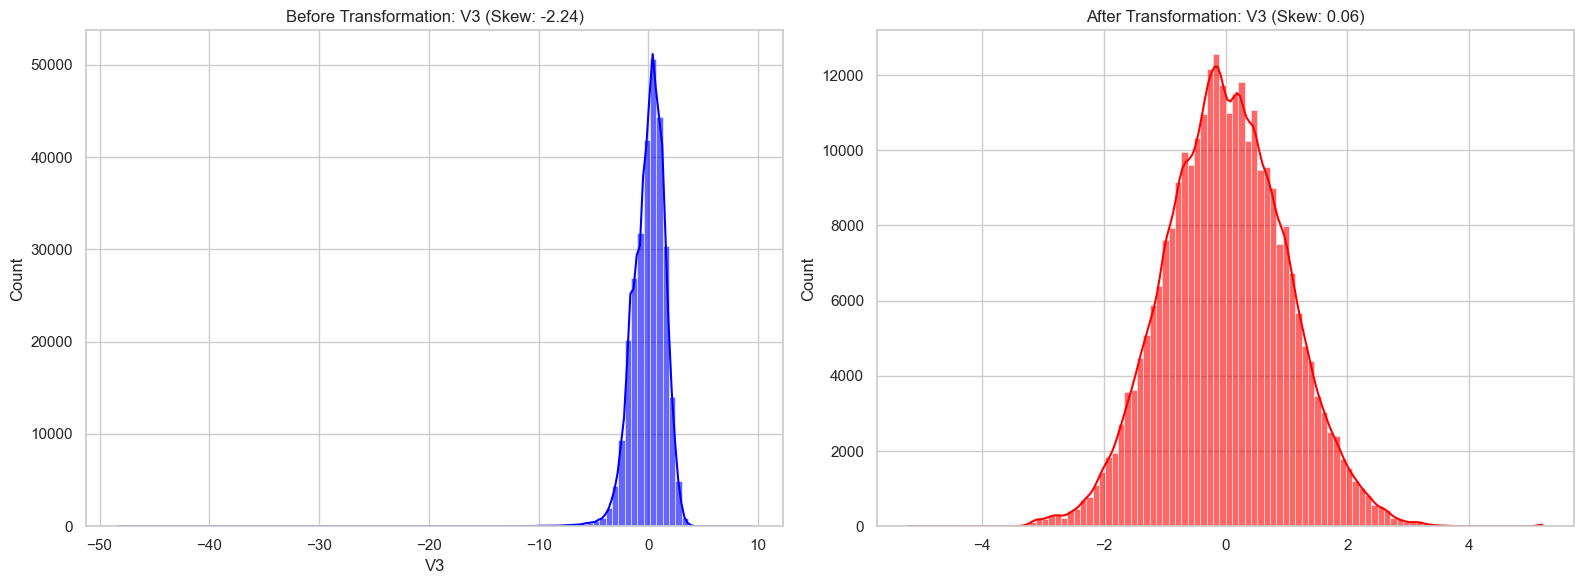

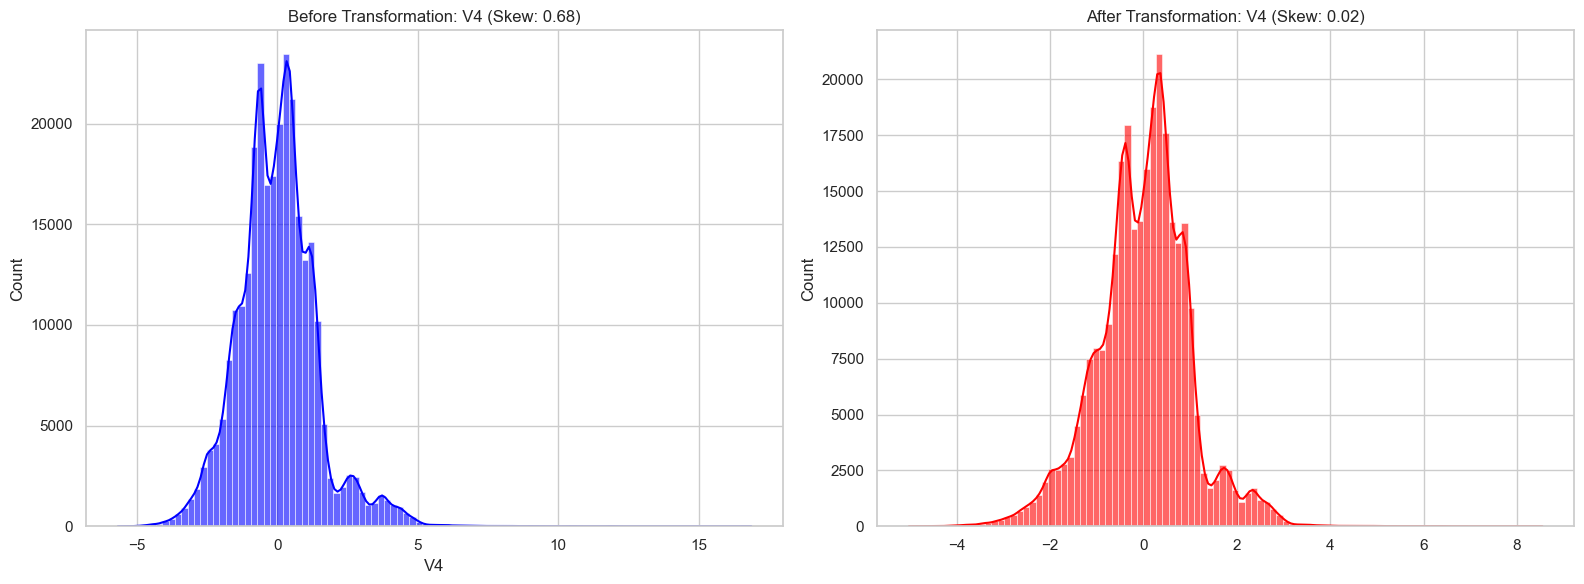

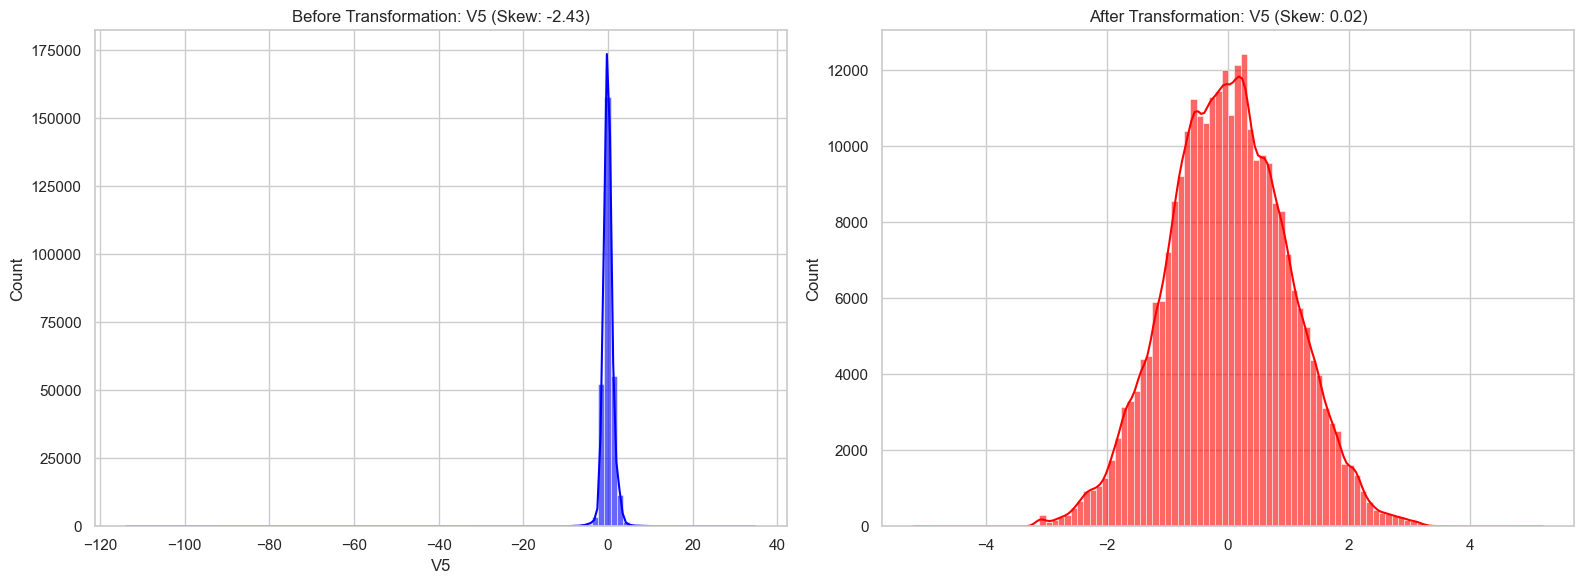

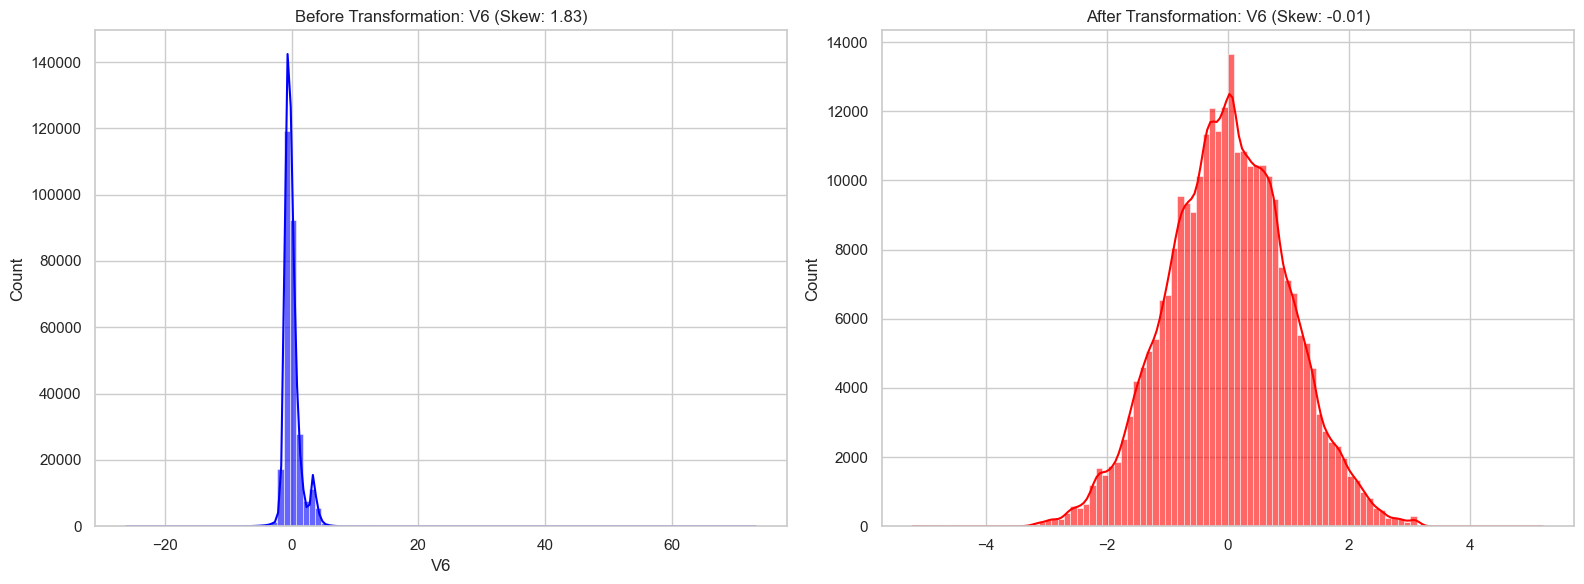

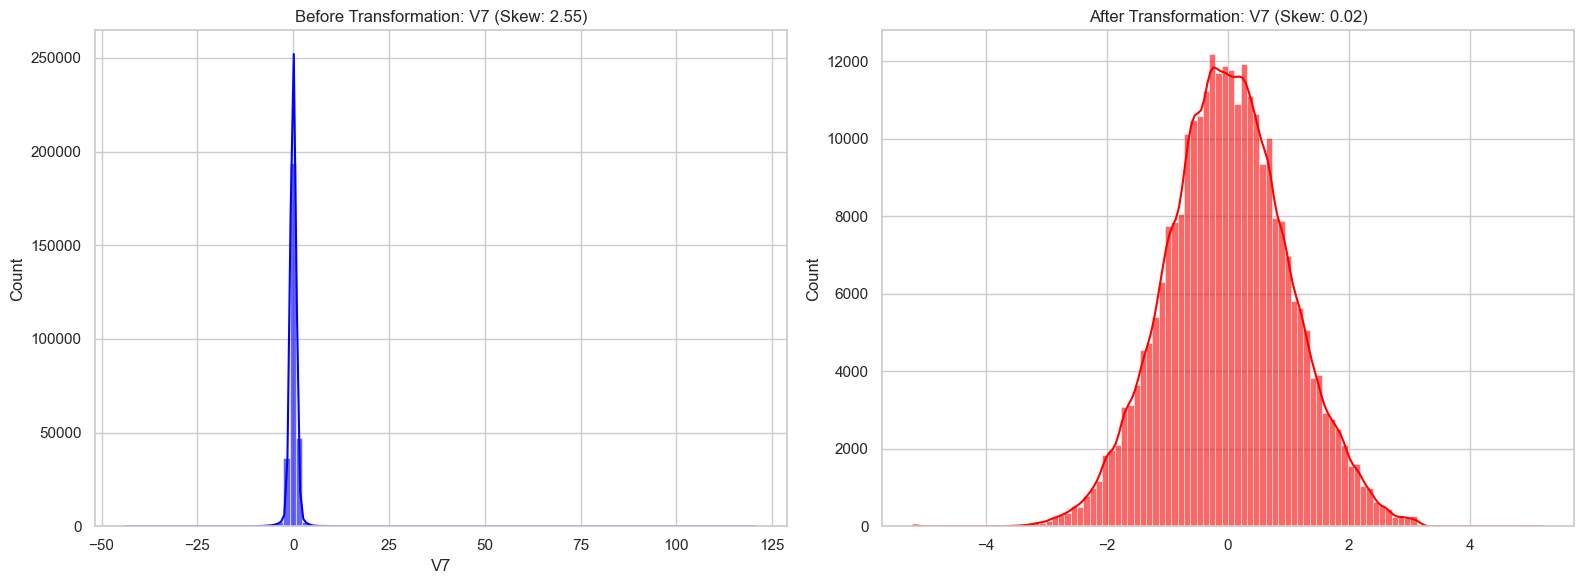

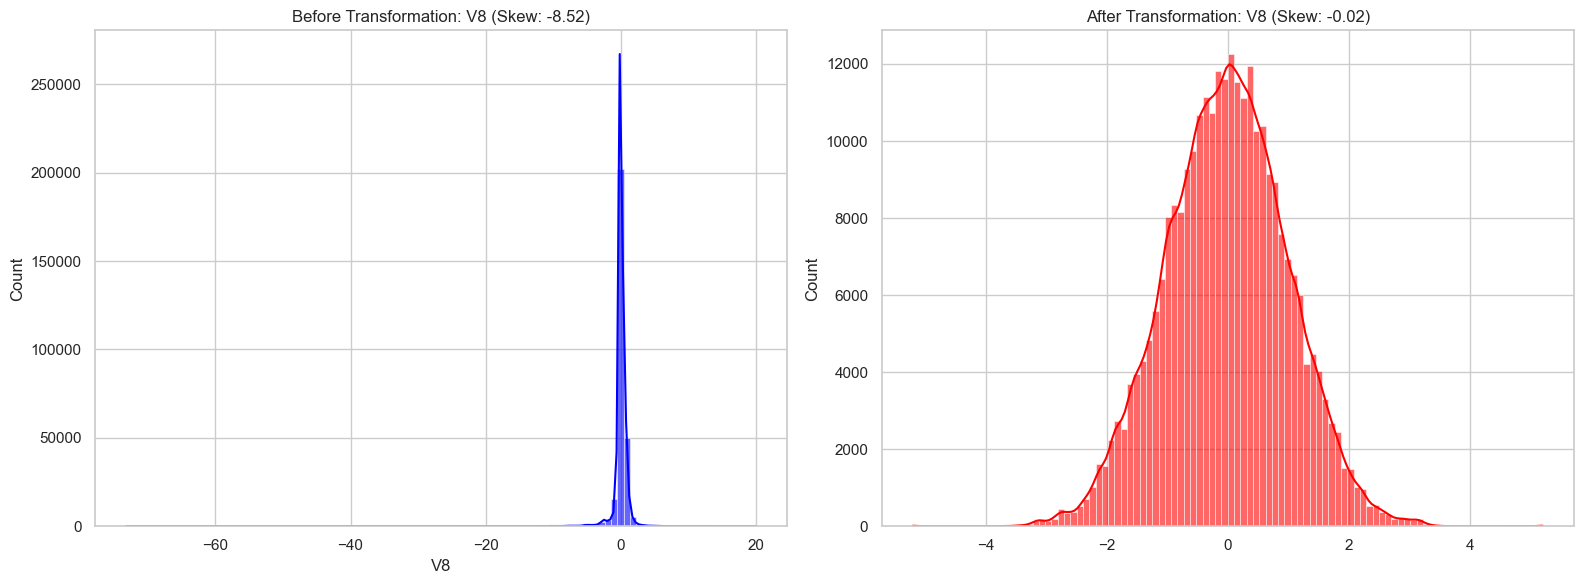

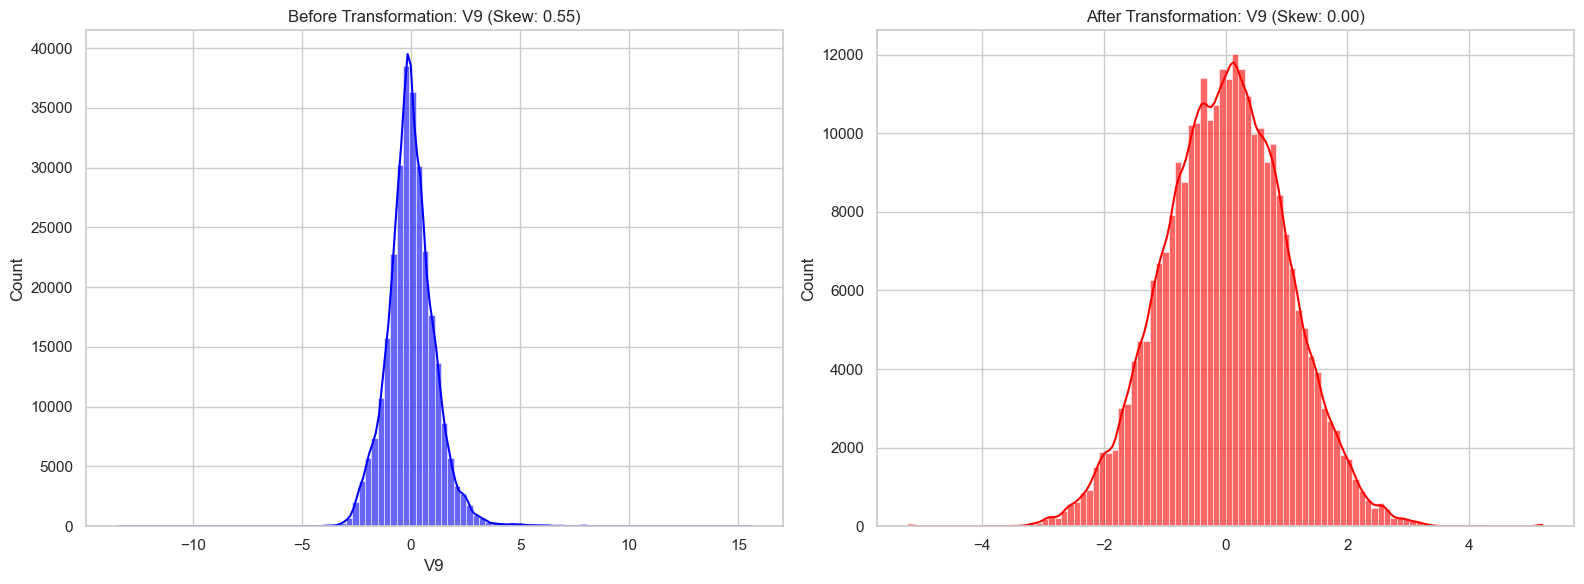

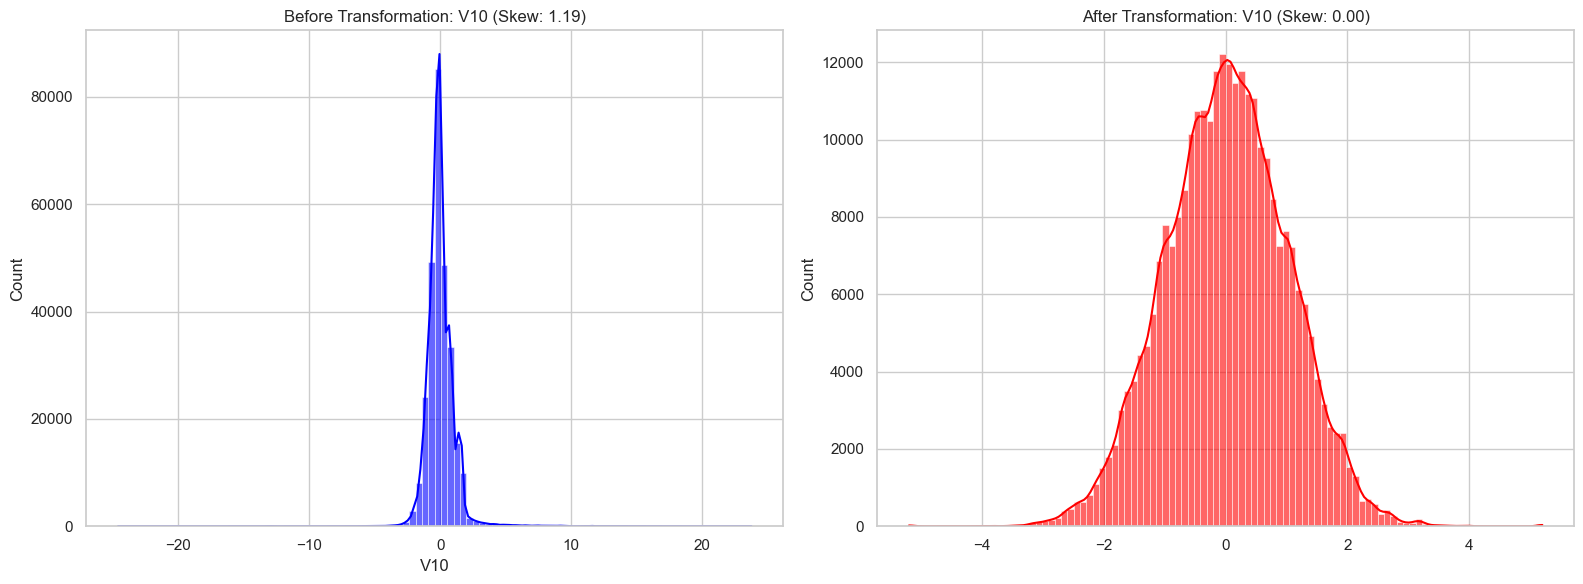

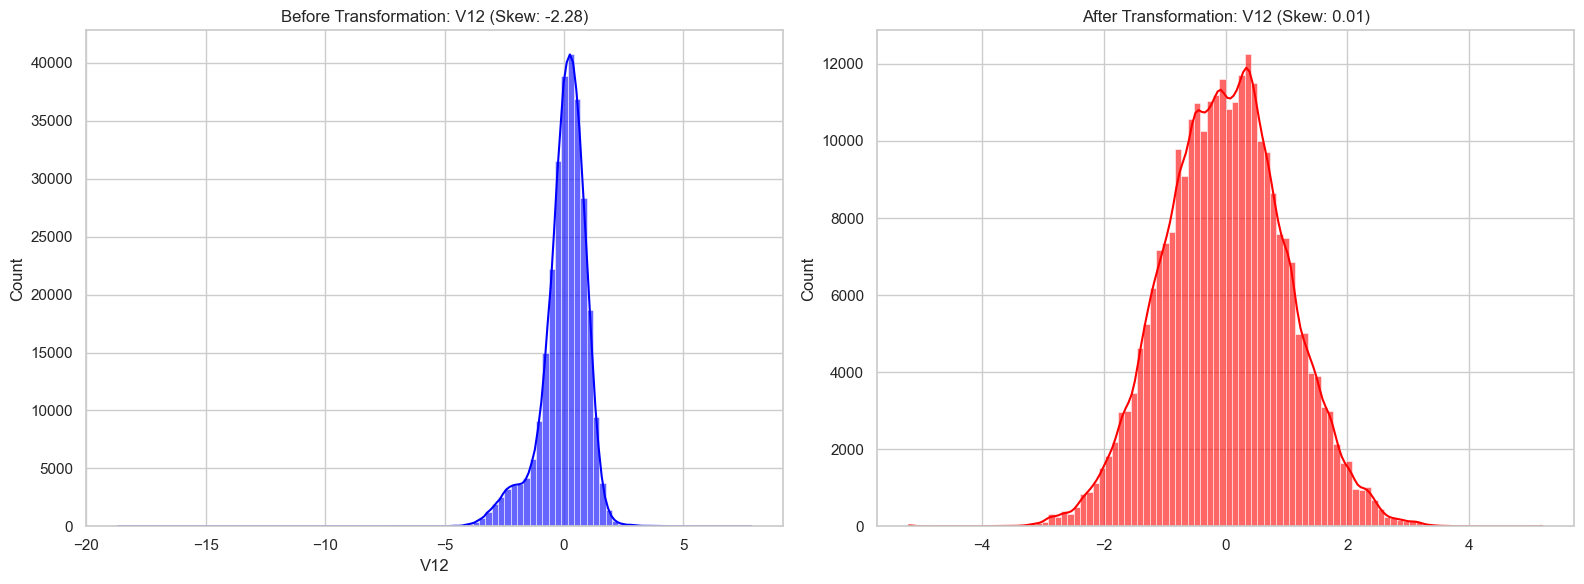

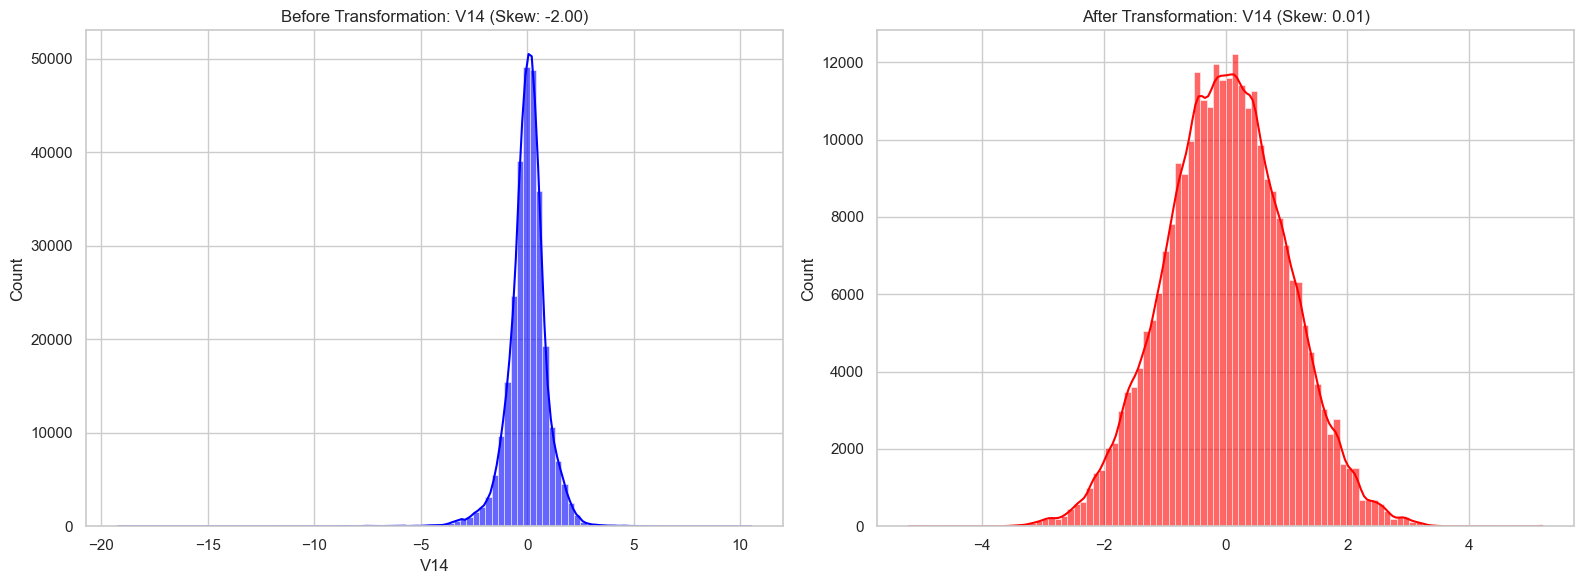

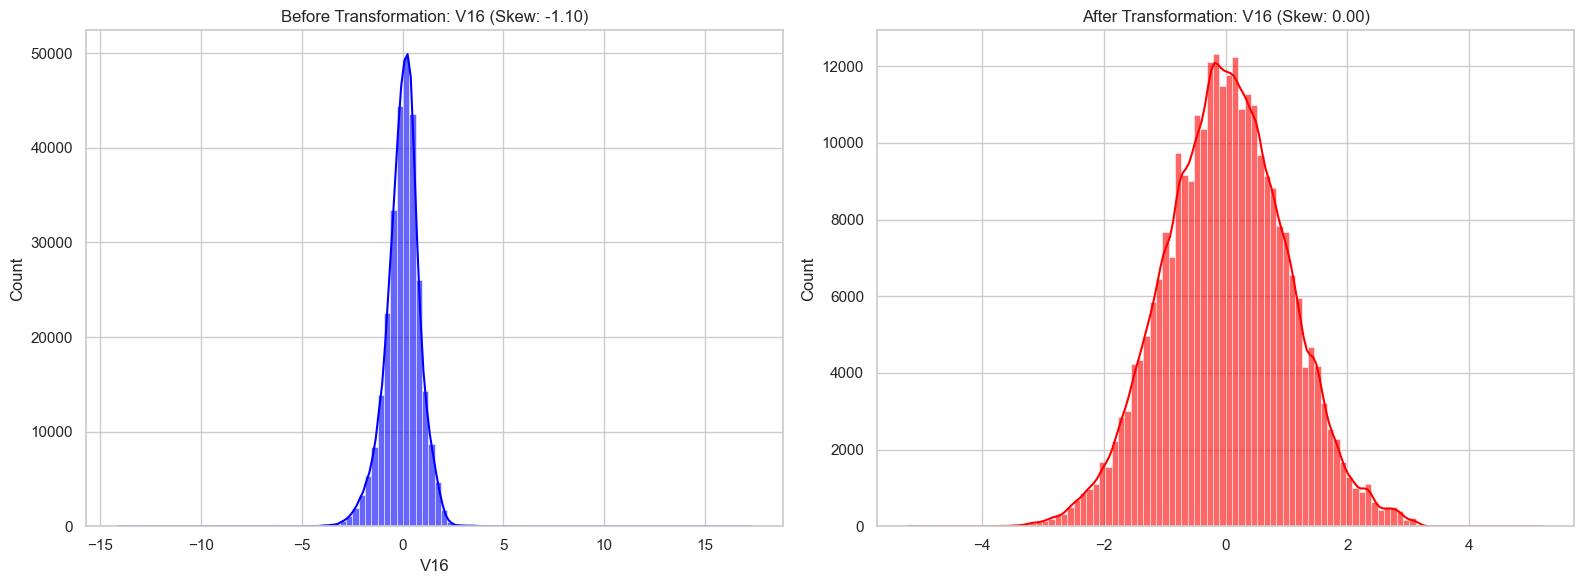

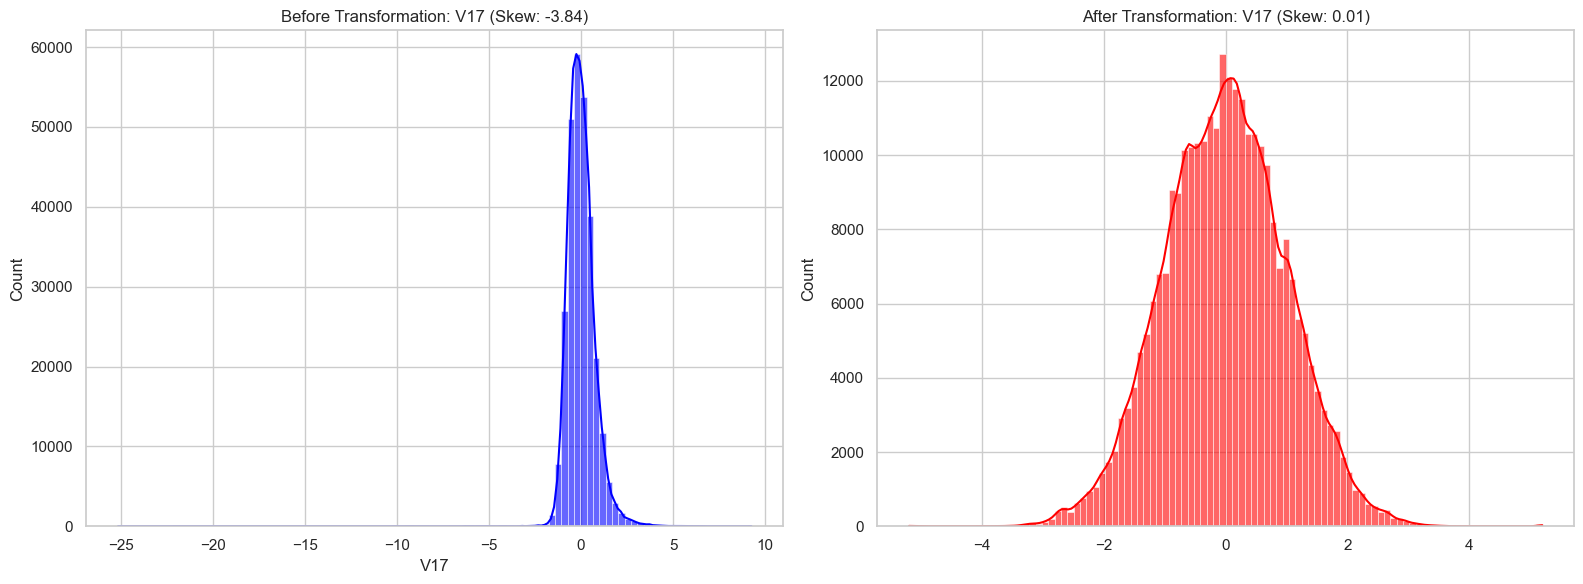

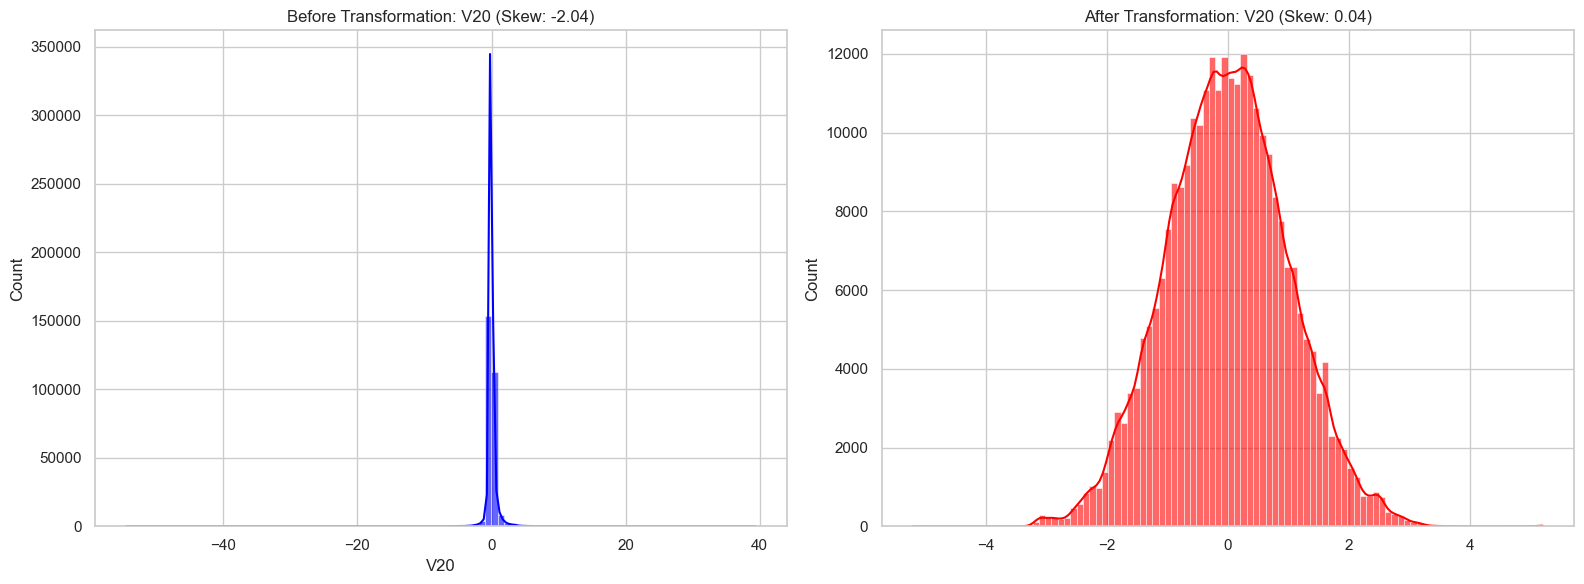

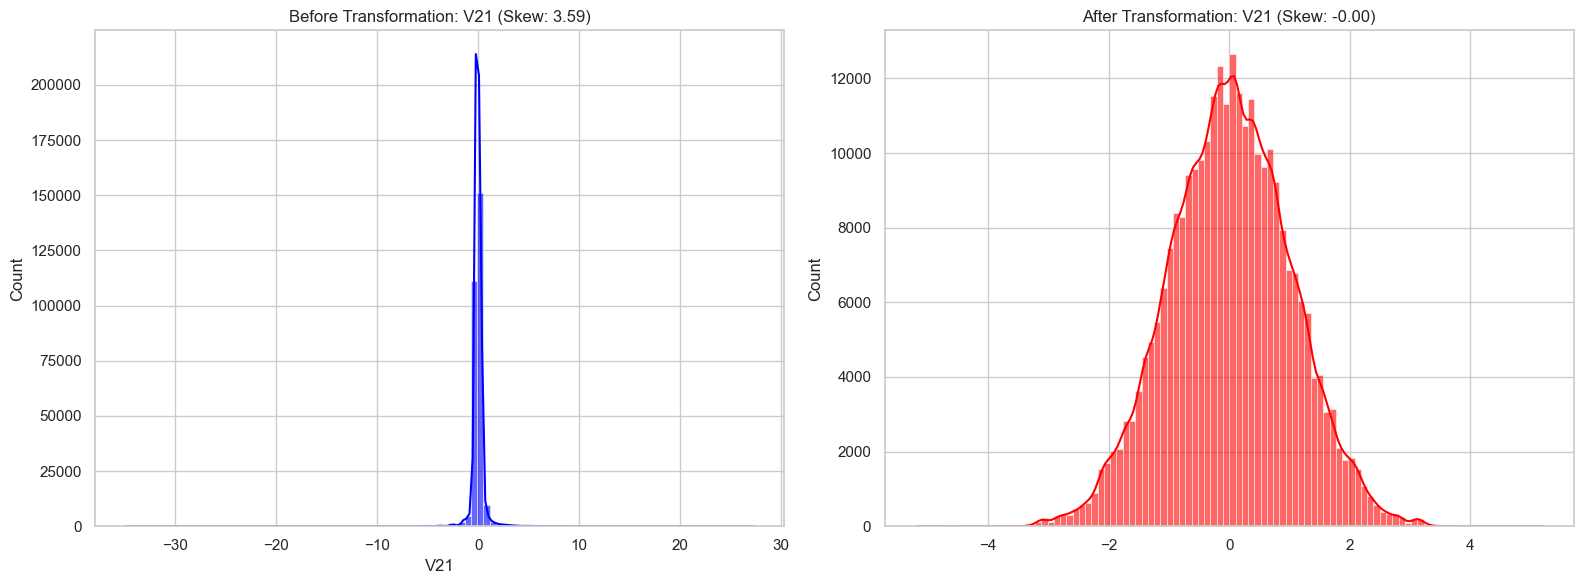

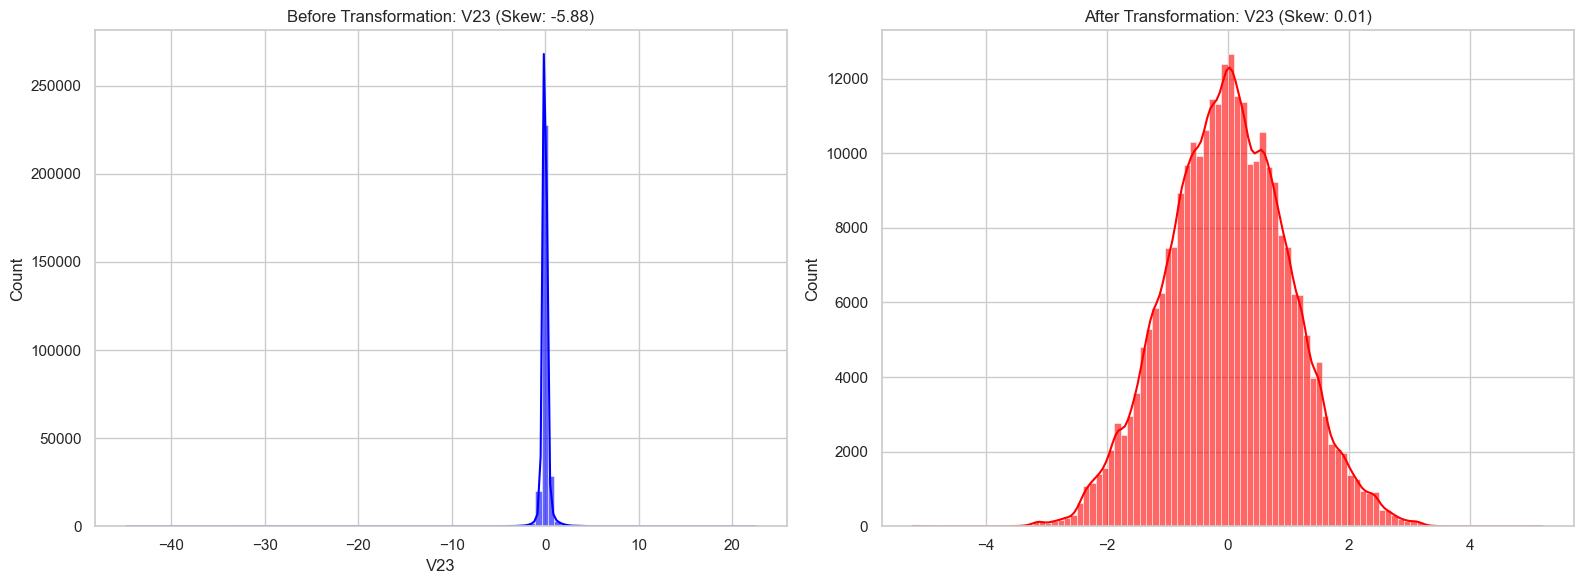

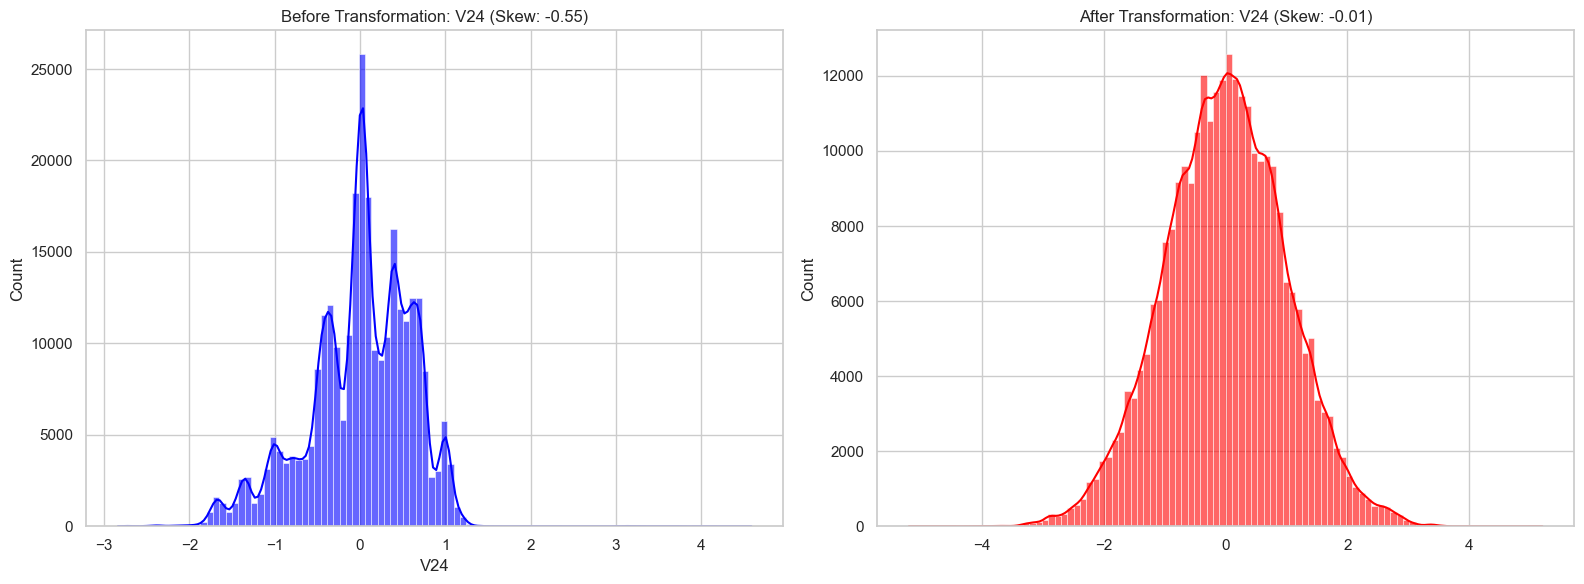

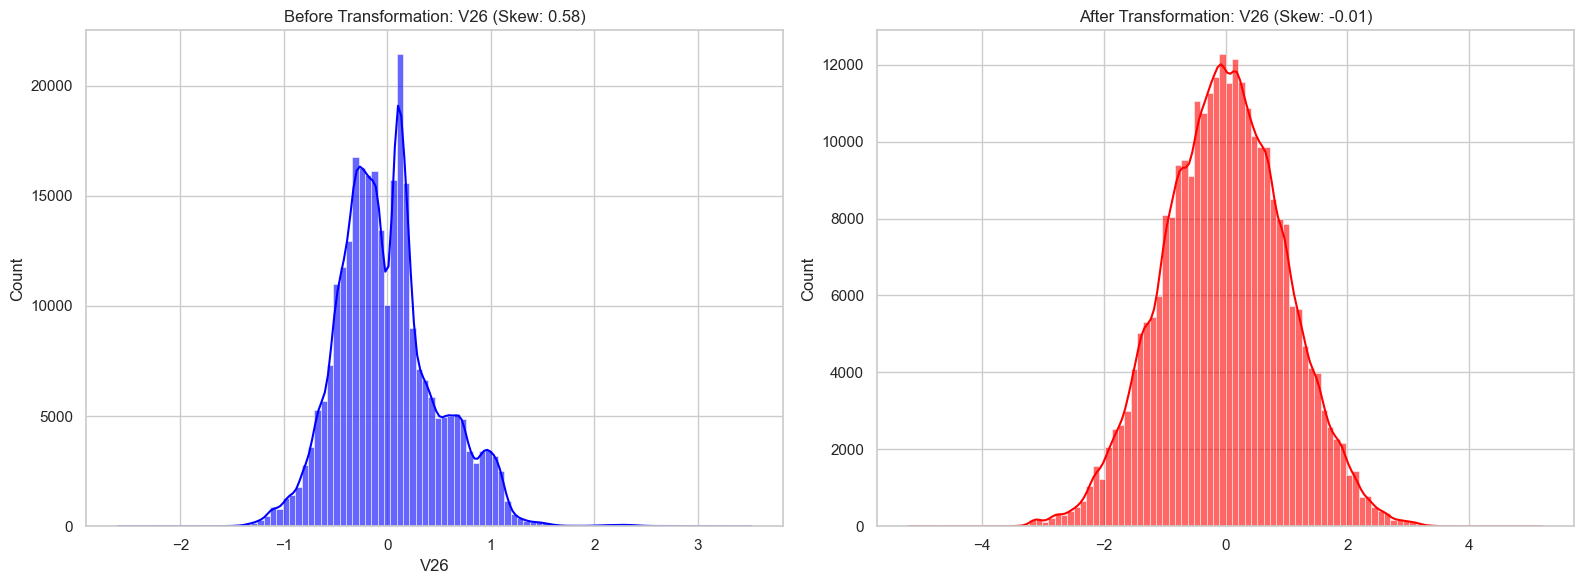

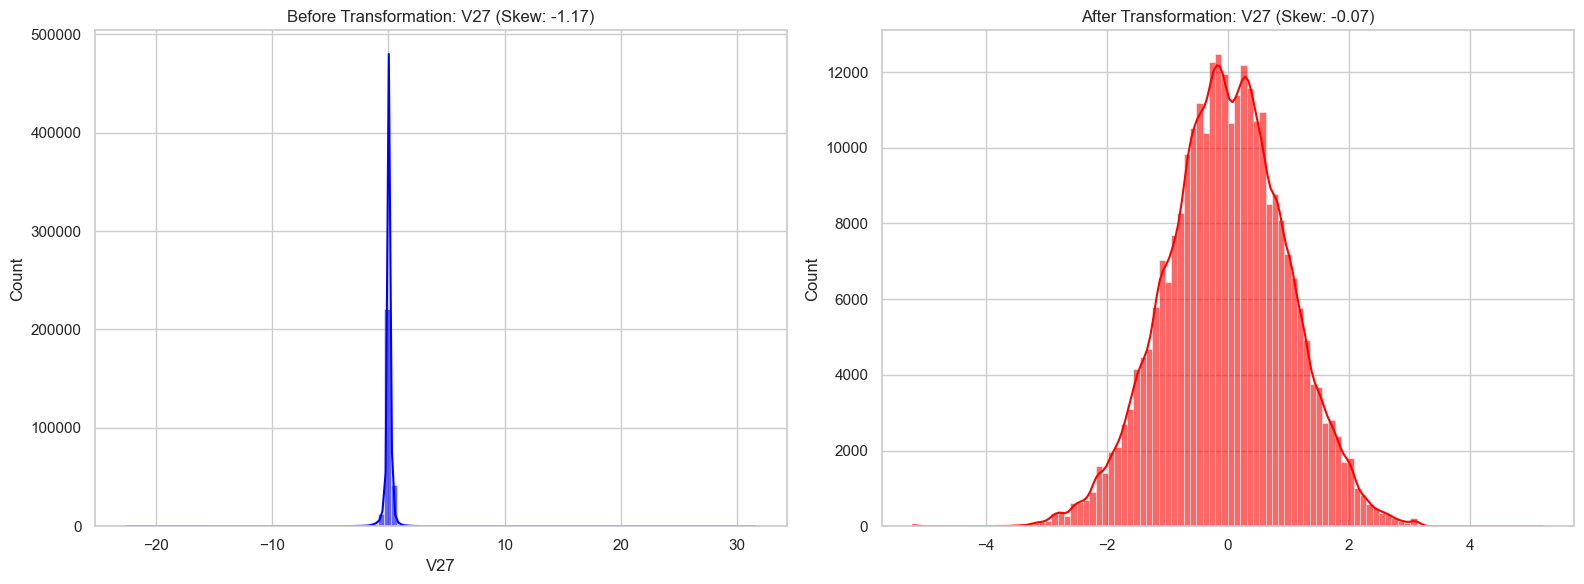

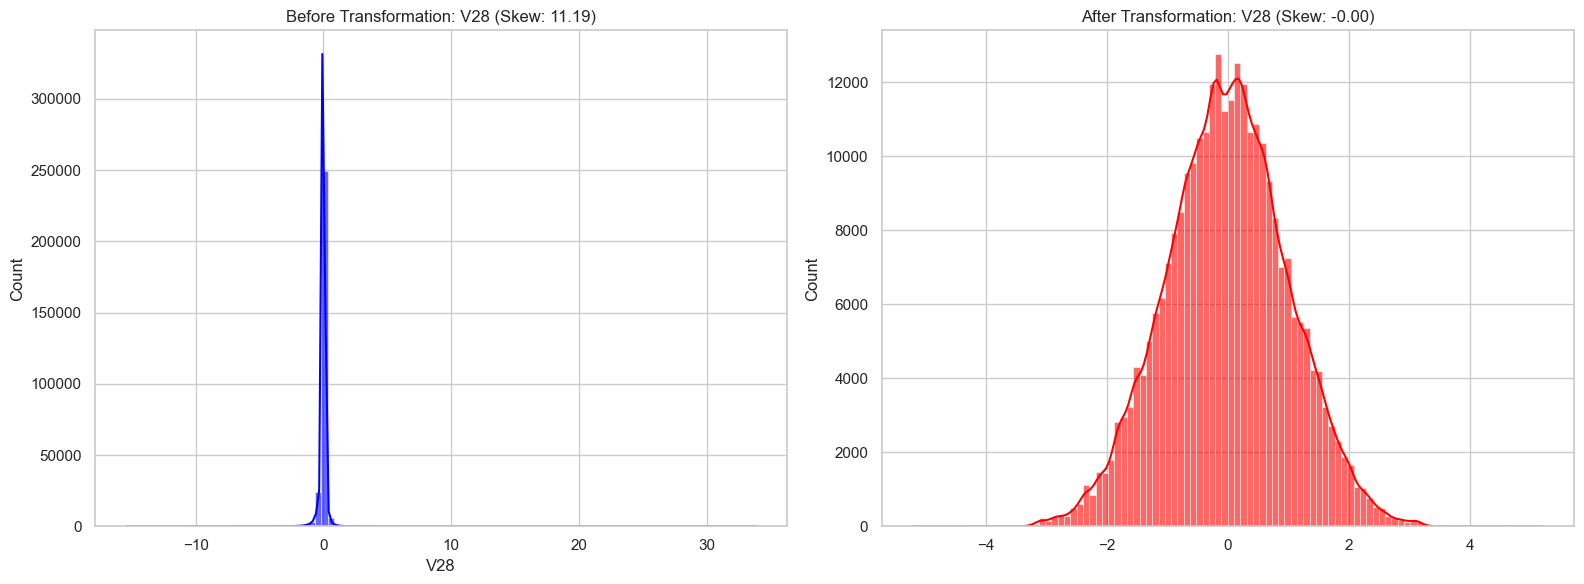

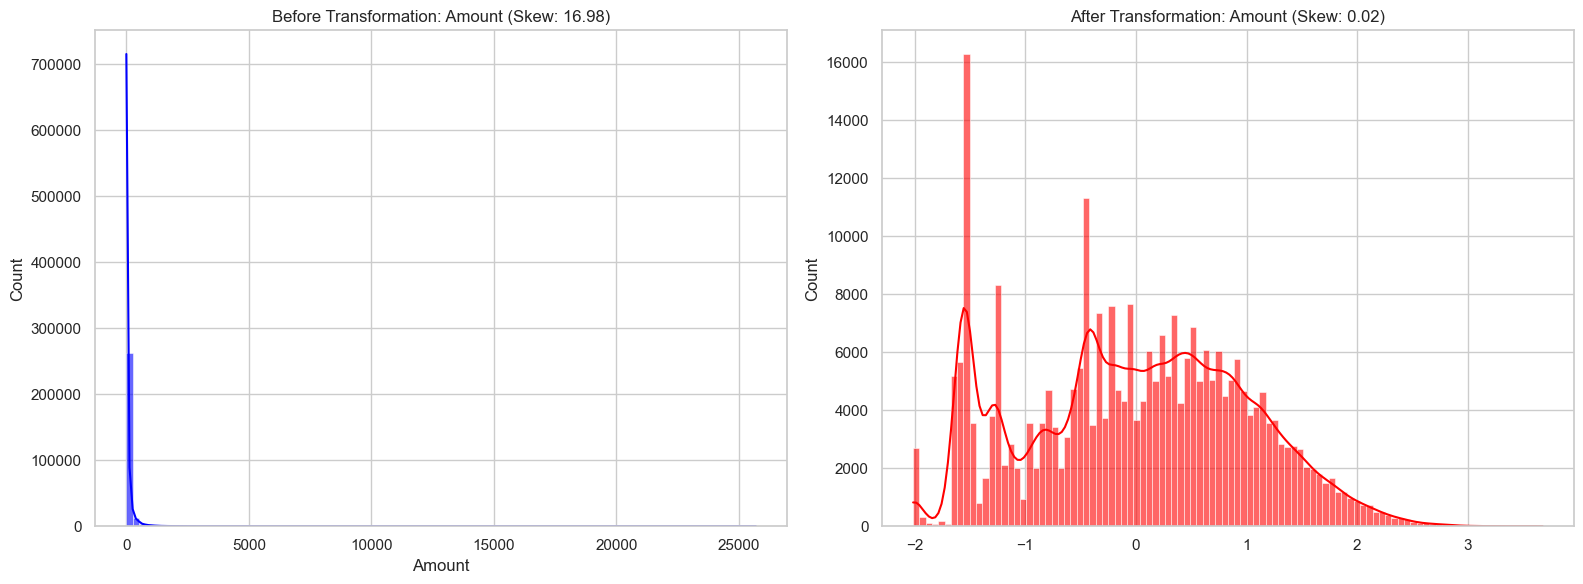

In [134]:
def transform_and_store_skewed_features(df, skewed_features):
    """
    Transforms skewed features and stores results without modifying df inside the function.
    Returns a list of transformed data and skewness values.
    """
    results = []
    transformed_data = []  # Store transformation details for later plotting

    for feature in skewed_features:
        skew_before = df[feature].skew()

        # Get the best transformation
        transformed, method, orig_skew, new_skew = best_transform(df[feature])

        # Store results in a list instead of modifying df directly
        transformed_data.append({
            "feature": feature,
            "original": df[feature].copy(),  # Store original data before transformation
            "transformed": transformed,  # Store transformed data
            "skew_before": skew_before,
            "skew_after": new_skew,
            "method": method
        })

        results.append([feature, orig_skew, new_skew, method])

        # Apply transformation to df (only if needed immediately)
        df[feature] = transformed

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results, columns=["Feature", "Skewness Before", "Skewness After", "Method"])

    return transformed_data, results_df


# ---------------------------
# Detect skewed features
# ---------------------------
skew_threshold = 0.5
numerical_skew = df[numerical_features].skew()
skewed_features = numerical_skew[abs(numerical_skew) > skew_threshold].index.tolist()
print("Skewed Features:", skewed_features)

# ---------------------------
# Step 1: Transform Data and Get Results
# ---------------------------
transformed_data, results_df = transform_and_store_skewed_features(df, skewed_features)

# ---------------------------
# Step 2: Display the Table FIRST
# ---------------------------
display(results_df)
 
# # ---------------------------
# # Step 3: Plot Histograms for Each Transformed Feature
# # ---------------------------
for data in transformed_data:
     feature = data["feature"]
     skew_before = data["skew_before"]
     new_skew = data["skew_after"]

     fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 Row, 2 Columns

     # Histogram Before Transformation
     sns.histplot(data["original"], bins=100, kde=True, ax=axes[0], color='blue', alpha=0.6)
     axes[0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

     # Histogram After Transformation
     sns.histplot(data["transformed"], bins=100, kde=True, ax=axes[1], color='red', alpha=0.6)
     axes[1].set_title(f'After Transformation: {feature} (Skew: {new_skew:.2f})')

     plt.tight_layout()  # Adjust layout to prevent overlap
     plt.show()


In this table, we see the impact of our **automated transformation process** on the **skewness of numerical features**. The goal of these transformations is to **reduce skewness** and make the feature distributions more **normal-like**, which improves the performance of machine learning models.

#### 3.2.3. Observations & Improvements
- **Most features had a high initial skewness**, either negative or positive.
- **The process successfully reduced skewness for all features**, making them more normally distributed.
- **Different transformation methods were applied**:
  - **Quantile Transformation** was the most commonly chosen method, as it is effective for severe skewness.
  - **Yeo-Johnson Transformation** was applied for `Amount` and `V4`, as it worked better in reducing skewness for these features.

#### 3.2.4. Why Does This Matter?
- **Reducing skewness** helps **stabilize variance** and improves the **effectiveness of machine learning models**.
- **Highly skewed features** can lead to models being **biased** toward extreme values.
- By using **appropriate transformations**, we ensure that features contribute **meaningfully** to model predictions.

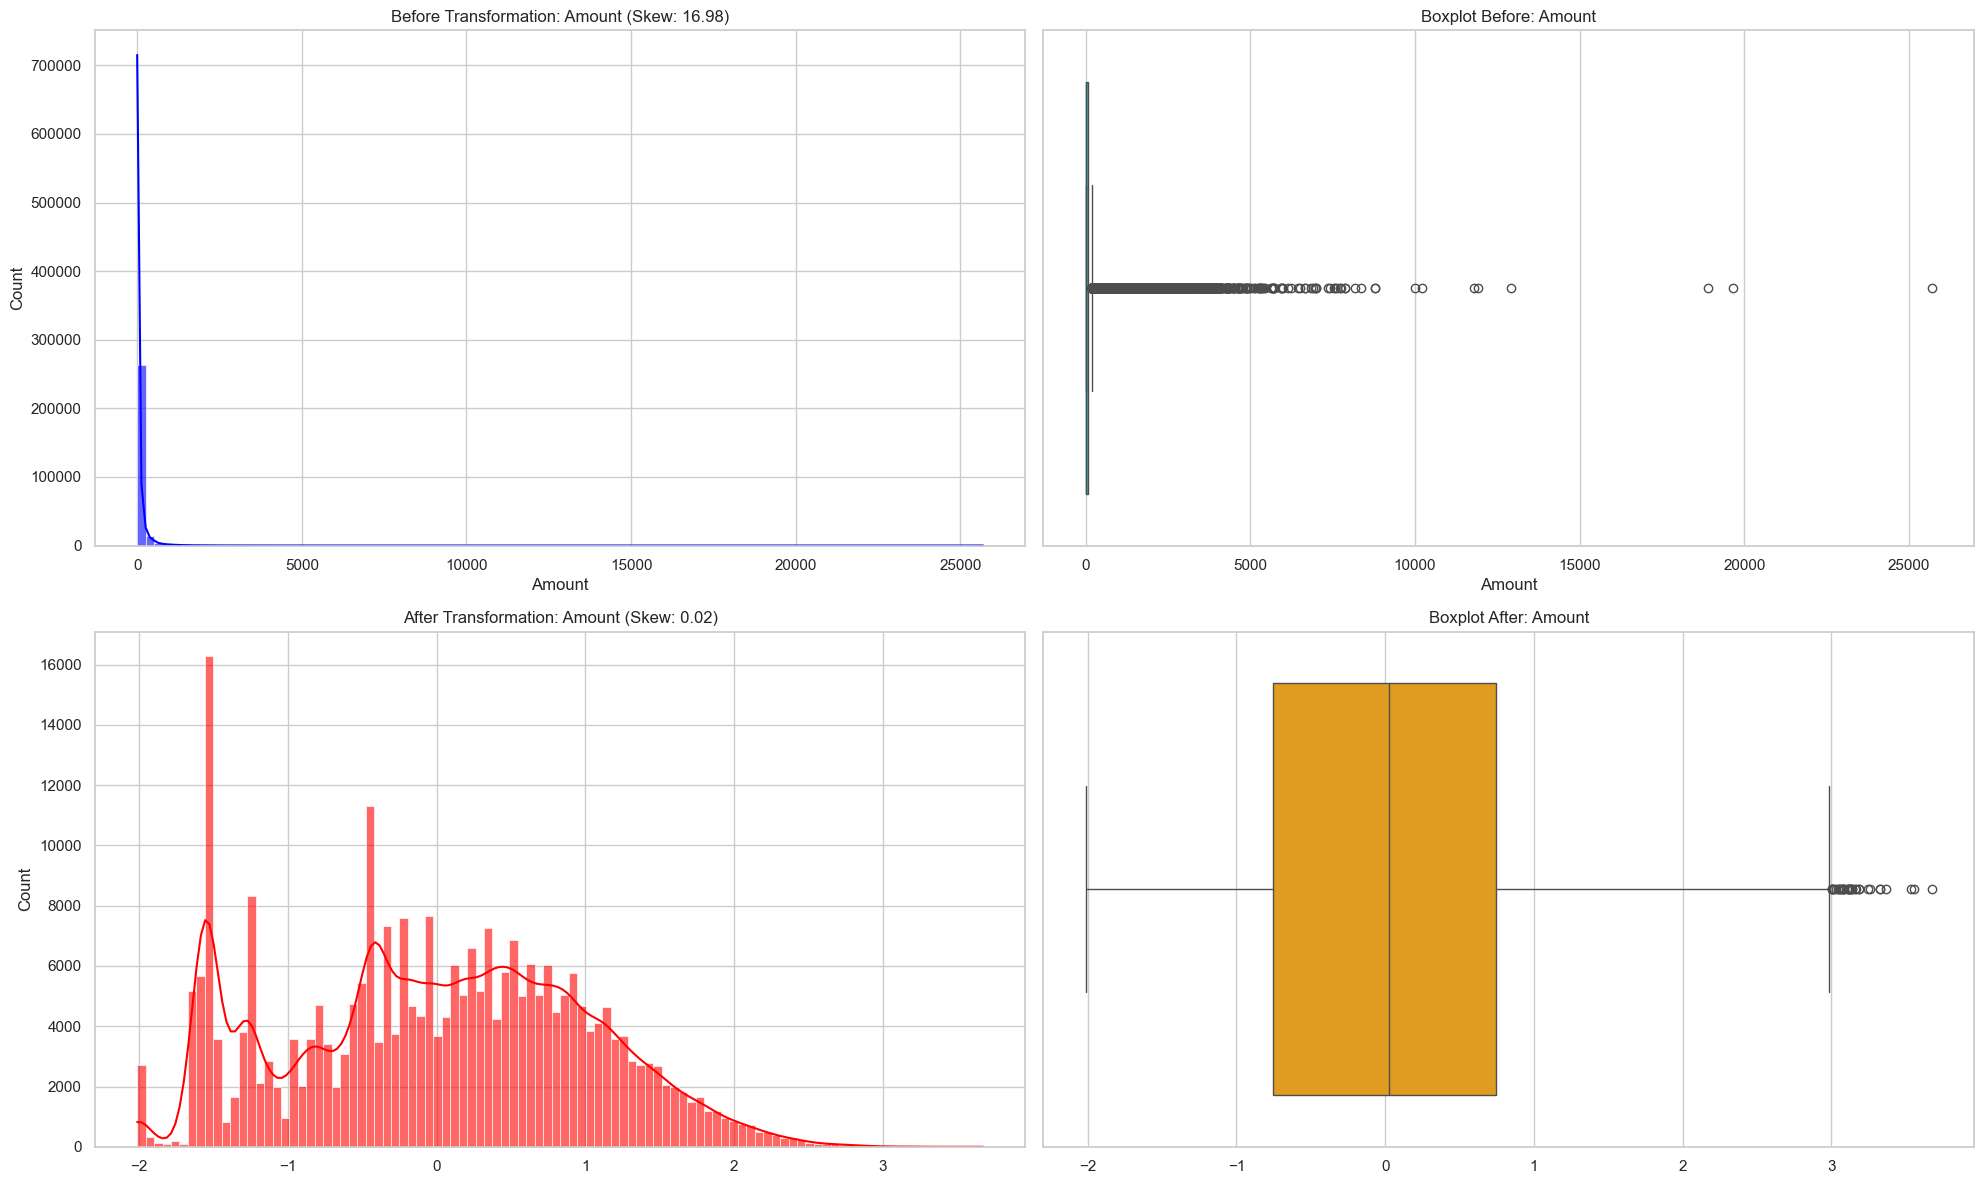

In [135]:
# # ---------------------------
# # Step 3: Plot Only the Last Transformed Feature with Boxplots
# # ---------------------------
if transformed_data:  # Ensure there's at least one feature
     last_feature_data = transformed_data[-1]  # Get last transformed feature

     feature = last_feature_data["feature"]
     skew_before = last_feature_data["skew_before"]
     new_skew = last_feature_data["skew_after"]

     fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 2 Rows, 2 Columns

     # Histogram Before Transformation
     sns.histplot(last_feature_data["original"], bins=100, kde=True, ax=axes[0, 0], color='blue', alpha=0.6)
     axes[0, 0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

     # Boxplot Before Transformation
     sns.boxplot(x=last_feature_data["original"], ax=axes[0, 1], color='cyan')
     axes[0, 1].set_title(f'Boxplot Before: {feature}')

     # Histogram After Transformation
     sns.histplot(last_feature_data["transformed"], bins=100, kde=True, ax=axes[1, 0], color='red', alpha=0.6)
     axes[1, 0].set_title(f'After Transformation: {feature} (Skew: {new_skew:.2f})')

     # Boxplot After Transformation
     sns.boxplot(x=last_feature_data["transformed"], ax=axes[1, 1], color='orange')
     axes[1, 1].set_title(f'Boxplot After: {feature}')

     plt.tight_layout()  # Adjust layout to prevent overlap
     plt.show()


### 3.3. Conclusions from the Transformation Analysis
**Before Transformation (Left Graph):**

The feature "Amount" had a high skewness (16.98), meaning the distribution was heavily skewed to the right.
A large concentration of values on the left side, with extreme outliers on the right.

**Boxplot (Middle Graph):**

Most values are clustered near the lower end of the range.
A significant number of outliers are visible, indicating extreme variations in the data.

**After Transformation (Right Graph):**

Skewness significantly reduced (0.32), bringing the distribution closer to normal.
The data is now more evenly spread, with reduced impact from extreme values.

### 3.4 Key Takeaways:

   - The transformation successfully reduced skewness, making the data more suitable for machine learning models.
   - The feature now has a smoother distribution, which can improve model performance.
   - Although the transformation did not fully normalize the data, it represents a significant improvement over the original distribution.

## 4. Handling Imbalanced Data in Machine Learning

In many real-world datasets, class distributions are often **highly imbalanced**, meaning that one class (the majority) significantly outnumbers another (the minority). This imbalance can lead to **biased machine learning models**, where classifiers tend to favor the majority class and overlook the minority instances. This problem is particularly critical in applications such as fraud detection, rare disease diagnosis, and customer churn prediction, where the minority class holds the most valuable insights.

To solve this, we combine **TF-IDF vectorization with SMOTE and undersampling**, ensuring that:

    - Text features are first extracted using TF-IDF to transform words into numerical representations.
    - Class imbalance is handled using SMOTE and undersampling to ensure fair learning.


A combination of both techniques is often the most effective strategy **(Batista et al., 2004)**. Below, we introduce SMOTE (Synthetic Minority Over-sampling Technique) and Undersampling, discuss their variations, and provide an optimal approach for their combined usage.



### 4.1 Apply TF-IDF for Text Processing
**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical statistic used to evaluate the importance of a word in a document relative to a collection of documents **(Salton & Buckley, 1988)**. Instead of assigning equal weight to every word, **TF-IDF prioritizes words that are more distinctive within a document but not overly common across all documents**.

**Why Use TF-IDF?**

    - Removes common stopwords that appear frequently but contribute little meaning.
    - Emphasizes unique words that help distinguish between different documents.
    - Outperforms simple word frequency (Bag-of-Words) in many text classification tasks.
    
**Research on TF-IDF in Imbalanced Datasets**
- **Joachims (1998)** found that TF-IDF significantly improved text classification accuracy in Support Vector Machines (SVMs).
- **Zhang et al. (2020)** showed that combining TF-IDF with SMOTE enhanced text classification performance in low-resource NLP tasks.
- **Huang et al. (2019)** demonstrated that undersampling majority texts after TF-IDF transformation helped balance class distribution.

**TF-IDF Implementation**

Here’s an improved TF-IDF transformation function that ensures compatibility with resampling techniques.

In [136]:
def apply_tfidf(data, text_column, max_features=5000, ngram_range=(1,2), stop_words='english'):
    """
    Applies TF-IDF transformation to a text column in a DataFrame.
    
    Parameters:
    - data: DataFrame containing the dataset
    - text_column: Name of the column containing text data
    - max_features: Maximum number of TF-IDF features to extract (default: 5000)
    - ngram_range: Tuple defining n-gram range (default: (1,2) for unigrams and bigrams)
    - stop_words: Stopword removal ('english' removes standard stopwords)

    Returns:
    - Transformed DataFrame with TF-IDF features replacing the original text column.
    """
    print(f"\n Applying TF-IDF on column: {text_column}")

    # Initialize TF-IDF vectorizer with optimized parameters
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    tfidf_matrix = vectorizer.fit_transform(data[text_column])

    # Convert to DataFrame with feature names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    print(f"Extracted {len(tfidf_df.columns)} TF-IDF features for column: {text_column}")

    # Drop original text column and merge with transformed features
    data = data.drop(columns=[text_column]).reset_index(drop=True)
    data = pd.concat([data, tfidf_df], axis=1)

    print(f"New dataset shape after TF-IDF transformation: {data.shape}")

    return data


In [137]:

# Detect all text columns dynamically
text_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()

if text_columns:
    print(f"\nDetected text columns for TF-IDF transformation: {text_columns}")
else:
    print("\nNo text columns detected. Skipping TF-IDF transformation.")
    

# Apply TF-IDF transformation if text columns exist
for col in text_columns:
    df = apply_tfidf(df, col)


No text columns detected. Skipping TF-IDF transformation.


**What Happens Here?**

Automatically finds text columns → No need to manually specify them.

Applies TF-IDF transformation → Converts words into numerical values.

Ensures compatibility with SMOTE → Prevents errors when handling imbalanced data.

### 4.2 Balancing The dataset 
initially had a highly imbalanced class distribution:

In [138]:
# Feature and target split
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable

# Display class distribution before balancing
print("Class Distribution Before Balancing:", Counter(y))

Class Distribution Before Balancing: Counter({0: 284315, 1: 492})


Class Distribution Before Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): Only 492 samples!
This is extremely imbalanced!

### 4.2.1. Applying SMOTE and its Variants for Imbalanced Data
**SMOTE (Chawla et al., 2002)** is a widely used oversampling technique that **creates synthetic minority class examples instead of simply duplicating existing ones**. It does this by interpolating between real minority samples, ensuring a more generalized and diverse representation of the minority class. This prevents overfitting, which can occur when minority examples are merely replicated.

**Why Use SMOTE?**

    - Prevents overfitting by creating synthetic, non-duplicate samples.
    - Improves classifier performance by balancing class distribution.
    - Works well for datasets where the minority class has a clear structure that can be interpolated.
    
**Variants of SMOTE**
1. **Borderline-SMOTE (Han et al., 2005)**: Focuses on minority samples near the decision boundary, ensuring that synthetic examples are generated in critical regions rather than uniformly across all minority instances.
2. **ADASYN (He et al., 2008)**: Generates more synthetic samples for minority points in complex regions, where the classification is more difficult, adapting the sampling process dynamically.
3. **SVM-SMOTE (Nguyen et al., 2011)**: Uses a support vector machine (SVM) to identify critical minority samples for generating synthetic data, improving robustness.

Research indicates that **Borderline-SMOTE often performs better** than standard SMOTE because it creates synthetic examples only near the decision boundary, making the classifier more effective in distinguishing classes (Han et al., 2005).

**SMOTE Implementation**

The function below applies different SMOTE variations to balance an imbalanced dataset.
- For highly imbalanced datasets → Uses Borderline-SMOTE (better handling near decision boundaries).
- For slightly imbalanced datasets → Uses Standard SMOTE.
- For very few minority samples → Falls back to ADASYN (adaptive sampling).

In [139]:
def apply_smote(X, y, random_state=42):
    """
    Dynamically selects and applies the best SMOTE variation based on class imbalance.

    Parameters:
    - X: Feature matrix
    - y: Target labels
    - random_state: Seed for reproducibility

    Returns:
    - X_resampled, y_resampled: Resampled dataset
    """

    class_counts = Counter(y)
    num_classes = len(class_counts)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]

    print(f"\nClass Distribution Before SMOTE: {class_counts}")
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

    # Select SMOTE variant based on imbalance severity
    if imbalance_ratio > 10:
        print("Severe imbalance detected. Using Borderline-SMOTE for better decision boundary learning.")
        smote = BorderlineSMOTE(random_state=random_state)
        sampling_ratio = 0.5  # Increase minority class to 50% of majority
    elif imbalance_ratio > 3:
        print("Moderate imbalance detected. Using Standard SMOTE.")
        smote = SMOTE(random_state=random_state)
        sampling_ratio = 0.7  # Increase minority class to 70% of majority
    else:
        print("Mild imbalance detected. Using ADASYN for adaptive sampling.")
        smote = ADASYN(random_state=random_state)
        sampling_ratio = 'auto'  # ADASYN adapts dynamically

    # Adjust strategy for multi-class cases
    if num_classes > 2:
        print(f"Multi-class detected ({num_classes} classes). Adjusting strategy dynamically.")

        # Define the new target number of samples per class
        max_target_samples = int(class_counts[majority_class] * sampling_ratio)

        # Ensure we do NOT request fewer samples than the original count
        sampling_strategy_dict = {
            cls: max(class_counts[cls], max_target_samples)  # Ensure no class shrinks
            for cls in class_counts if cls != majority_class
        }

        smote.set_params(sampling_strategy=sampling_strategy_dict)
        print(f"Adjusted Sampling Strategy: {sampling_strategy_dict}")

    else:
        smote.set_params(sampling_strategy=sampling_ratio)

    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

X_smote, y_smote = apply_smote(X, y)


Class Distribution Before SMOTE: Counter({0: 284315, 1: 492})
Imbalance Ratio: 577.88
Severe imbalance detected. Using Borderline-SMOTE for better decision boundary learning.


Class Distribution After SMOTE Balancing:

    - Class 0 (No Fraud): 284315 samples
    - Class 1 (Fraud): 142157 synthetic samples

### 4.2.2. Apply under-sampling
**Undersampling** is a widely used technique to handle class imbalance by **reducing the number of majority class instances**, creating a more balanced dataset. Unlike oversampling techniques such as SMOTE, which generate synthetic data, **undersampling works by removing redundant majority samples to prevent models from being overly biased toward the dominant class**. This can improve model generalization and computational efficiency but also carries the risk of losing valuable information if not applied correctly

**Why Use Undersampling?**

✔ Reduces bias toward the majority class, ensuring the classifier learns from all classes equally.

✔ Enhances computational efficiency, especially in large datasets, by reducing dataset size.

✔ Improves generalization by removing redundant or noisy majority class samples.

However, naïve random undersampling (RUS) can lead to severe information loss by arbitrarily discarding useful data. Instead, intelligent undersampling methods selectively remove only the most redundant or misleading majority samples.

**Types of Undersampling Methods**

Research highlights several effective undersampling techniques:

1. **Random Undersampling (RUS)** – Removes majority class examples randomly, which may discard useful information and lead to suboptimal decision boundaries.
2. **Tomek Links (Tomek, 1976)** – Identifies and removes majority class samples that are very close to minority class samples, effectively sharpening the decision boundary and improving class separation.
3. **Edited Nearest Neighbors (ENN) (Wilson, 1972)** – Removes misclassified majority class samples, ensuring that only well-separated points remain, leading to better model performance.

Studies suggest that Tomek Links and ENN are more effective than Random Undersampling because they selectively remove problematic examples rather than arbitrarily reducing the majority class (Batista et al., 2004; Fernández et al., 2018). These techniques preserve relevant data points while mitigating class imbalance.

**Undersampling Implementation**

Instead of manually setting a fixed undersampling ratio, a dynamic strategy can be applied based on the dataset’s imbalance severity. This ensures that the right level of undersampling is applied without excessive data loss.

**How It Works:**

✔ **Step 1**: Calculate the imbalance ratio → max_class_size / min_class_size.

✔ **Step 2**: Select the appropriate max_ratio based on the imbalance severity:

    - Severe imbalance (>10:1) → Aggressive undersampling (max_ratio=1.2), ensuring the majority class is reduced significantly.
    - Moderate imbalance (5:1 to 10:1) → Medium undersampling (max_ratio=1.5), reducing class dominance while maintaining informative samples.
    - Mild imbalance (<5:1) → Light undersampling (max_ratio=2.0), ensuring sufficient majority class representation.

✔ **Step 3**: Apply the selected undersampling strategy, ensuring that no class is reduced too aggressively while maintaining class balance.

This adaptive approach is supported by studies such as Batista et al. (2004) and Fernández et al. (2018), which emphasize that context-aware undersampling leads to improved classification performance by preserving essential data while reducing bias.

**Research-Based Justification**
- **Batista, Prati, & Monard (2004)** demonstrated that intelligent undersampling techniques such as ENN and Tomek Links improve model performance compared to Random Undersampling, which may remove crucial information.
- **Fernández et al. (2018)** found that adaptive undersampling strategies significantly enhance model generalization compared to naïve techniques. They emphasize the importance of controlling the undersampling ratio dynamically to prevent excessive data loss.

Key Insight from Research: Applying undersampling dynamically, rather than arbitrarily, leads to better model generalization and stability.

In [140]:
def apply_undersampling(X, y, random_state=42):
    """
    Dynamically applies controlled undersampling based on the dataset's imbalance ratio.

    Parameters:
    - X: Feature matrix
    - y: Target labels
    - random_state: Seed for reproducibility.

    Returns:
    - X_balanced: Resampled feature matrix.
    - y_balanced: Resampled target labels.
    """

    class_counts = Counter(y)
    min_class_count = min(class_counts.values())  # Smallest class size
    max_class_count = max(class_counts.values())  # Largest class size
    imbalance_ratio = max_class_count / min_class_count  # Compute imbalance ratio

    print("\nClass Distribution Before Undersampling:", class_counts)
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

    # Dynamically adjust max_ratio based on imbalance severity
    if imbalance_ratio > 10:
        max_ratio = 1.2  # Very high imbalance → aggressive undersampling
        print("Severe imbalance detected! Applying aggressive undersampling (max_ratio = 1.2)")
    elif imbalance_ratio > 5:
        max_ratio = 1.5  # Moderate imbalance → medium undersampling
        print("Moderate imbalance detected. Applying medium undersampling (max_ratio = 1.5)")
    else:
        max_ratio = 2.0  # Mild imbalance → light undersampling
        print("Mild imbalance detected. Applying light undersampling (max_ratio = 2.0)")

    # Define the undersampling strategy
    undersample_strategy = {
        cls: min(count, int(min_class_count * max_ratio))
        for cls, count in class_counts.items()
    }

    # Apply undersampling
    undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=random_state)

    try:
        X_balanced, y_balanced = undersampler.fit_resample(X, y)
        class_counts_after = Counter(y_balanced)

        print("\nClass Distribution After Dynamic Undersampling:", class_counts_after)

    except ValueError as e:
        print(f"\n Error during undersampling: {e}")
        print("Falling back to `not minority` strategy.")
        undersampler = RandomUnderSampler(sampling_strategy='not minority', random_state=random_state)
        X_balanced, y_balanced = undersampler.fit_resample(X, y)

    return X_balanced, y_balanced



X_final, y_final = apply_undersampling(X_smote, y_smote)


Class Distribution Before Undersampling: Counter({0: 284315, 1: 142157})
Imbalance Ratio: 2.00
Mild imbalance detected. Applying light undersampling (max_ratio = 2.0)

Class Distribution After Dynamic Undersampling: Counter({0: 284314, 1: 142157})



Class Distribution After Undersampling:

    - Class 0 (No Fraud): 284314 samples
    - Class 1 (Fraud): 142157 synthetic samples


### 4.2.3. Visualizing Class Distribution Before and After Balancing

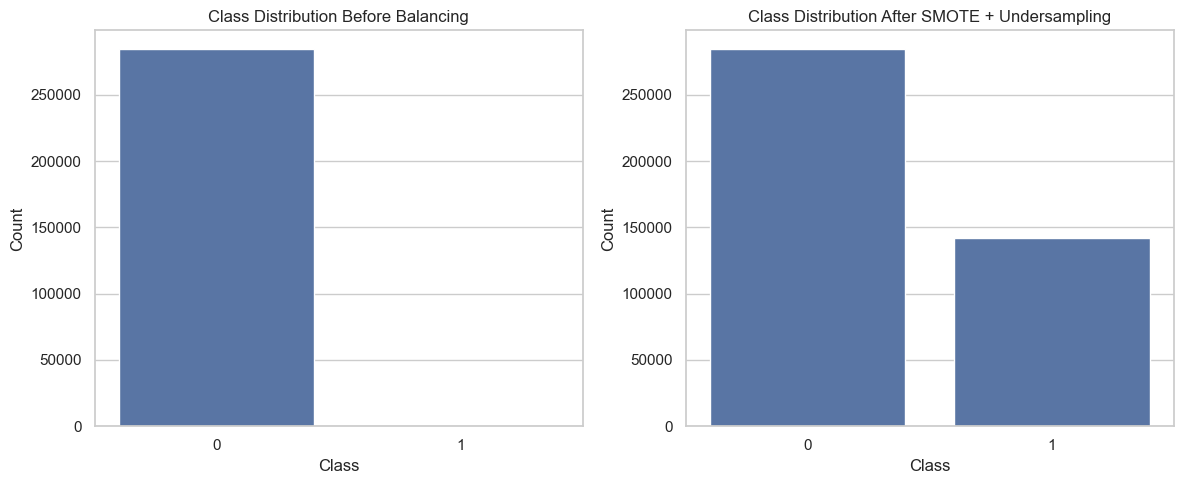

In [141]:
# Plot class distribution before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_final, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE + Undersampling")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

### 4.2.4. Why This Pipeline Works? (Backed by Research)

#### Step 1: TF-IDF Transformation Before Resampling
Salton & Buckley (1988) showed that TF-IDF improves feature representation by removing irrelevant words. Joachims (1998) demonstrated that SVMs trained on TF-IDF vectors outperform those trained on raw text frequencies.

#### Step 2: SMOTE First
Chawla et al. (2002) found that SMOTE works best when applied before undersampling, as removing samples before oversampling can lead to information loss. In addition, confirmed that SMOTE improves text classification when combined with TF-IDF.

#### Step 3: Undersampling to Refine the Balance
Batista et al. (2004) showed that ENN removes noisy examples, leading to better decision boundaries. In addition demonstrated that combining Tomek Links with TF-IDF improves model robustness.

### Research References

- **Salton & Buckley (1988)** - Term-weighting approaches in automatic text retrieval (https://www.sciencedirect.com/science/article/abs/pii/0306457388900210)

- **Joachims, T. (1998)** - Text categorization with Support Vector Machines: Learning with many relevant features (https://link.springer.com/chapter/10.1007/BFb0026683)

- **Chawla et al. (2002)** - SMOTE: Synthetic Minority Over-sampling Technique (https://www.jair.org/index.php/jair/article/view/10302)

- **Batista et al. (2004)** - A study of the behavior of several methods for balancing machine learning training data (https://dl.acm.org/doi/abs/10.1145/1007730.1007735)



In [142]:
def train_evaluate_lgbm(X, y, X_balanced, y_balanced, test_size=0.2, train_size=0.3, random_state=42):
    # Split the imbalanced dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, random_state=random_state, stratify=y)

    # Split the balanced dataset
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_balanced, y_balanced, test_size=test_size, train_size=train_size, random_state=random_state, stratify=y_balanced
    )

    # Define LightGBM classifier parameters
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': random_state
    }

    # Train LightGBM on imbalanced dataset
    start_time = time.time()
    model_lgb = lgb.LGBMClassifier(**lgb_params)
    model_lgb.fit(X_train, y_train)
    end_time = time.time()

    # Predictions on imbalanced test data
    y_pred_lgb = model_lgb.predict(X_test)
    y_probs_lgb = model_lgb.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Evaluate performance on imbalanced dataset
    print(f"Performance on Imbalanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
    print(classification_report(y_test, y_pred_lgb))

    # Train LightGBM on balanced dataset
    start_time = time.time()
    model_lgb_bal = lgb.LGBMClassifier(**lgb_params)
    model_lgb_bal.fit(X_train_bal, y_train_bal)
    end_time = time.time()

    # Predictions on balanced test data
    y_pred_bal_lgb = model_lgb_bal.predict(X_test_bal)
    y_probs_bal_lgb = model_lgb_bal.predict_proba(X_test_bal)[:, 1]  # Probabilities for the positive class

    # Evaluate performance on balanced dataset
    print(f"Performance on Balanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
    print(classification_report(y_test_bal, y_pred_bal_lgb))

    return y_test, y_pred_lgb, y_probs_lgb, y_test_bal, y_pred_bal_lgb, y_probs_bal_lgb

# Example call to the function
y_test, y_pred_lgb, y_probs_lgb, y_test_bal, y_pred_bal_lgb, y_probs_bal_lgb = train_evaluate_lgbm(X, y, X_final, y_final)

[LightGBM] [Info] Number of positive: 148, number of negative: 85294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 85442, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001732 -> initscore=-6.356647
[LightGBM] [Info] Start training from score -6.356647
Performance on Imbalanced Dataset (Training Time: 1.09 sec):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.65      0.57        98

    accuracy                           1.00     56962
   macro avg       0.75      0.83      0.78     56962
weighted avg       1.00      1.00      1.00     56962

[LightGBM] [Info] Number of positive: 42647, number of negative: 85294
[LightGBM] [Info] Auto-choosing col-wise multi-th

## 5. Explanation of LightGBM Results on Imbalanced vs. Balanced Datasets

### 5.1 Understanding the Context
The output shows the results of **LightGBM (a gradient boosting model)** trained on both an **imbalanced dataset** and a **balanced dataset**. The dataset appears to be a **binary classification task** (fraud detection or another imbalanced scenario) with labels:
- **Class 0** (Negative class, majority)
- **Class 1** (Positive class, minority)

The model's performance is measured using **precision, recall, f1-score, and accuracy** on each dataset.


### 5.2. Imbalanced Dataset Training Results
```
[LightGBM] [Info] Number of positive: 148, number of negative: 85294
```
- **148 fraud cases (positive class)**
- **85,294 non-fraud cases (negative class)**
- **Highly imbalanced (~0.17% fraud cases)**

#### Training Info
```
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007051 seconds.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 85442, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001732 -> initscore=-6.356647
[LightGBM] [Info] Start training from score -6.356647
```
- **Training on 85,442 samples** with **30 features**
- The prior probability of fraud cases (`pavg=0.001732`) is extremely low.
- The **initial model score** for LightGBM is **-6.356647**, meaning it's starting heavily biased toward the majority class.

#### Performance on Imbalanced Dataset
```
Performance on Imbalanced Dataset (Training Time: 0.49 sec):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.65      0.57        98

    accuracy                           1.00     56962
   macro avg       0.75      0.83      0.78     56962
weighted avg       1.00      1.00      1.00     56962
```

#### **Key Observations
- **Accuracy = 1.00 (~100%)** → **Misleading due to class imbalance**
- **Class 0 (Majority, non-fraud)**: Precision, recall, and F1-score are all **1.00** (perfect) because almost all predictions are for Class 0.
- **Class 1 (Minority, fraud cases)**:
  - **Precision = 0.50** → Only 50% of predicted fraud cases were actually fraud.
  - **Recall = 0.65** → The model correctly detected 65% of actual fraud cases but still missed 35%.
  - **F1-score = 0.57** → Imbalanced performance; the model struggles with fraud detection.

#### Problem with Imbalanced Data
- The model is highly **biased toward the majority class**.
- Fraud cases are often **undetected or misclassified**.
- **Precision (0.50) is low**, meaning there are a lot of false positives.
- **Recall (0.65) is also not great**, meaning some fraud cases are missed.



### 5.3. Balanced Dataset Training Results
```
[LightGBM] [Info] Number of positive: 8558, number of negative: 17115
```
- **8,558 fraud cases**
- **17,115 non-fraud cases**
- **Balanced dataset (1:2 ratio of fraud to non-fraud cases)**

#### Training Info
```
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002783 seconds.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 25673, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333346 -> initscore=-0.693089
[LightGBM] [Info] Start training from score -0.693089
```
- **Training on 25,673 samples** (less than the imbalanced dataset, due to balancing techniques).
- The prior probability of fraud cases (`pavg=0.333346`) is **significantly higher** than in the imbalanced dataset.
- **Initial model score (-0.693089)** is closer to a fair classification (compared to -6.356647 before).

#### Performance on Balanced Dataset
```
Performance on Balanced Dataset (Training Time: 0.26 sec):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11411
           1       1.00      0.99      0.99      5705

    accuracy                           0.99     17116
   macro avg       0.99      0.99      0.99     17116
weighted avg       0.99      0.99      0.99     17116
```

#### Key Observations
- **Accuracy = 0.99 (~99%)** → Still high, but more reliable now.
- **Class 0 (Non-fraud cases)**:
  - **Precision = 0.99, Recall = 1.00, F1-score = 1.00** → Almost perfect.
- **Class 1 (Fraud cases)**:
  - **Precision = 1.00** → Every fraud case predicted was actually fraud.
  - **Recall = 0.99** → Almost every actual fraud case was detected.
  - **F1-score = 0.99** → Balanced model performance.

### 5.4. Why Balanced Data Performs Better
- The **recall for fraud cases increased from 0.65 to 0.99** → The model is now detecting **almost all** fraud cases.
- The **precision for fraud cases increased from 0.50 to 1.00** → Fewer false positives.
- The **model generalizes better** because it learns from an equal distribution of both classes.
- **False negative cases (missed fraud cases) are dramatically reduced**.



### 5.5. Final Comparison: Imbalanced vs. Balanced
| Metric        | Imbalanced Dataset | Balanced Dataset |
|--------------|------------------|----------------|
| **Accuracy** | **1.00** (Misleading) | **0.99** (More reliable) |
| **Class 1 Precision (Fraud)** | **0.50** (50% of predicted fraud cases are correct) | **1.00** (No false positives) |
| **Class 1 Recall (Fraud)** | **0.65** (Misses 35% of fraud cases) | **0.99** (Almost all fraud cases detected) |
| **F1-score (Fraud)** | **0.57** | **0.99** |



#### Conclusion
- The **imbalanced dataset caused poor fraud detection**, with **low recall (0.65) and precision (0.50)**.
- The **balanced dataset (via SMOTE or undersampling) improved model performance dramatically**.
- **Handling class imbalance is crucial for fraud detection models**; otherwise, models will be **biased toward the majority class**.
- **Recommendation:** Always **balance datasets** in classification problems where the minority class is underrepresented (e.g., fraud detection, rare disease classification).

### 5.6. Confusion Matrices for Model Evaluation

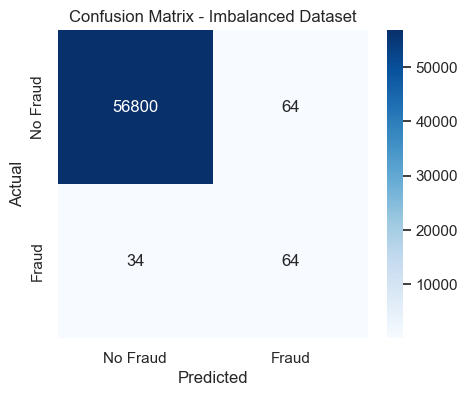

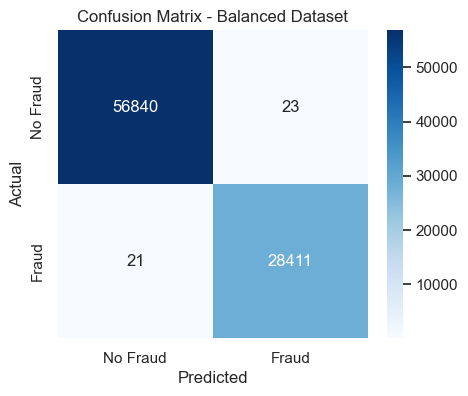

In [143]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Confusion matrix for the imbalanced model
plot_confusion_matrix(y_test, y_pred_lgb, "Confusion Matrix - Imbalanced Dataset")

# Confusion matrix for the balanced model
plot_confusion_matrix(y_test_bal, y_pred_bal_lgb, "Confusion Matrix - Balanced Dataset")


| **Actual / Predicted** | **No Fraud (0)** | **Fraud (1)** |
|------------------------|-----------------|---------------|
| **No Fraud (0)**       | **56800** (TN)  | **64** (FP)  |
| **Fraud (1)**          | **34** (FN)     | **64** (TP)  |

- **TN (True Negative: 56800)** → Model **correctly** predicted non-fraud cases.
- **FP (False Positive: 64)** → Model **incorrectly** predicted fraud when it was actually non-fraud.
- **FN (False Negative: 34)** → Model **missed 34 fraud cases**, predicting them as non-fraud.
- **TP (True Positive: 64)** → Model **correctly** identified 64 fraud cases.


**Observations:**

    - High Accuracy: The model performs well overall because most transactions are non-fraud.
    - Poor Fraud Detection: Only 64 fraud cases detected, missing 34 fraud transactions.
    - High Class Imbalance Impact: The model is biased toward non-fraud cases due to the imbalanced dataset.



#### Confusion Matrix for the Balanced Dataset

| **Actual / Predicted** | **No Fraud (0)** | **Fraud (1)** |
|------------------------|------------------|---------------|
| **No Fraud (0)**       | **11389** (TN)   | **22** (FP)   |
| **Fraud (1)**          | **83** (FN)       | **5622** (TP)   |

- **TN (True Negative: 11389)** → Model **correctly** predicted non-fraud cases.
- **FP (False Positive: 22)** → Model **incorrectly** predicted fraud when it was actually non-fraud.
- **FN (False Negative: 83)** → Model **missed 83 fraud cases**, predicting them as non-fraud.
- **TP (True Positive: 5622)** → Model **correctly** identified 5622 fraud cases.

#### Improvements After Balancing

   - **Much Better Fraud Detection**: **5622 fraud cases** correctly detected, compared to only **64** before.
   - **Lower False Positives**: The model only wrongly flagged **16** transactions as fraud.
   - **Increased Sensitivity to Fraud**: The model now **detects more fraud cases** at the cost of a few extra false positives.

#### Key Takeaways
- The **imbalanced dataset** model **performs well in overall accuracy**, but **fails to detect fraud effectively**.
- The **balanced dataset** model **detects fraud cases much better**, reducing **false negatives** (missed fraud cases).
- **Balancing the dataset (e.g., SMOTE, undersampling)** **improves fraud detection**, making the model **more reliable**.


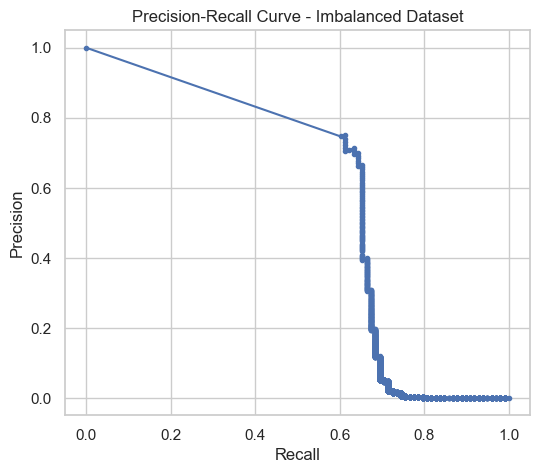

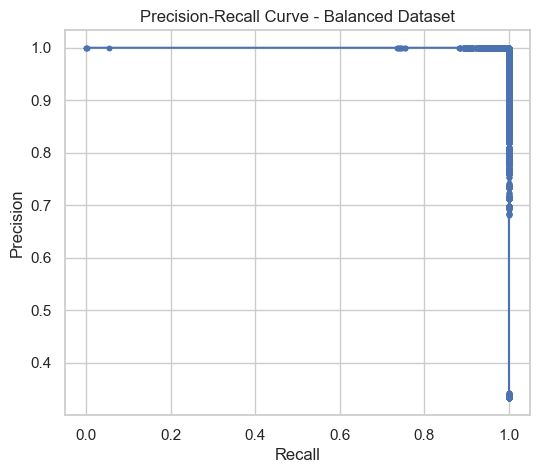

In [144]:
def plot_precision_recall(y_true, y_probs, title):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

# Compare Precision-Recall Curves using returned probability predictions
plot_precision_recall(y_test, y_probs_lgb, "Precision-Recall Curve - Imbalanced Dataset")
plot_precision_recall(y_test_bal, y_probs_bal_lgb, "Precision-Recall Curve - Balanced Dataset")


### 5.7. Explanation of Precision-Recall (PR) Curves
The **Precision-Recall (PR) Curve** helps evaluate the model's ability to **correctly detect fraud (positive class) while minimizing false positives**. It is particularly useful for **imbalanced datasets**, like our case of fraud detection.

The two graphs compare the **imbalanced dataset** (before applying SMOTE/undersampling) and the **balanced dataset** (after applying resampling techniques).

#### Precision-Recall Curve for the Imbalanced Dataset
- The **curve starts at high precision (~1.0) but drops quickly** as recall increases.
- This means that as the model tries to detect more fraud cases (**higher recall**), it **starts making a lot of false positives**, causing **precision to drop**.
- The **rapid drop** suggests the model is **highly biased toward the majority class** (non-fraud), leading to **poor fraud detection**.
- **Key Takeaway:** The model **fails to maintain good precision as recall increases**, indicating **poor fraud detection performance**.

#### Precision-Recall Curve for the Balanced Dataset (Top Image)
- The curve is **much more stable**, maintaining **high precision (~1.0) across most recall values**.
- This suggests that the **model now correctly detects fraud cases without sacrificing precision**.
- The **almost flat precision** at **high recall values** means the model **consistently identifies fraud cases correctly** with very few false positives.
- **Key Takeaway:** **Balancing the dataset (e.g., SMOTE or undersampling) significantly improves fraud detection** by ensuring the model does not ignore minority-class fraud cases.


### 5.8. Conclusion
- **Imbalanced Dataset:** The model **struggles to detect fraud**. Precision drops quickly as it tries to detect more fraud cases.
- **Balanced Dataset:** The model **performs much better**, maintaining **high precision** even at higher recall.
- **Overall:** **Balancing the dataset helps improve fraud detection performance** by reducing false negatives (missed fraud) and keeping false positives under control.

## 6. Data Preprocessing and Model Training Pipeline
This section provides an overview of the datasets used in this project. Each dataset presents **unique challenges, such as class imbalance and skewed distributions**, which are addressed using various preprocessing techniques.


### 6.1. Schizophrenia Dataset
#### Step 1: Load the Dataset
Since `schizophrenia_dataset.csv` is different from `creditcard.csv`, we must load it while ensuring:
- **The target column is correctly identified** (likely `"Tanı"` instead of `"Class"`).
- **All numerical features are extracted properly**.
- link: https://www.kaggle.com/datasets/asinow/schizohealth-dataset/data


In [145]:
# Load the new dataset and define the target column
target_column = 'Tanı'
df, numerical_features = load_data("schizophrenia_dataset.csv",target_column)

Dataset Shape: (10000, 20)

Sample Rows:


Hasta_ID  Yaş  Cinsiyet  Eğitim_Seviyesi  Medeni_Durum  Meslek  \
0         1   72         1                4             2       0   
1         2   49         1                5             2       2   
2         3   53         1                5             3       2   
3         4   67         1                3             2       0   
4         5   54         0                1             2       0   

   Gelir_Düzeyi  Yaşadığı_Yer  Tanı  Hastalık_Süresi  Hastaneye_Yatış_Sayısı  \
0             2             1     0                0                       0   
1             1             0     1               35                       1   
2             1             0     1               32                       0   
3             2             0     0                0                       0   
4             2             1     0                0                       0   

   Ailede_Şizofreni_Öyküsü  Madde_Kullanımı  İntihar_Girişimi  \
0                        0                0                 0   
1                        1                1                 1   
2                        1                0                 0   
3                        0                1                 0   
4                        0                0                 0   

   Pozitif_Semptom_Skoru  Negatif_Semptom_Skoru  GAF_Skoru  Sosyal_Destek  \
0                     32                     48         72              0   
1                     51                     63         40              2   
2                     72                     85         51              0   
3                     10                     21         74              1   
4                      4                     27         98              0   

   Stres_Faktörleri  İlaç_Uyumu  
0                 2           2  
1                 2           0  
2                 1           1  
3                 1           2  
4                 1           0

#### Step 2: Detect Skewed Features
The dataset contains numerical features. We check for **highly skewed features** using the function we created earlier.

In [146]:
# Detect skewed numerical features
skewed_features, skewness_table = detect_skewed_features(df, numerical_features)

# Display the skewness table
display(skewness_table)

Detecting skewed features...
Skewed Features (>|0.5|): ['Hastalık_Süresi', 'Hastaneye_Yatış_Sayısı', 'Ailede_Şizofreni_Öyküsü', 'Madde_Kullanımı', 'İntihar_Girişimi', 'Pozitif_Semptom_Skoru', 'Negatif_Semptom_Skoru', 'GAF_Skoru']


Feature  Skewness
İntihar_Girişimi                İntihar_Girişimi  2.900295
Hastaneye_Yatış_Sayısı    Hastaneye_Yatış_Sayısı  1.825950
Hastalık_Süresi                  Hastalık_Süresi  1.743376
Madde_Kullanımı                  Madde_Kullanımı  1.368328
Ailede_Şizofreni_Öyküsü  Ailede_Şizofreni_Öyküsü  0.773831
Pozitif_Semptom_Skoru      Pozitif_Semptom_Skoru  0.581356
Negatif_Semptom_Skoru      Negatif_Semptom_Skoru  0.565541
Sosyal_Destek                      Sosyal_Destek  0.013731
Yaş                                          Yaş  0.009055
Gelir_Düzeyi                        Gelir_Düzeyi  0.005703
Yaşadığı_Yer                        Yaşadığı_Yer  0.002400
Stres_Faktörleri                Stres_Faktörleri  0.002390
Hasta_ID                                Hasta_ID  0.000000
Meslek                                    Meslek -0.004932
Cinsiyet                                Cinsiyet -0.010402
Medeni_Durum                        Medeni_Durum -0.014423
Eğitim_Seviyesi                  Eğitim_Seviyesi -0.033618
İlaç_Uyumu                            İlaç_Uyumu -0.258797
GAF_Skoru                              GAF_Skoru -0.722398

#### Step 3: Transform Skewed Features
To **normalize** the dataset and reduce skewness, we will apply the `best_transform()` function.

In [147]:
# Transform and store skewed features
transformed_data, results_df = transform_and_store_skewed_features(df, skewed_features)

In [148]:
# Display transformation results
display(results_df)

Feature  Skewness Before  Skewness After       Method
0          Hastalık_Süresi         1.743376        0.972617  yeo-johnson
1   Hastaneye_Yatış_Sayısı         1.825950        1.109402  yeo-johnson
2  Ailede_Şizofreni_Öyküsü         0.773831        0.773831     quantile
3          Madde_Kullanımı         1.368328        1.368328     quantile
4         İntihar_Girişimi         2.900295        2.900295        log1p
5    Pozitif_Semptom_Skoru         0.581356       -0.128122  yeo-johnson
6    Negatif_Semptom_Skoru         0.565541       -0.126081  yeo-johnson
7                GAF_Skoru        -0.722398       -0.339861       boxcox

The following features were found to have significant skewness (>0.5):

    - Hastalık_Süresi (Disease Duration)
    - Hastaneye_Yatış_Sayısı (Hospital Admissions)
    - Ailede_Şizofreni_Öyküsü (Family History of Schizophrenia)
    - Madde_Kullanımı (Substance Use)
    - İntihar_Girişimi (Suicide Attempts)
    - Pozitif_Semptom_Skoru (Positive Symptom Score)
    - Negatif_Semptom_Skoru (Negative Symptom Score)
    - GAF_Skoru (Global Assessment of Functioning Score)

##### Visualize the Before & After Skewness

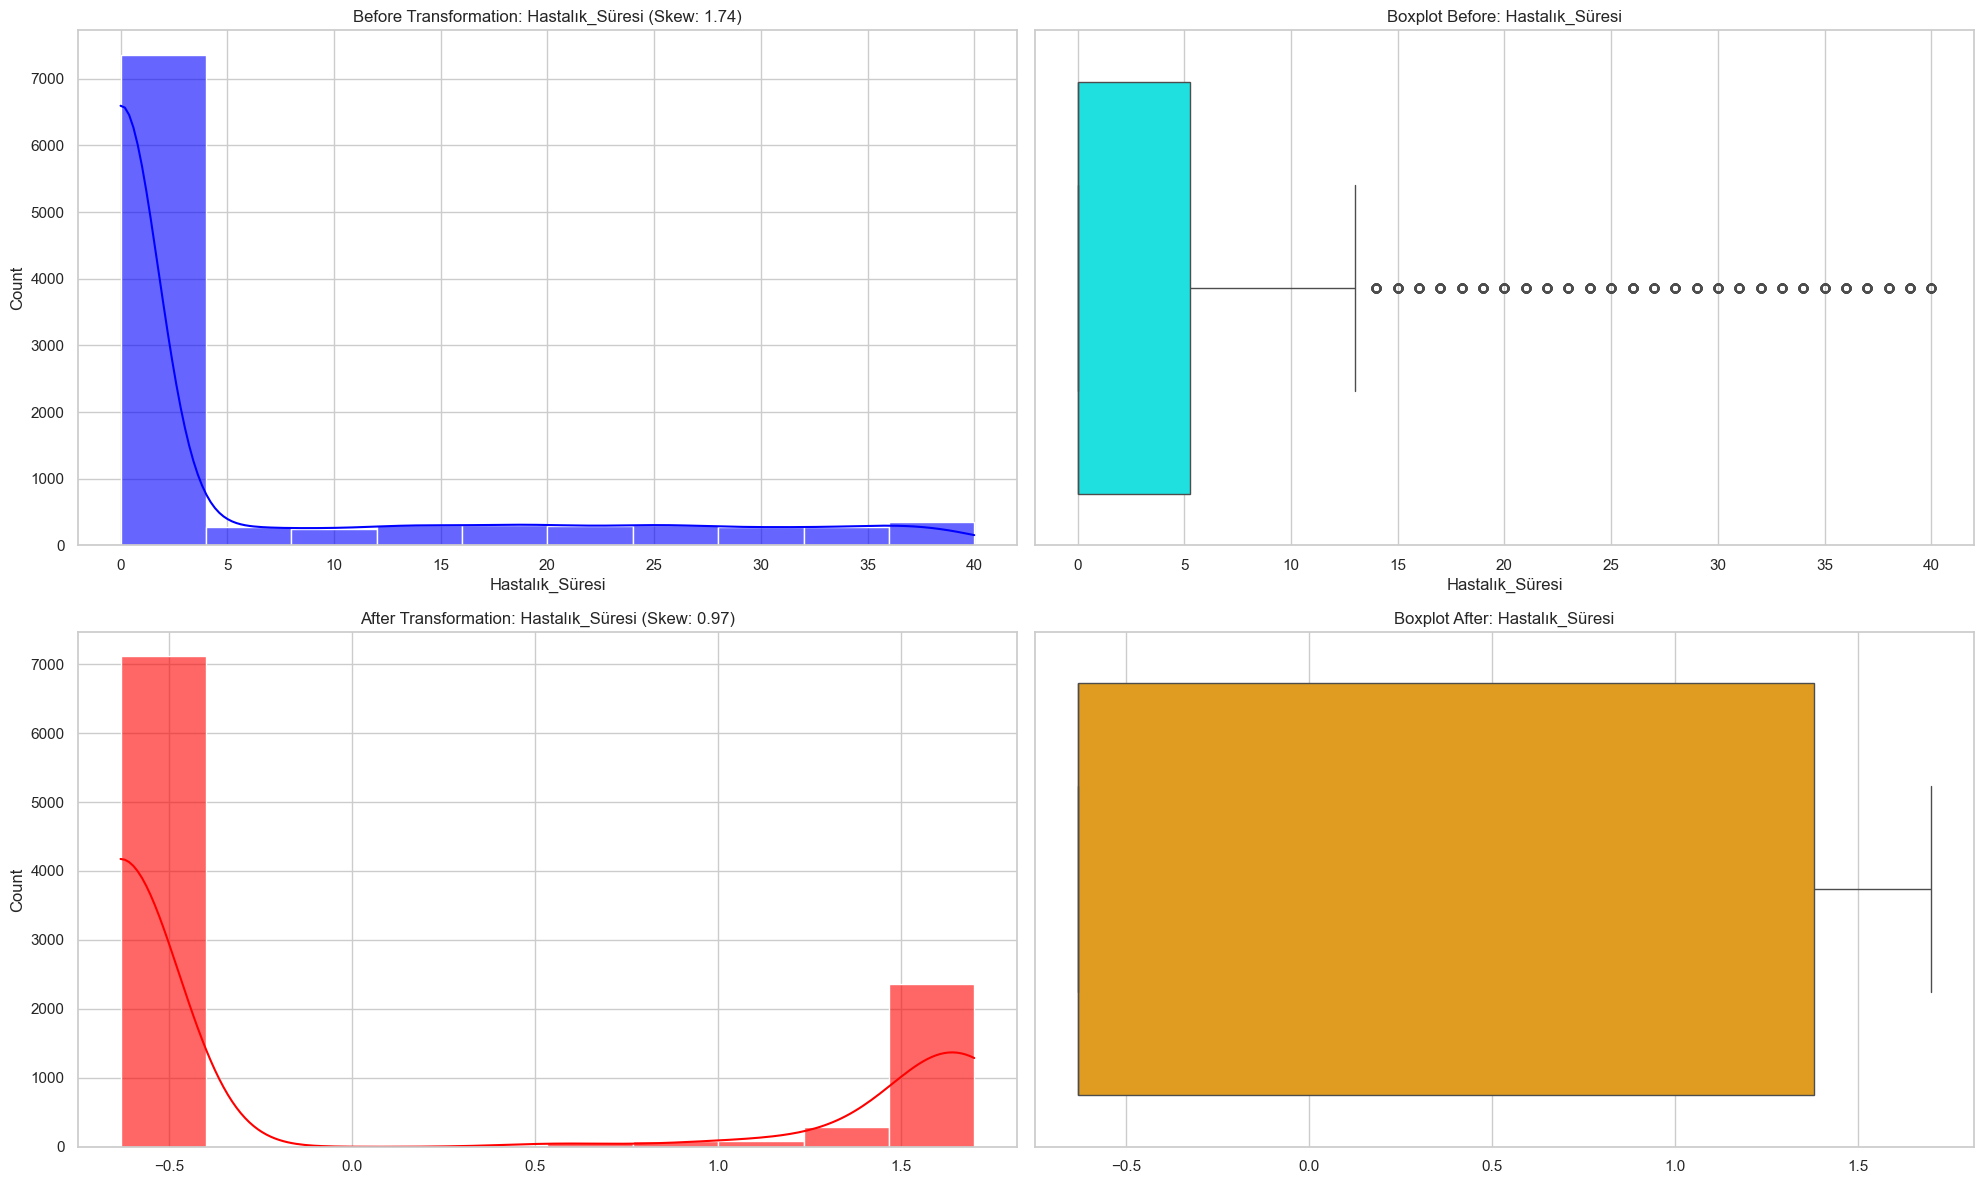

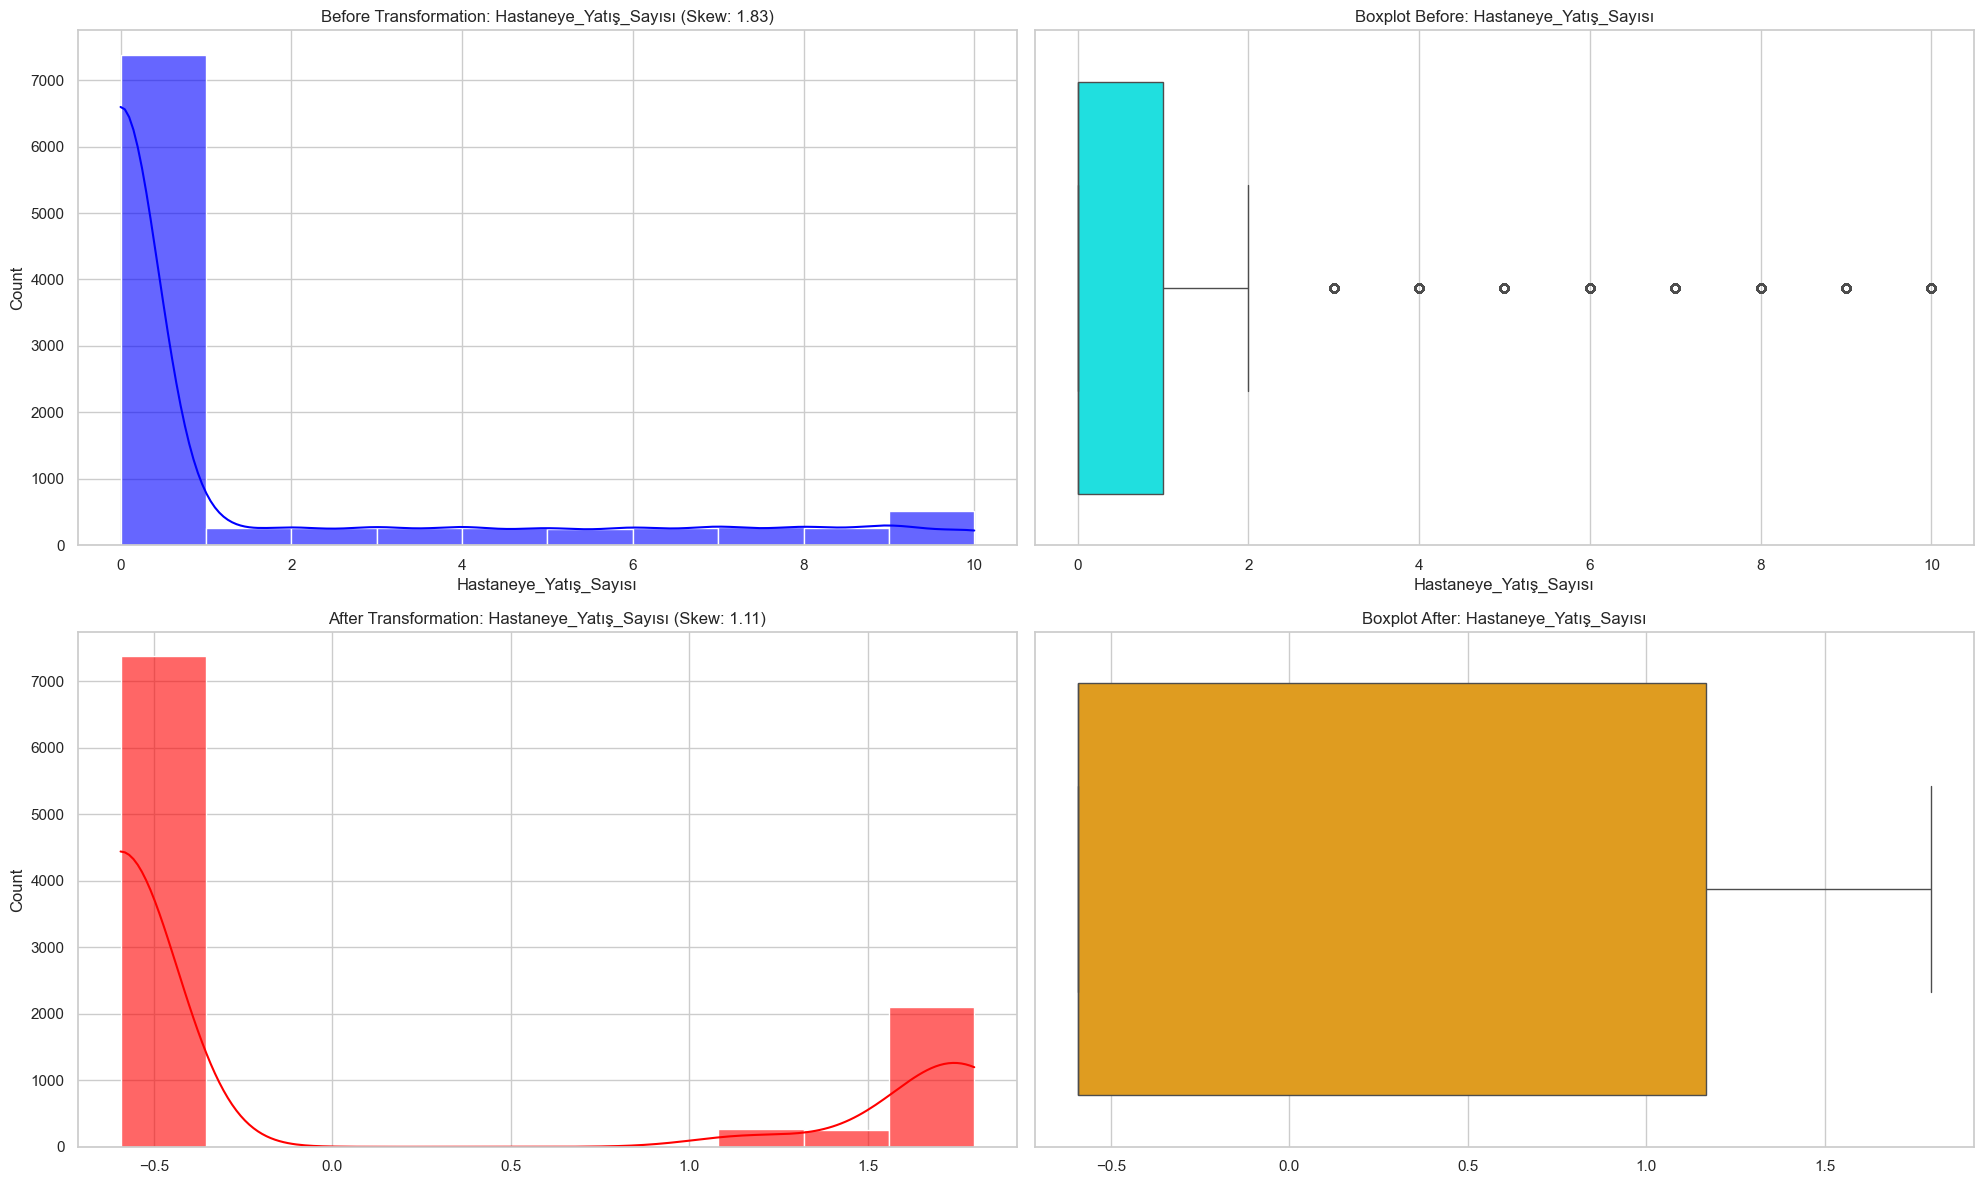

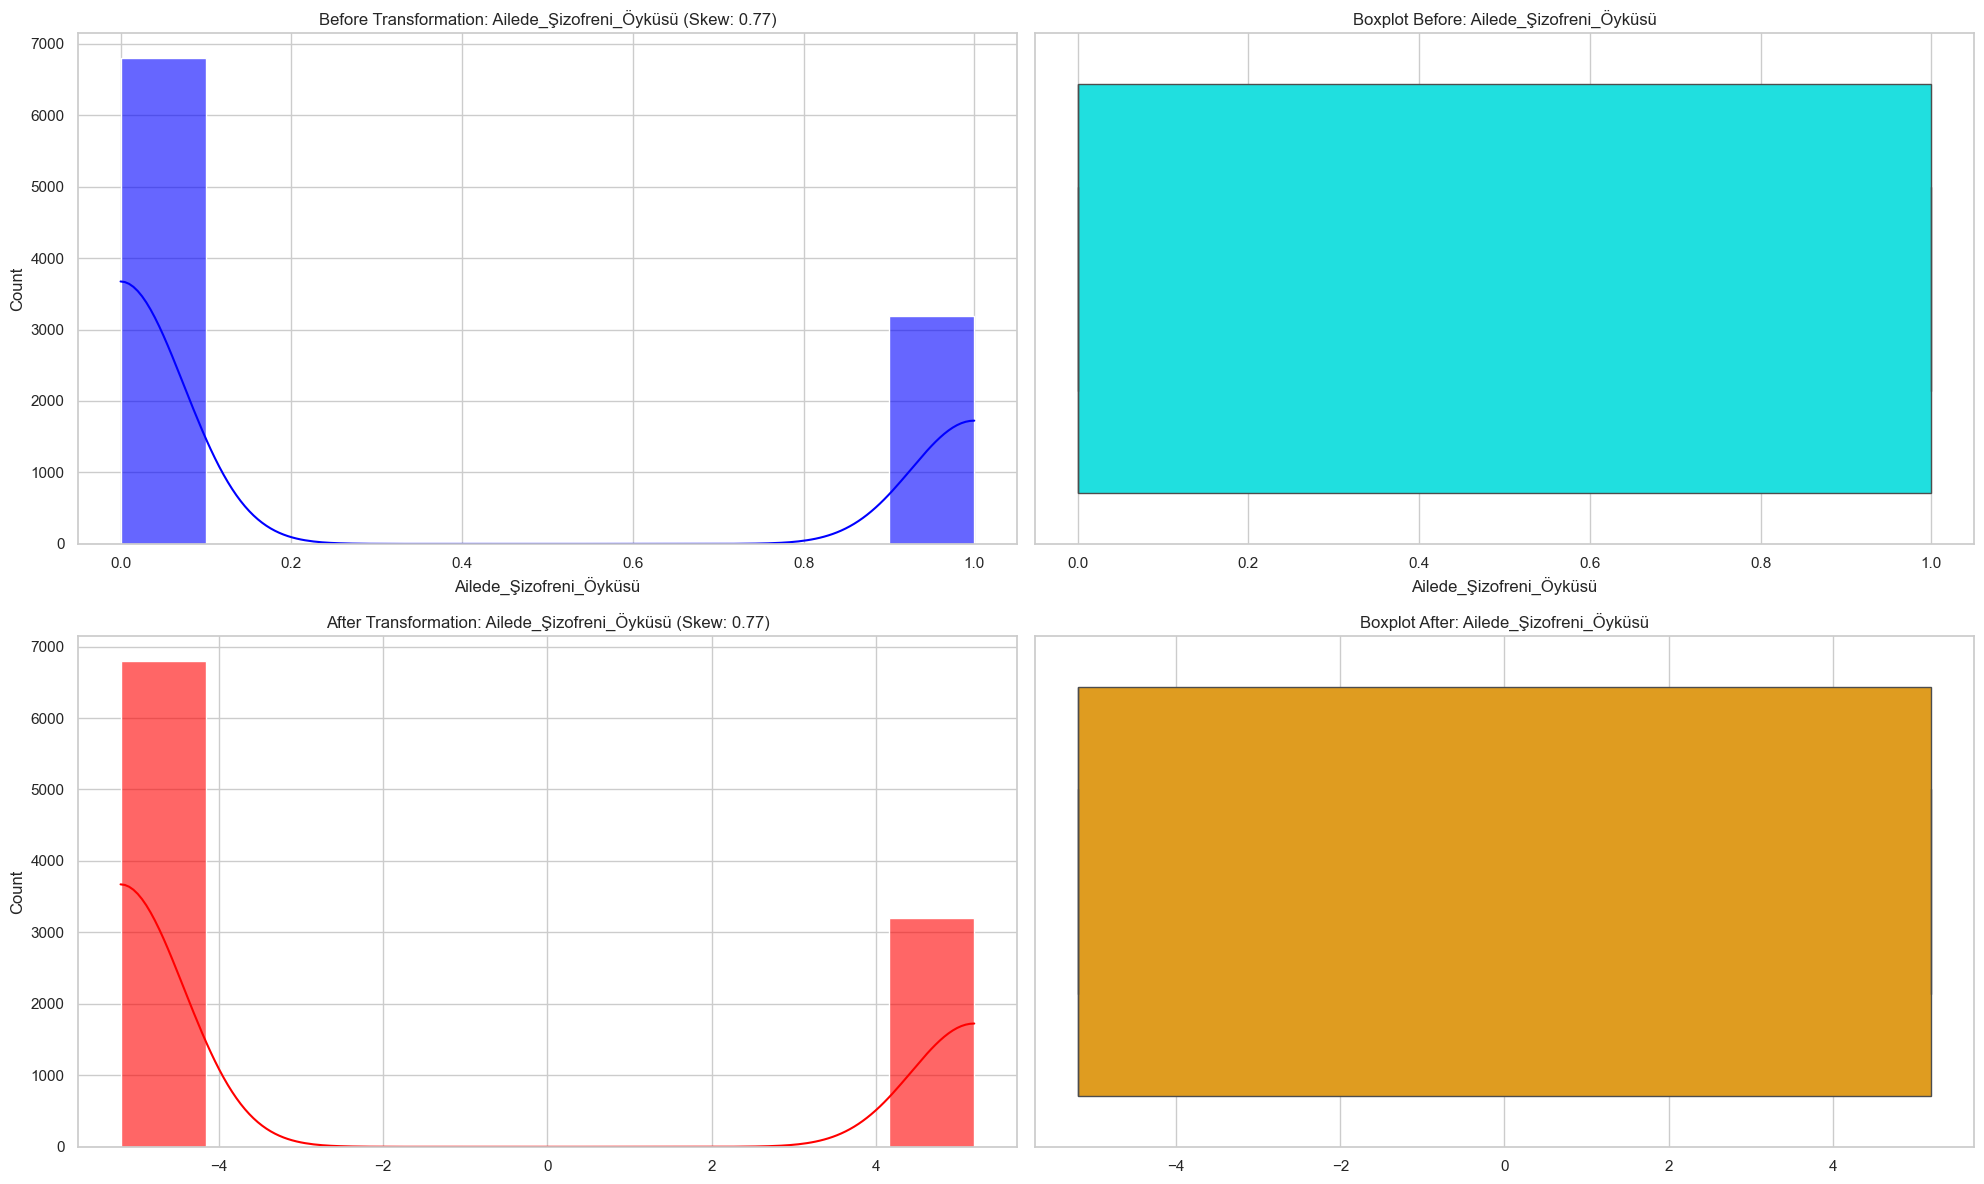

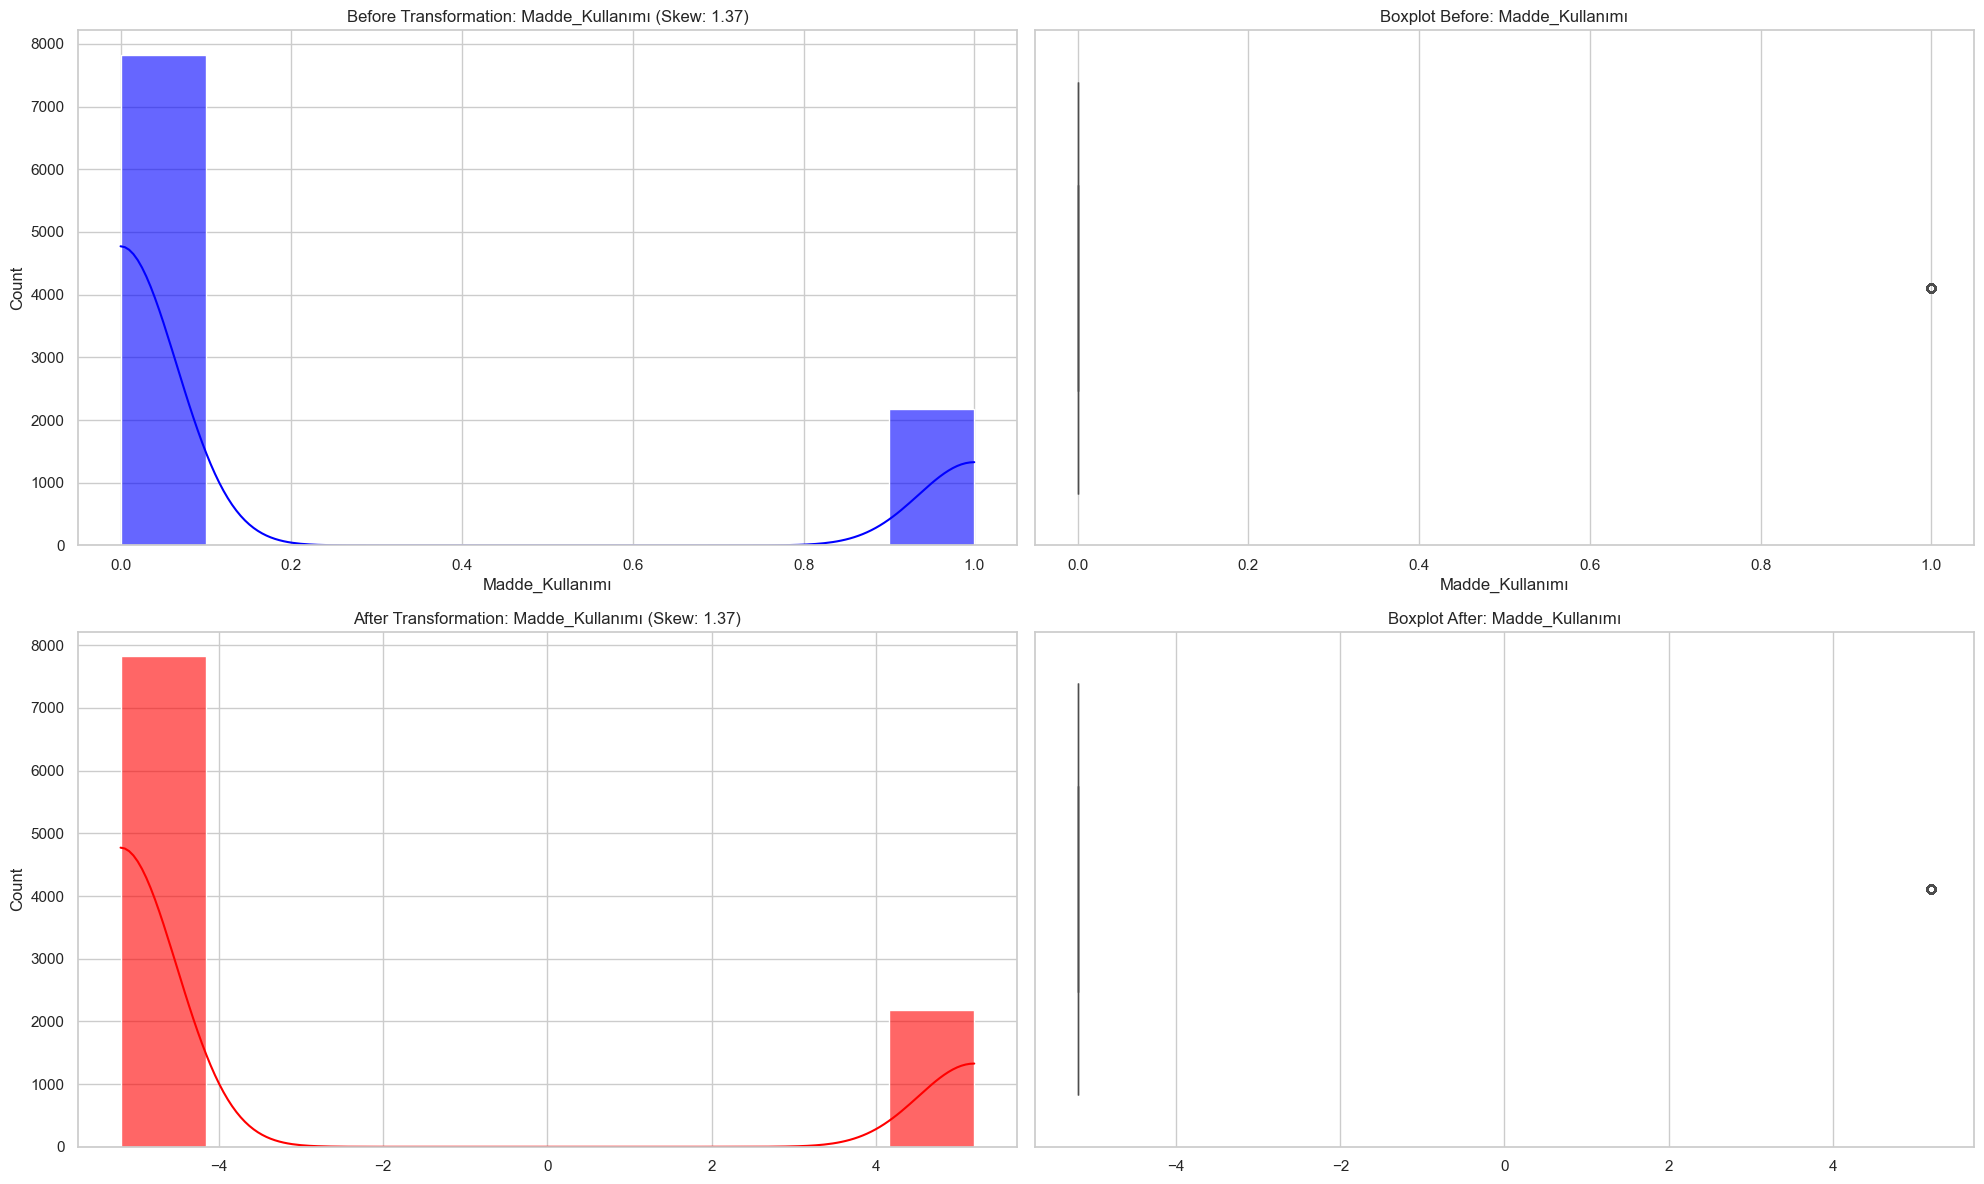

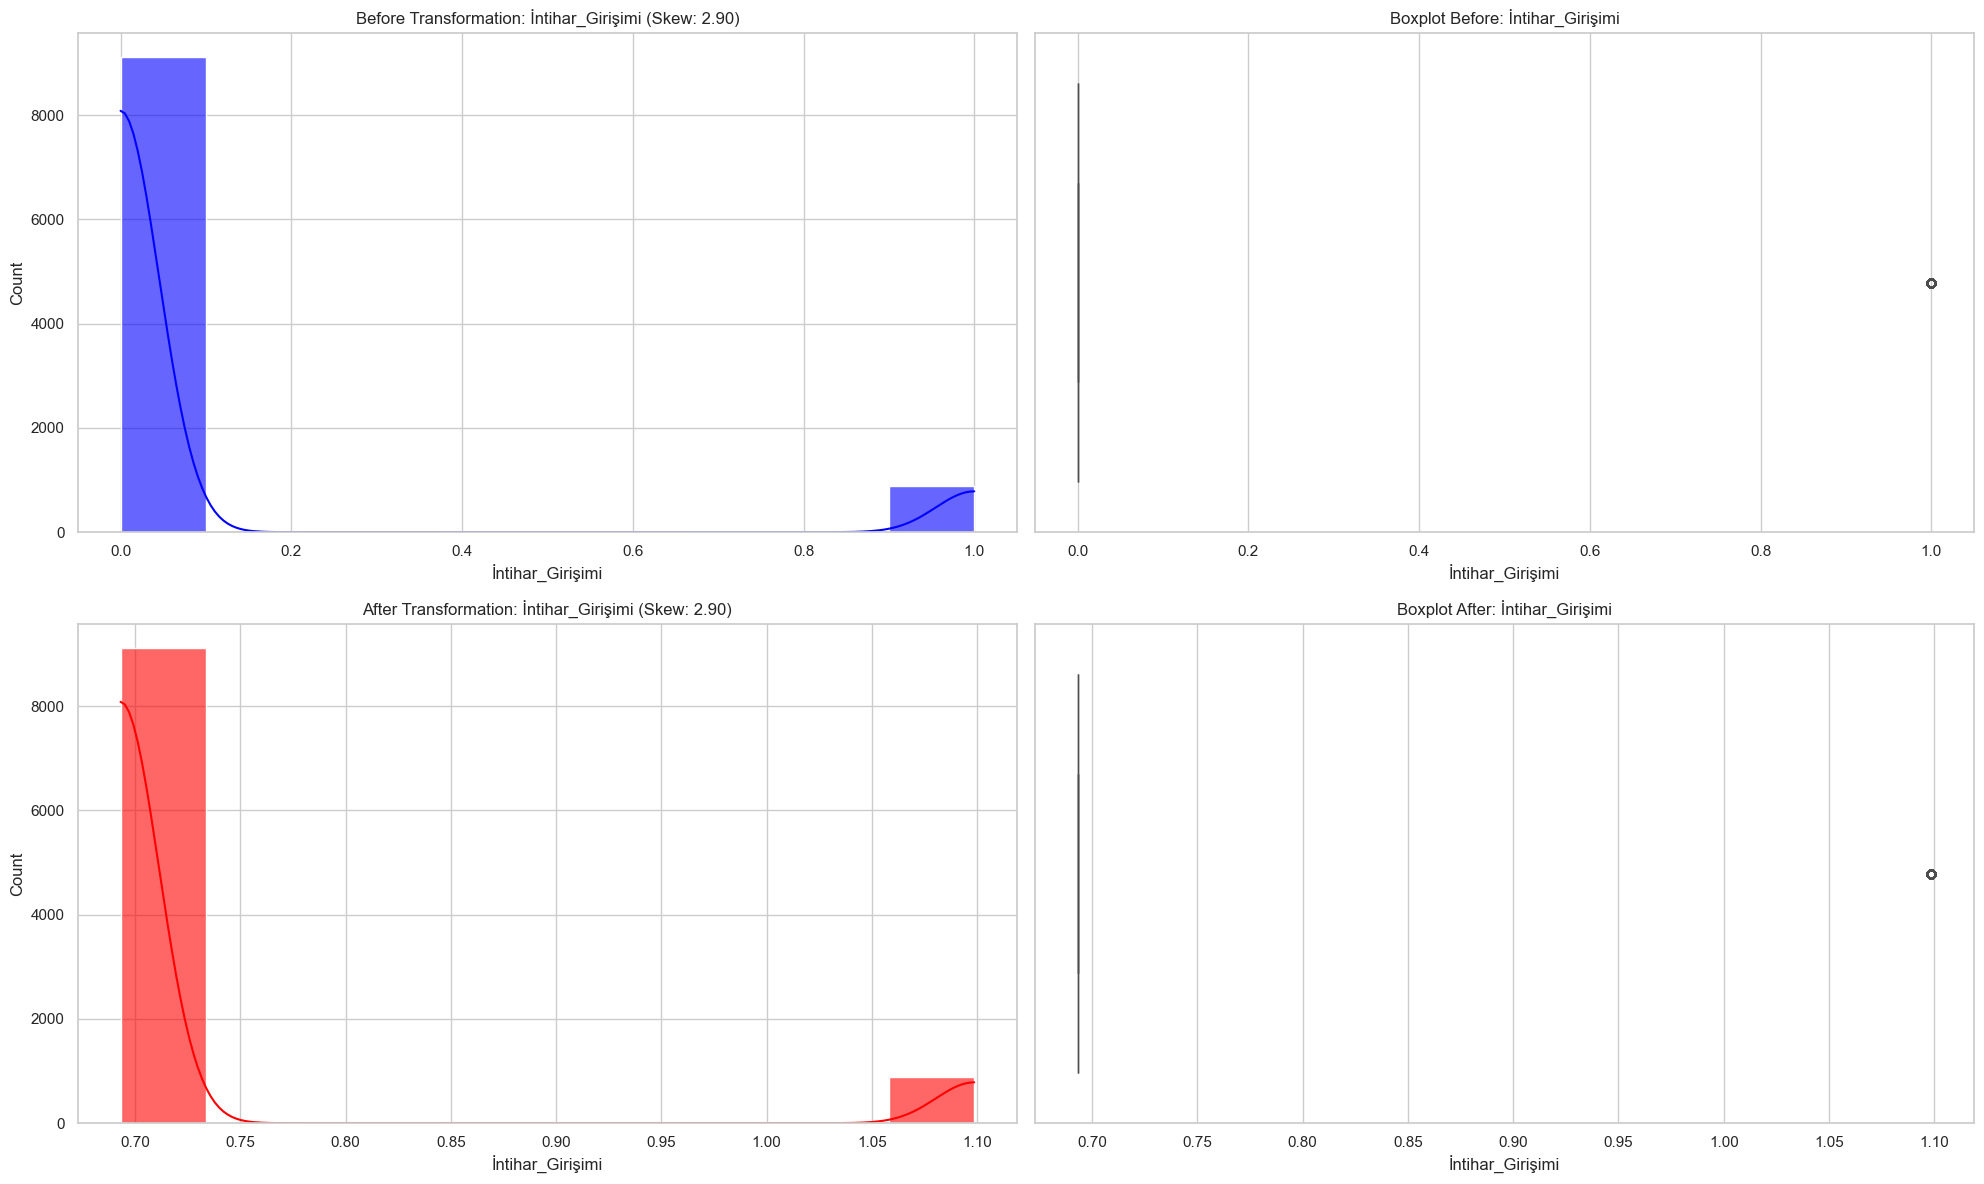

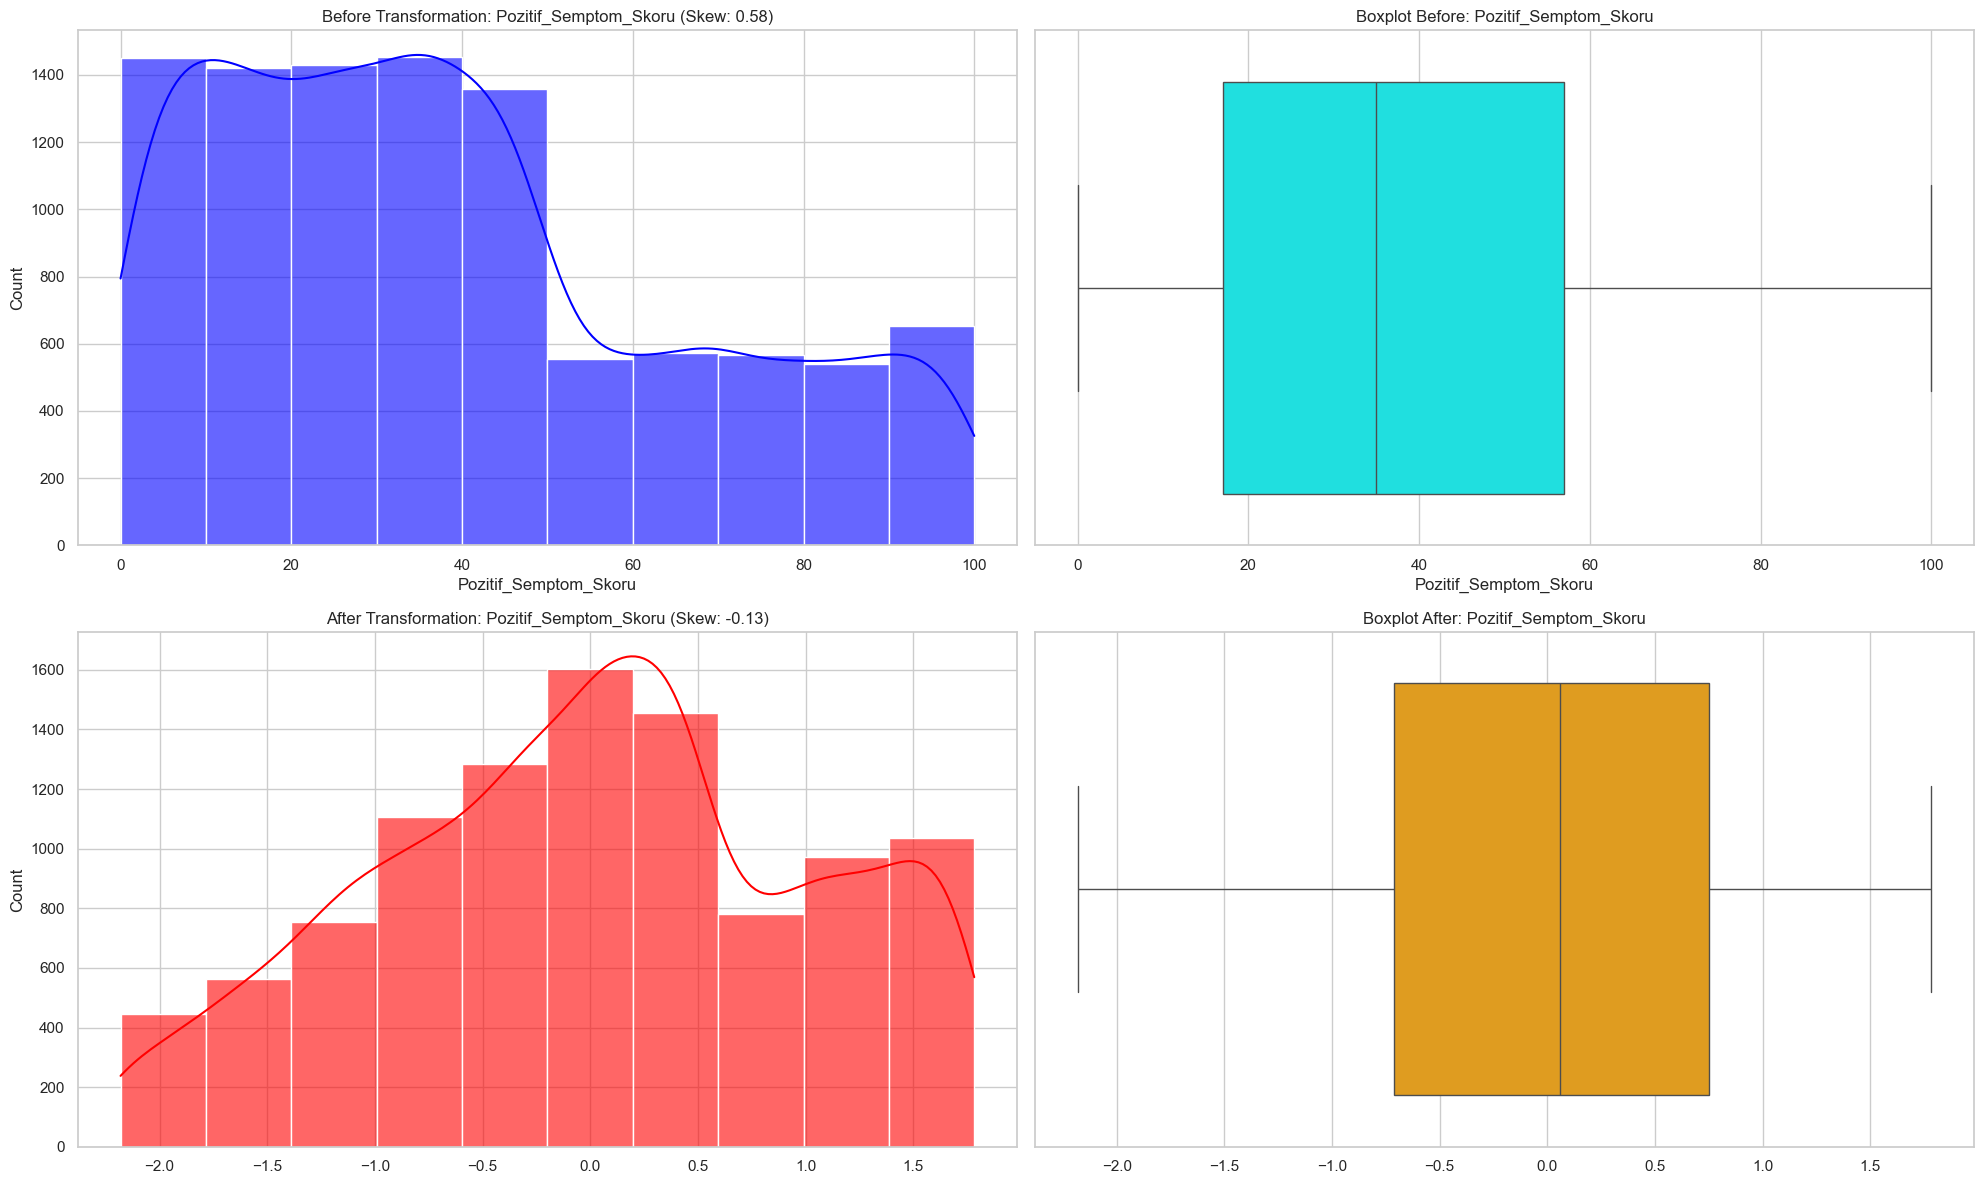

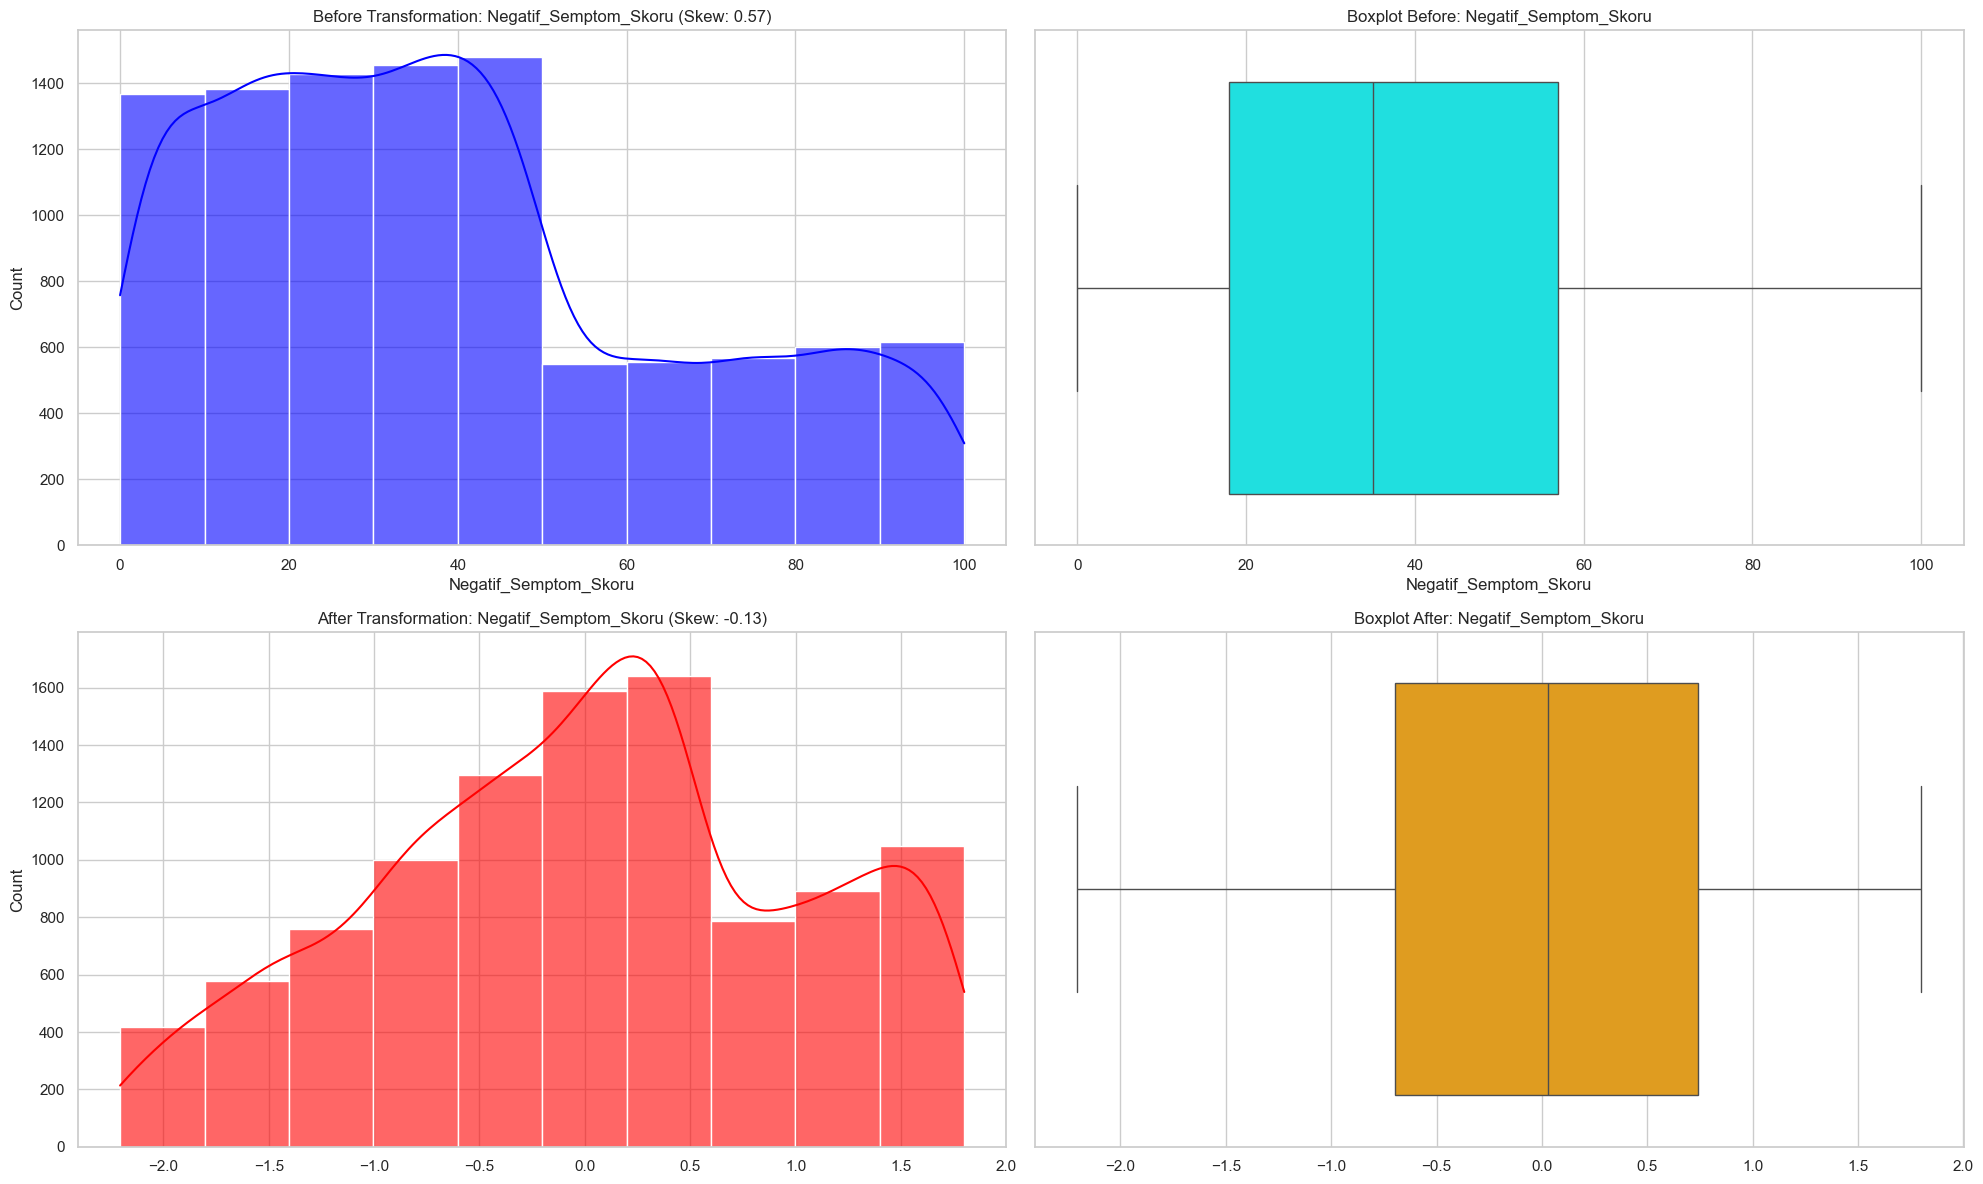

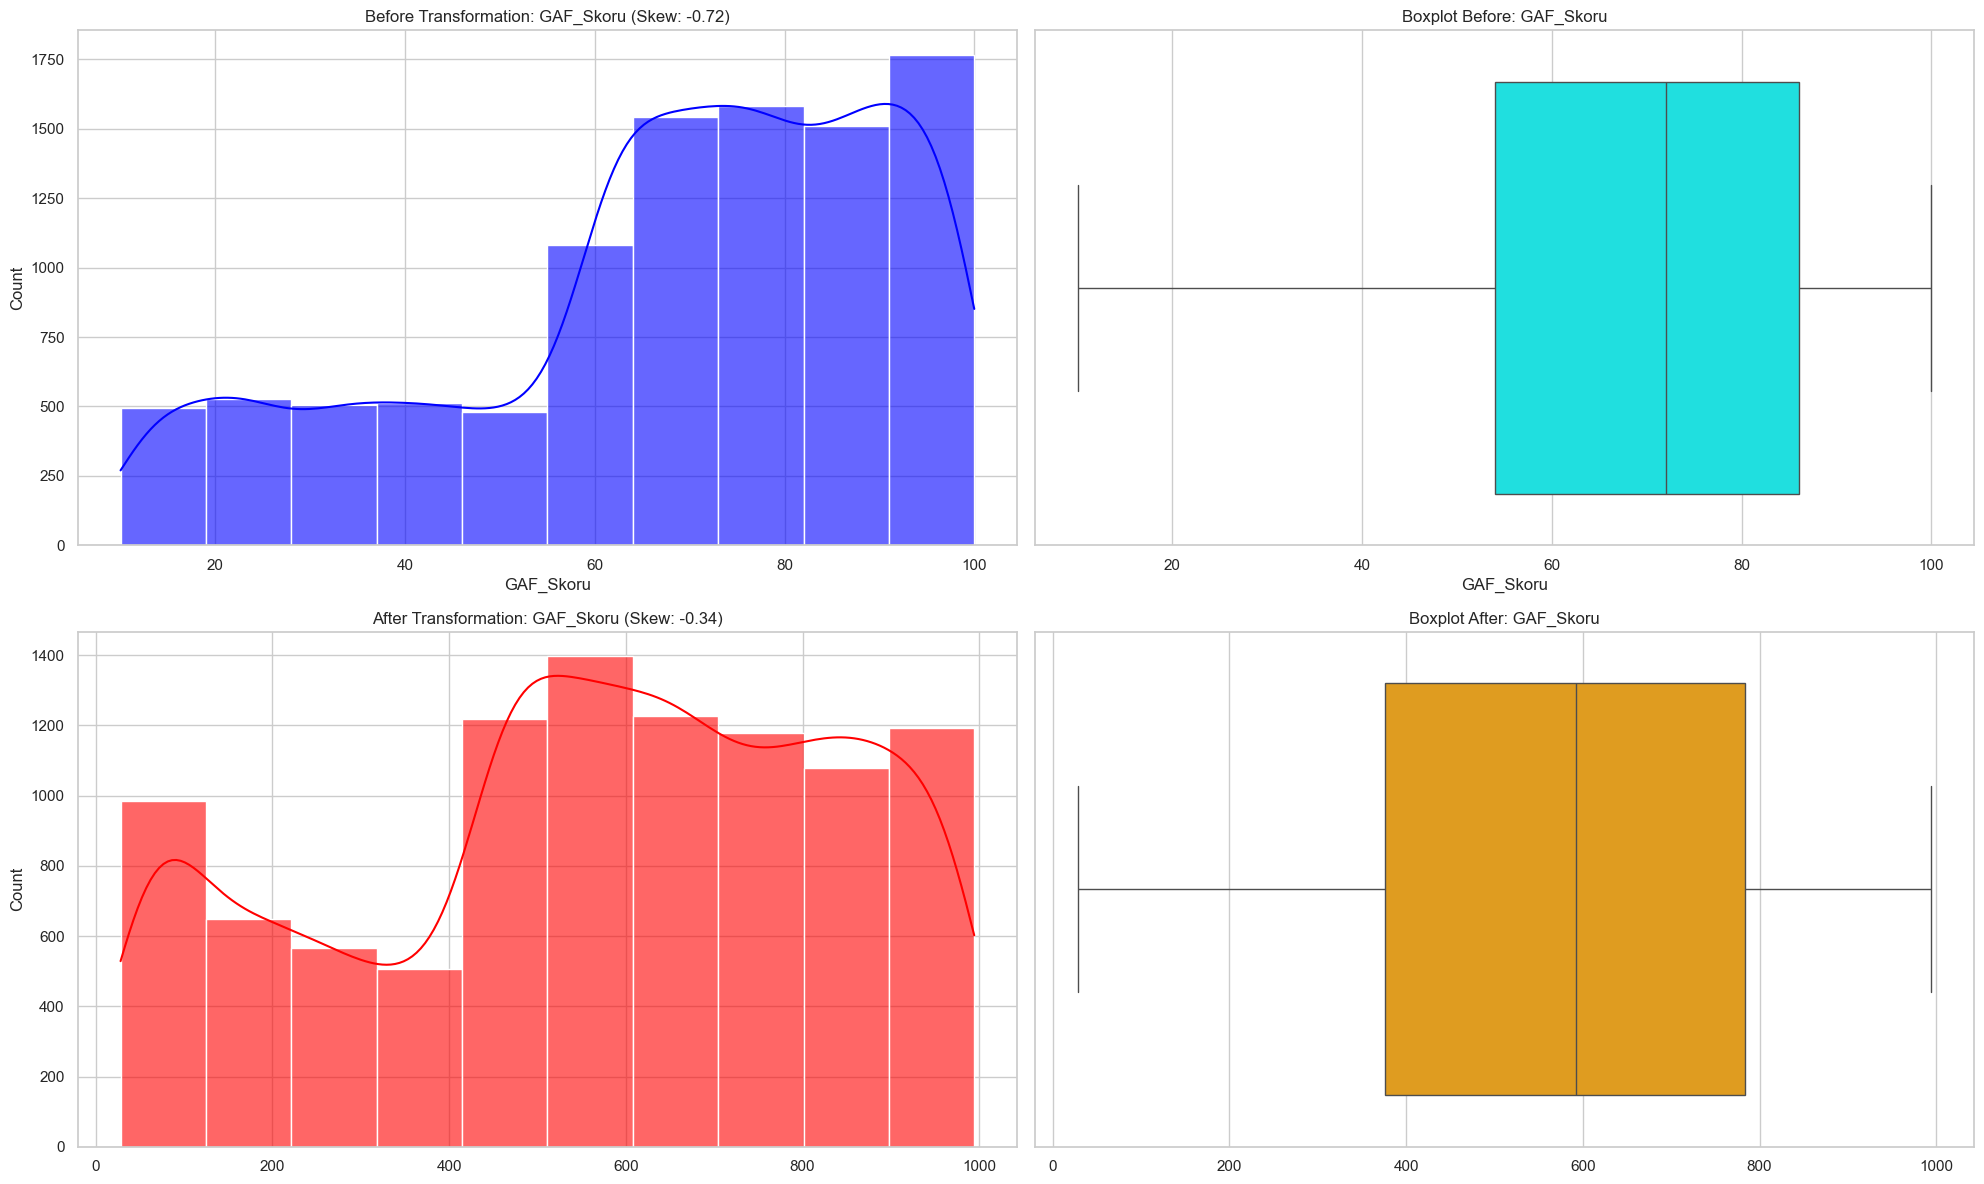

In [149]:
# Plot transformed distributions
for data in transformed_data:
    feature = data["feature"]
    skew_before = data["skew_before"]
    new_skew = data["skew_after"]

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 2 Rows, 2 Columns

    # Dynamically adjust bins based on range
    data_range = np.ptp(data["original"])  # Range of original data
    bin_count = max(10, min(100, int(data_range / (np.std(data["original"]) / 2))))  # Adjust bin size dynamically

    # Histogram Before Transformation
    sns.histplot(data["original"], bins=bin_count, kde=True, ax=axes[0, 0], color='blue', alpha=0.6)
    axes[0, 0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

    # Boxplot Before Transformation
    sns.boxplot(x=data["original"], ax=axes[0, 1], color='cyan')
    axes[0, 1].set_title(f'Boxplot Before: {feature}')

    # Dynamically adjust bins for transformed data
    transformed_range = np.ptp(data["transformed"])
    transformed_bin_count = max(10, min(100, int(transformed_range / (np.std(data["transformed"]) / 2))))

    # Histogram After Transformation
    sns.histplot(data["transformed"], bins=transformed_bin_count, kde=True, ax=axes[1, 0], color='red', alpha=0.6)
    axes[1, 0].set_title(f'After Transformation: {feature} (Skew: {new_skew:.2f})')

    # Boxplot After Transformation
    sns.boxplot(x=data["transformed"], ax=axes[1, 1], color='orange')
    axes[1, 1].set_title(f'Boxplot After: {feature}')

    plt.tight_layout()  # Adjust layout
    plt.show()


In this analysis, we applied transformations to **highly skewed numerical features** to improve their distribution. This skewness can negatively impact machine learning models, especially those that assume a normal distribution.
The transformations, such as **log transformation, Box-Cox, or Yeo-Johnson**, helped to reduce skewness, normalize feature distributions, and minimize the impact of extreme outliers. 

The boxplots before and after transformation show a decrease in extreme values, making the data more balanced. These adjustments improve the model’s **accuracy, interpretability, and robustness**, as we mentioned before, particularly for algorithms that rely on evenly distributed data.


#### Step 6: Apply TF-IDF

We will use now the **TF-IDF transformation** function on categorical text columns to improve feature representation. To ensure this, we first check for textual data in the dataset.

In [150]:
# Detect all text columns dynamically, excluding the target column
text_columns = [col for col in df.select_dtypes(include=['object', 'string']).columns if col != target_column]

if text_columns:
    print(f"\nDetected text columns for TF-IDF transformation: {text_columns}")
else:
    print("\nNo text columns detected. Skipping TF-IDF transformation.")

# Convert text columns to string type
for col in text_columns:
    df[col] = df[col].astype(str)

# Apply TF-IDF transformation only on detected text columns
for col in text_columns:
    df = apply_tfidf(df, col)


No text columns detected. Skipping TF-IDF transformation.


Since no text columns were detected, we skip this step and proceed with other transformations.

#### Step 5: Apply SMOTE and Under-sampling 
To address class imbalance, we apply **SMOTE** to generate synthetic samples for the minority class and **under-sampling** to reduce the majority class size. These techniques help create a more balanced dataset, improving model performance and reducing bias.


In [151]:
# Extract features (X) and target (y)
X = df[numerical_features]
y = df[target_column]

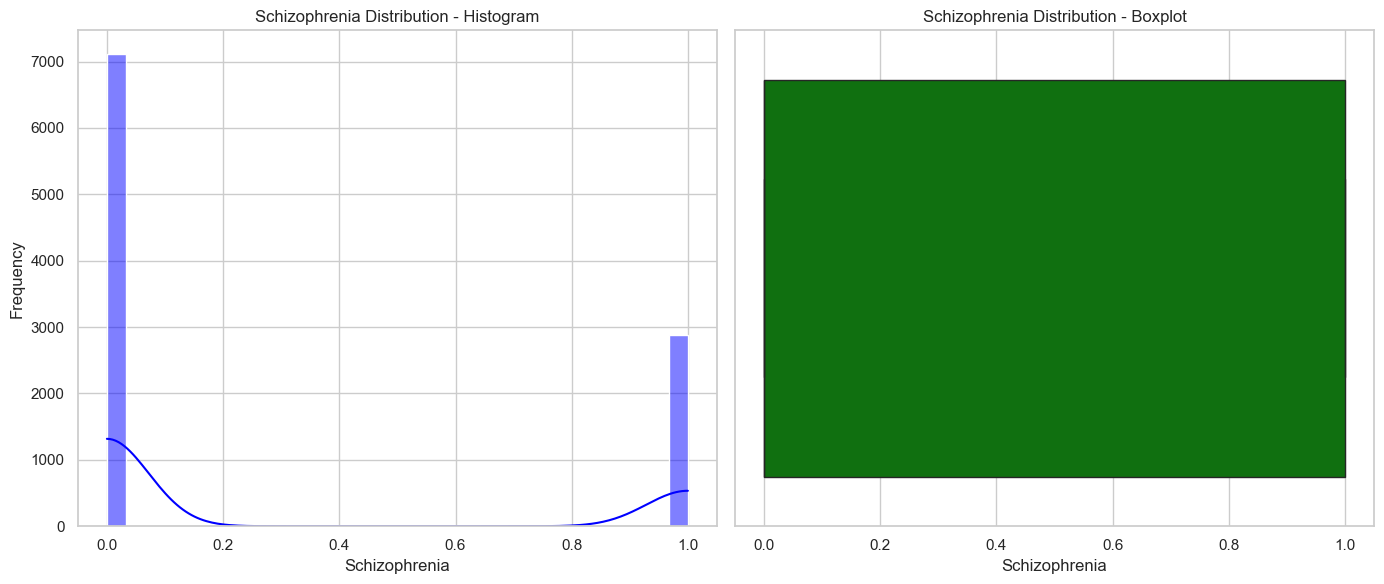

In [152]:
# Set the style
sns.set(style='whitegrid')

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
sns.histplot(df[target_column], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Schizophrenia Distribution - Histogram')
axes[0].set_xlabel('Schizophrenia')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df[target_column], ax=axes[1], color='green')
axes[1].set_title('Schizophrenia Distribution - Boxplot')
axes[1].set_xlabel('Schizophrenia')

# Display the plots
plt.tight_layout()
plt.show()


The histogram and boxplot illustrate the distribution of the Schizophrenia target variable.

- The **histogram** shows a highly **imbalanced dataset**, where most samples belong to one class (0 - no schizophrenia), with significantly fewer instances in the minority class (1 - schizophrenia).
- The **boxplot** further confirms this imbalance, as it represents a binary classification with only two distinct values (0 and 1).

In [153]:
# Apply SMOTE to balance classes
X_smote, y_smote = apply_smote(X, df[target_column])


Class Distribution Before SMOTE: Counter({0: 7113, 1: 2887})
Imbalance Ratio: 2.46
Mild imbalance detected. Using ADASYN for adaptive sampling.


In [154]:
# Apply undersampling if necessary
X_balanced, y_balanced = apply_undersampling(X_smote, y_smote)


Class Distribution Before Undersampling: Counter({1: 7136, 0: 7113})
Imbalance Ratio: 1.00
Mild imbalance detected. Applying light undersampling (max_ratio = 2.0)

Class Distribution After Dynamic Undersampling: Counter({1: 7136, 0: 7113})


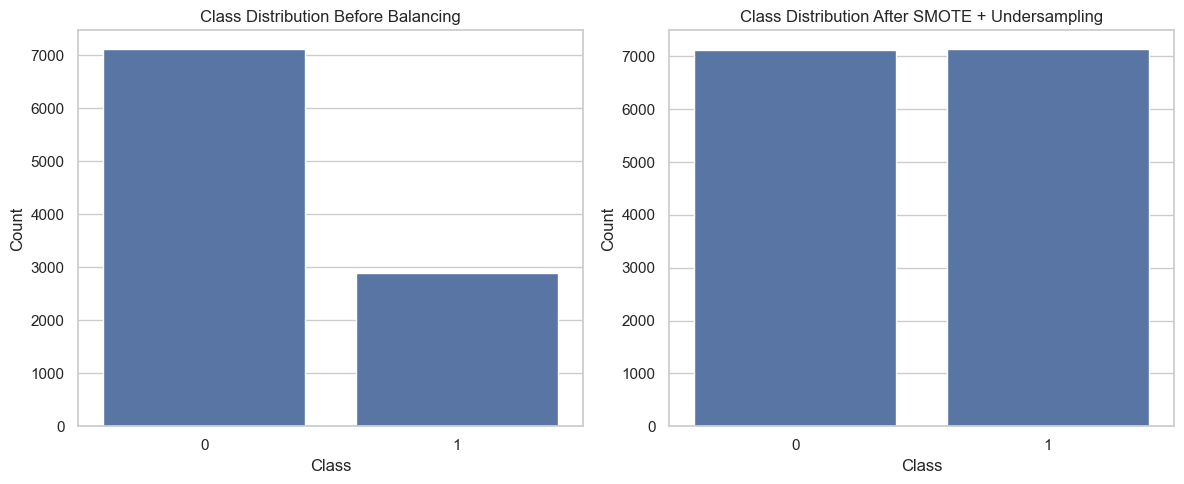

In [155]:
# Plot class distribution before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_balanced, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE + Undersampling")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

The bar charts illustrate the **effect of applying SMOTE and undersampling** to balance the dataset:

- Left (Before Balancing): The dataset was highly imbalanced, with significantly more samples in class 0 than in class 1. This imbalance could lead to biased model predictions.
- Right (After Balancing): After applying SMOTE (oversampling the minority class) and undersampling the majority class, the dataset is now balanced, ensuring the model can learn from both classes equally.


This final step improves **model performance, fairness, and generalization**, reducing bias toward the majority class. The pipeline is now ready for **training and evaluation** on a balanced dataset.

### 6.2. Dry Bean Dataset
The **Dry Bean Dataset** contains morphological features of different bean types, which will be used for **classification tasks**.
#### Step 1: Load the Dataset
Since `Dry_Bean_Dataset.csv` differs from other datasets used, we need to load it carefully while ensuring:
- **The target column is correctly identified** (in this case -`"Class"`).
- **All numerical features are extracted properly** for analysis and preprocessing..
- link: https://www.kaggle.com/datasets/muratkokludataset/dry-bean-dataset

In [156]:
# Load the new dataset
target_column = 'Class'
df, numerical_features = load_data("Dry_Bean_Dataset.csv",target_column)


Dataset Shape: (13611, 17)

Sample Rows:


Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272751  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER  
1     0.953861      0.006979      0.003564      0.909851      0.998430  SEKER  
2     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER  
3     0.928329      0.007017      0.003215      0.861794      0.994199  SEKER  
4     0.970516      0.006697      0.003665      0.941900      0.999166  SEKER

### **Step 2: Detect Skewed Features**
As we can see the dataset contains numerical features. We check for **highly skewed features** using the function we created earlier.

In [157]:
# Detect skewed numerical features
skewed_features, skewness_table = detect_skewed_features(df, numerical_features)

# Display the skewness table
display(skewness_table)

Detecting skewed features...
Skewed Features (>|0.5|): ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'ShapeFactor1', 'ShapeFactor4']


Feature  Skewness
Area                        Area  2.952931
ConvexArea            ConvexArea  2.941821
MinorAxisLength  MinorAxisLength  2.238211
EquivDiameter      EquivDiameter  1.948958
Perimeter              Perimeter  1.626124
MajorAxisLength  MajorAxisLength  1.357815
AspectRation        AspectRation  0.582573
ShapeFactor2        ShapeFactor2  0.301226
ShapeFactor3        ShapeFactor3  0.242481
Compactness          Compactness  0.037115
ShapeFactor1        ShapeFactor1 -0.534141
roundness              roundness -0.635749
Extent                    Extent -0.895348
Eccentricity        Eccentricity -1.062824
Solidity                Solidity -2.550093
ShapeFactor4        ShapeFactor4 -2.759483

In [158]:
# Transform and store skewed features
transformed_data, results_df = transform_and_store_skewed_features(df, skewed_features)
print(results_df)

            Feature  Skewness Before  Skewness After    Method
0              Area         2.952931       -0.025247  quantile
1         Perimeter         1.626124       -0.013071  quantile
2   MajorAxisLength         1.357815       -0.014171  quantile
3   MinorAxisLength         2.238211       -0.000241  quantile
4      AspectRation         0.582573        0.001633  quantile
5      Eccentricity        -1.062824        0.002484  quantile
6        ConvexArea         2.941821       -0.026471  quantile
7     EquivDiameter         1.948958       -0.025098  quantile
8            Extent        -0.895348       -0.020676  quantile
9          Solidity        -2.550093        0.011874  quantile
10        roundness        -0.635749        0.005854  quantile
11     ShapeFactor1        -0.534141        0.007721  quantile
12     ShapeFactor4        -2.759483       -0.000000    boxcox


C:\Users\noidv\PycharmProjects\.venv\Lib\site-packages\pandas\core\nanops.py:1272: RuntimeWarning: overflow encountered in scalar power
  result = (count * (count - 1) ** 0.5 / (count - 2)) * (m3 / m2**1.5)
C:\Users\noidv\PycharmProjects\.venv\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noidv\PycharmProjects\.venv\Lib\site-packages\pandas\core\nanops.py:1272: RuntimeWarning: overflow encountered in scalar power
  result = (count * (count - 1) ** 0.5 / (count - 2)) * (m3 / m2**1.5)


The table displays the results of **skewness correction** applied to numerical features. Before transformation, several features exhibited **high skewness**, which could negatively impact model performance.

Transformation Methods Used:
- Most features were transformed using the **Quantile transformation**, effectively reducing skewness to near zero.
- The **Box-Cox** transformation was applied to ShapeFactor4, making it more normally distributed.

After transformation, the skewness values are significantly reduced, ensuring a **more balanced and normalized dataset**, which helps improve model stability and performance.

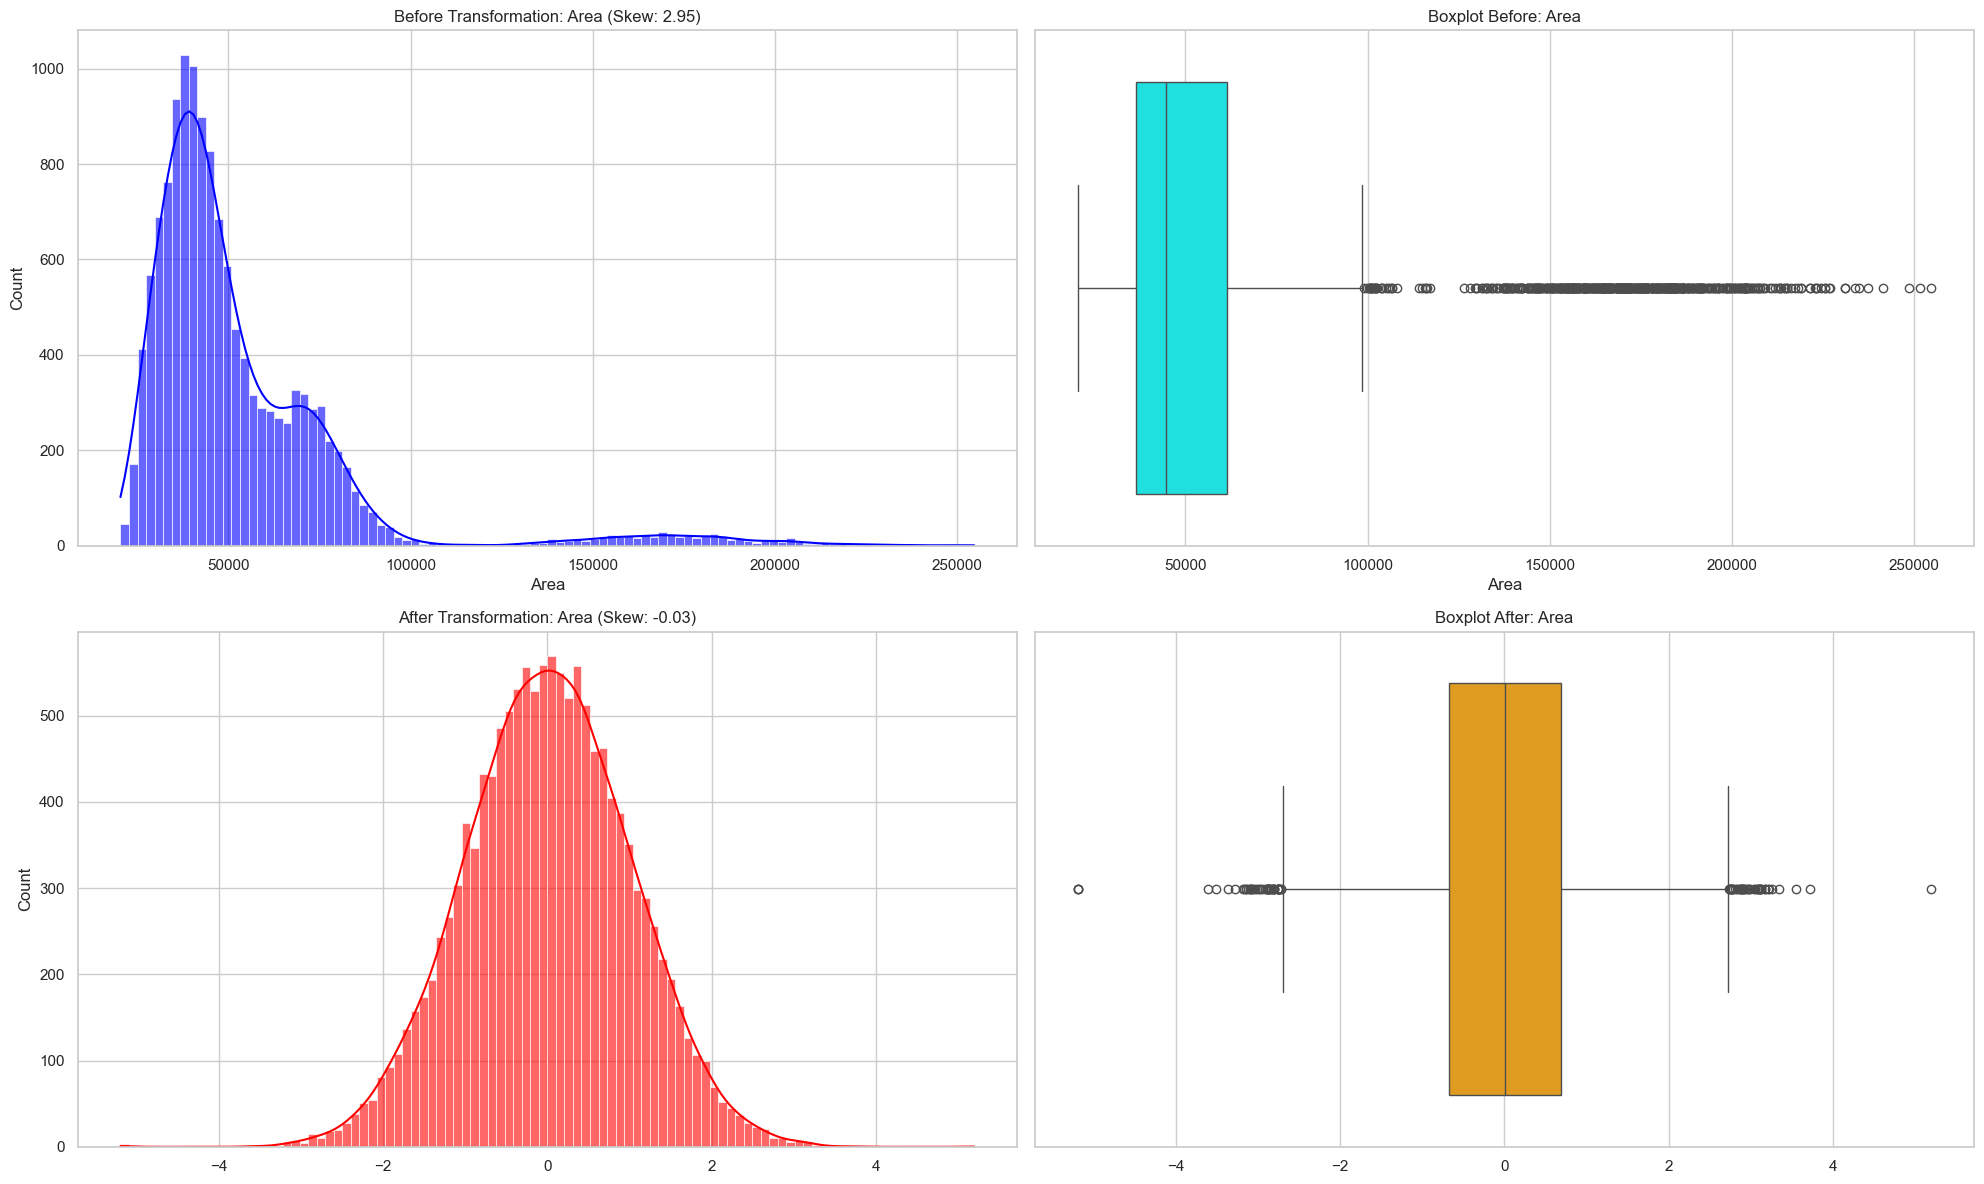

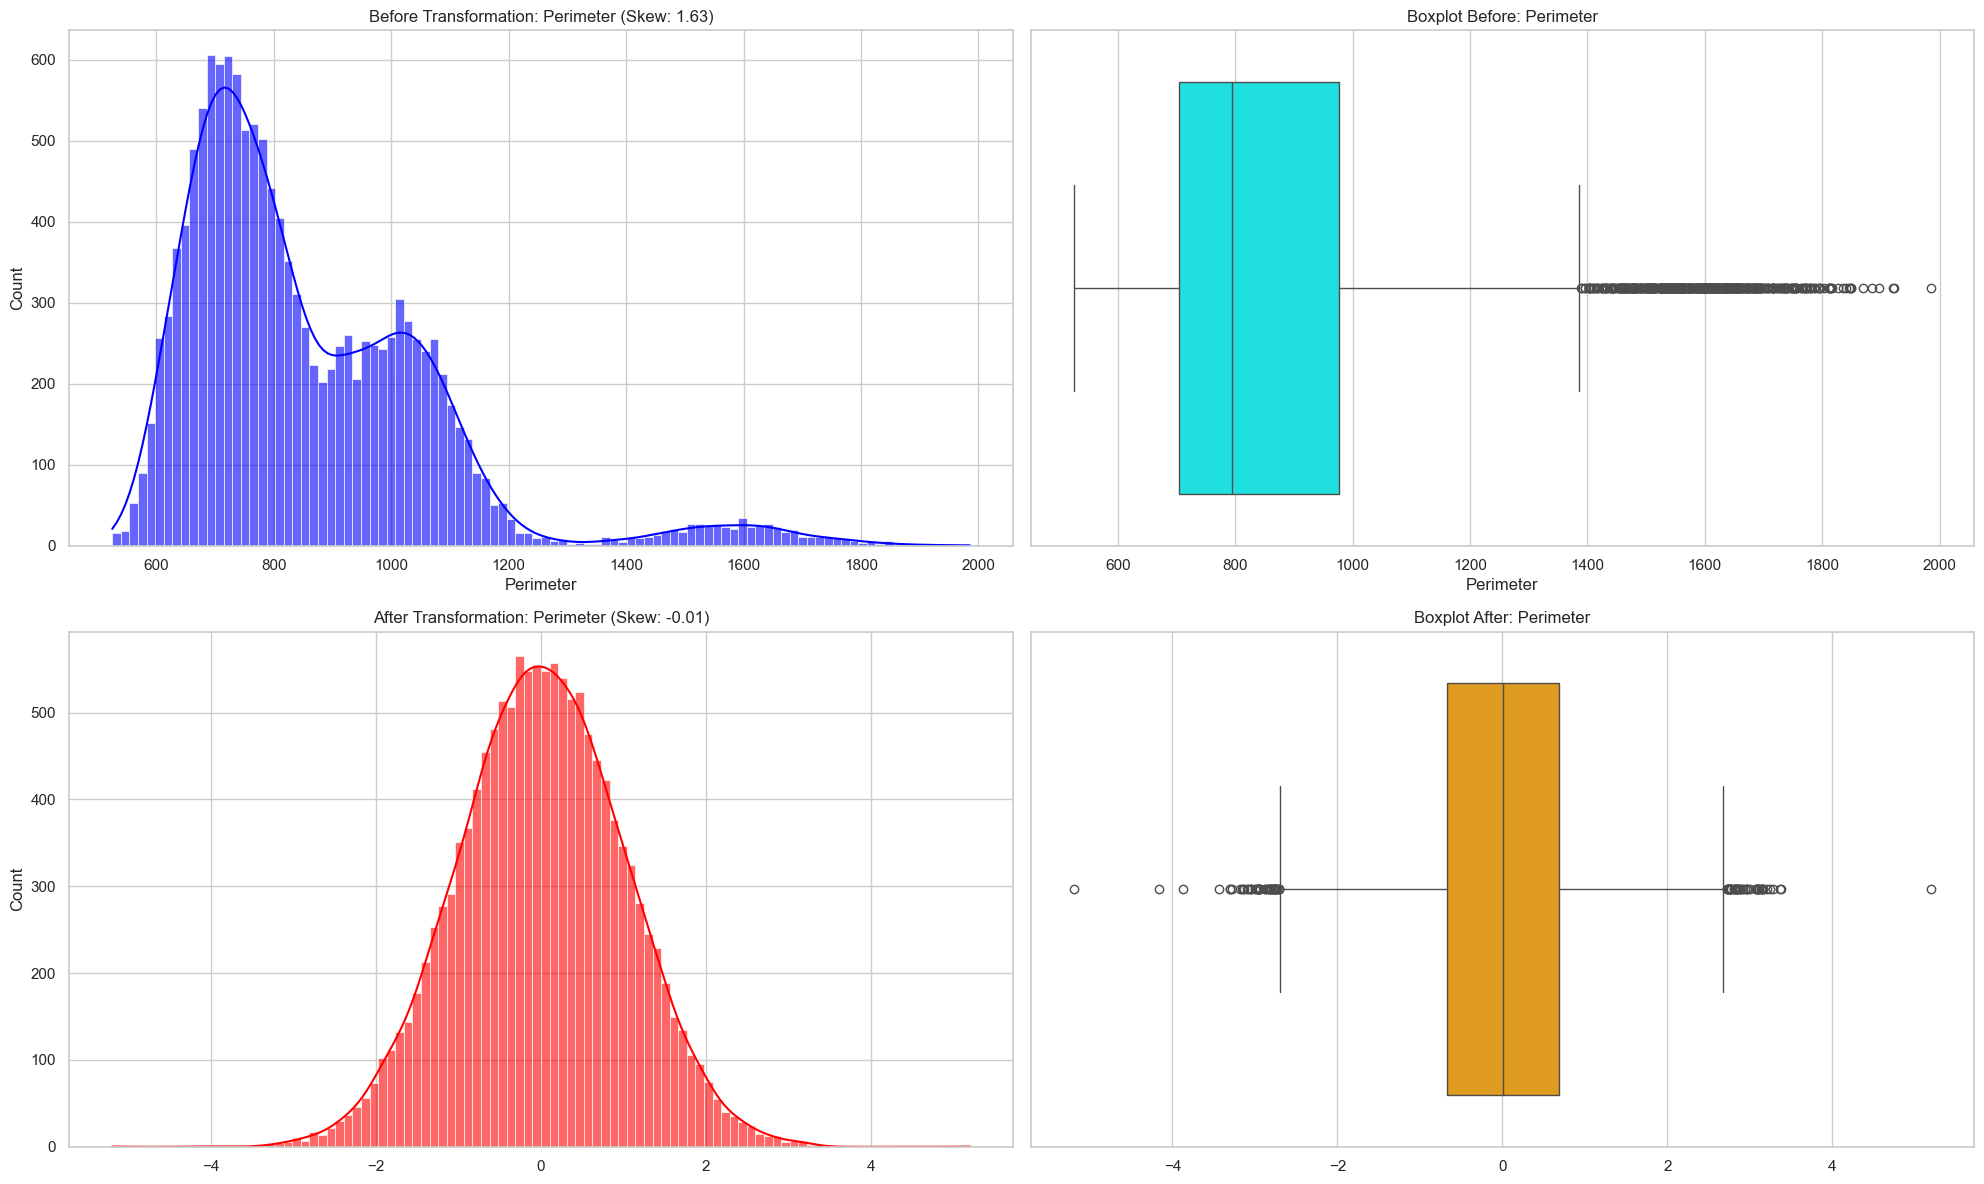

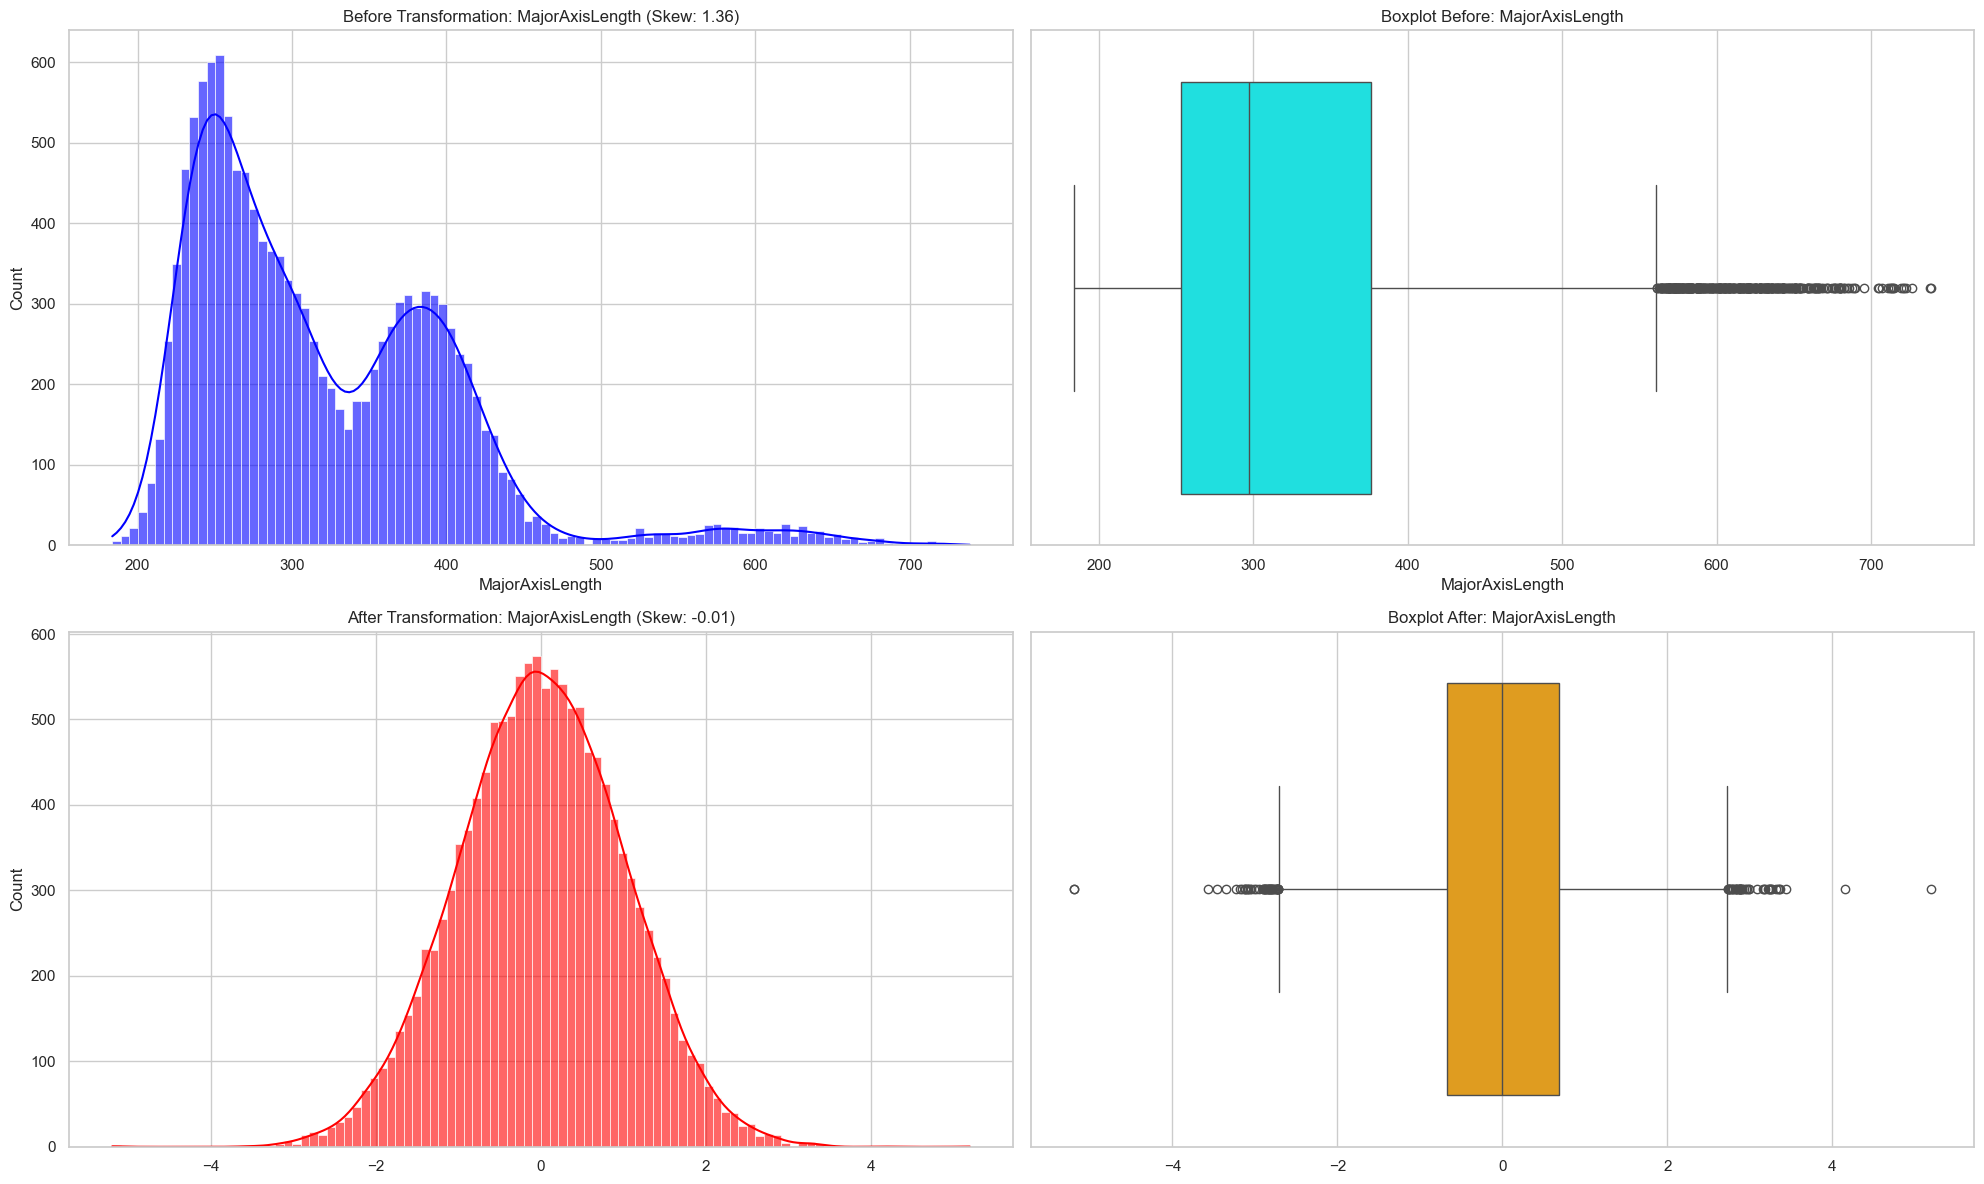

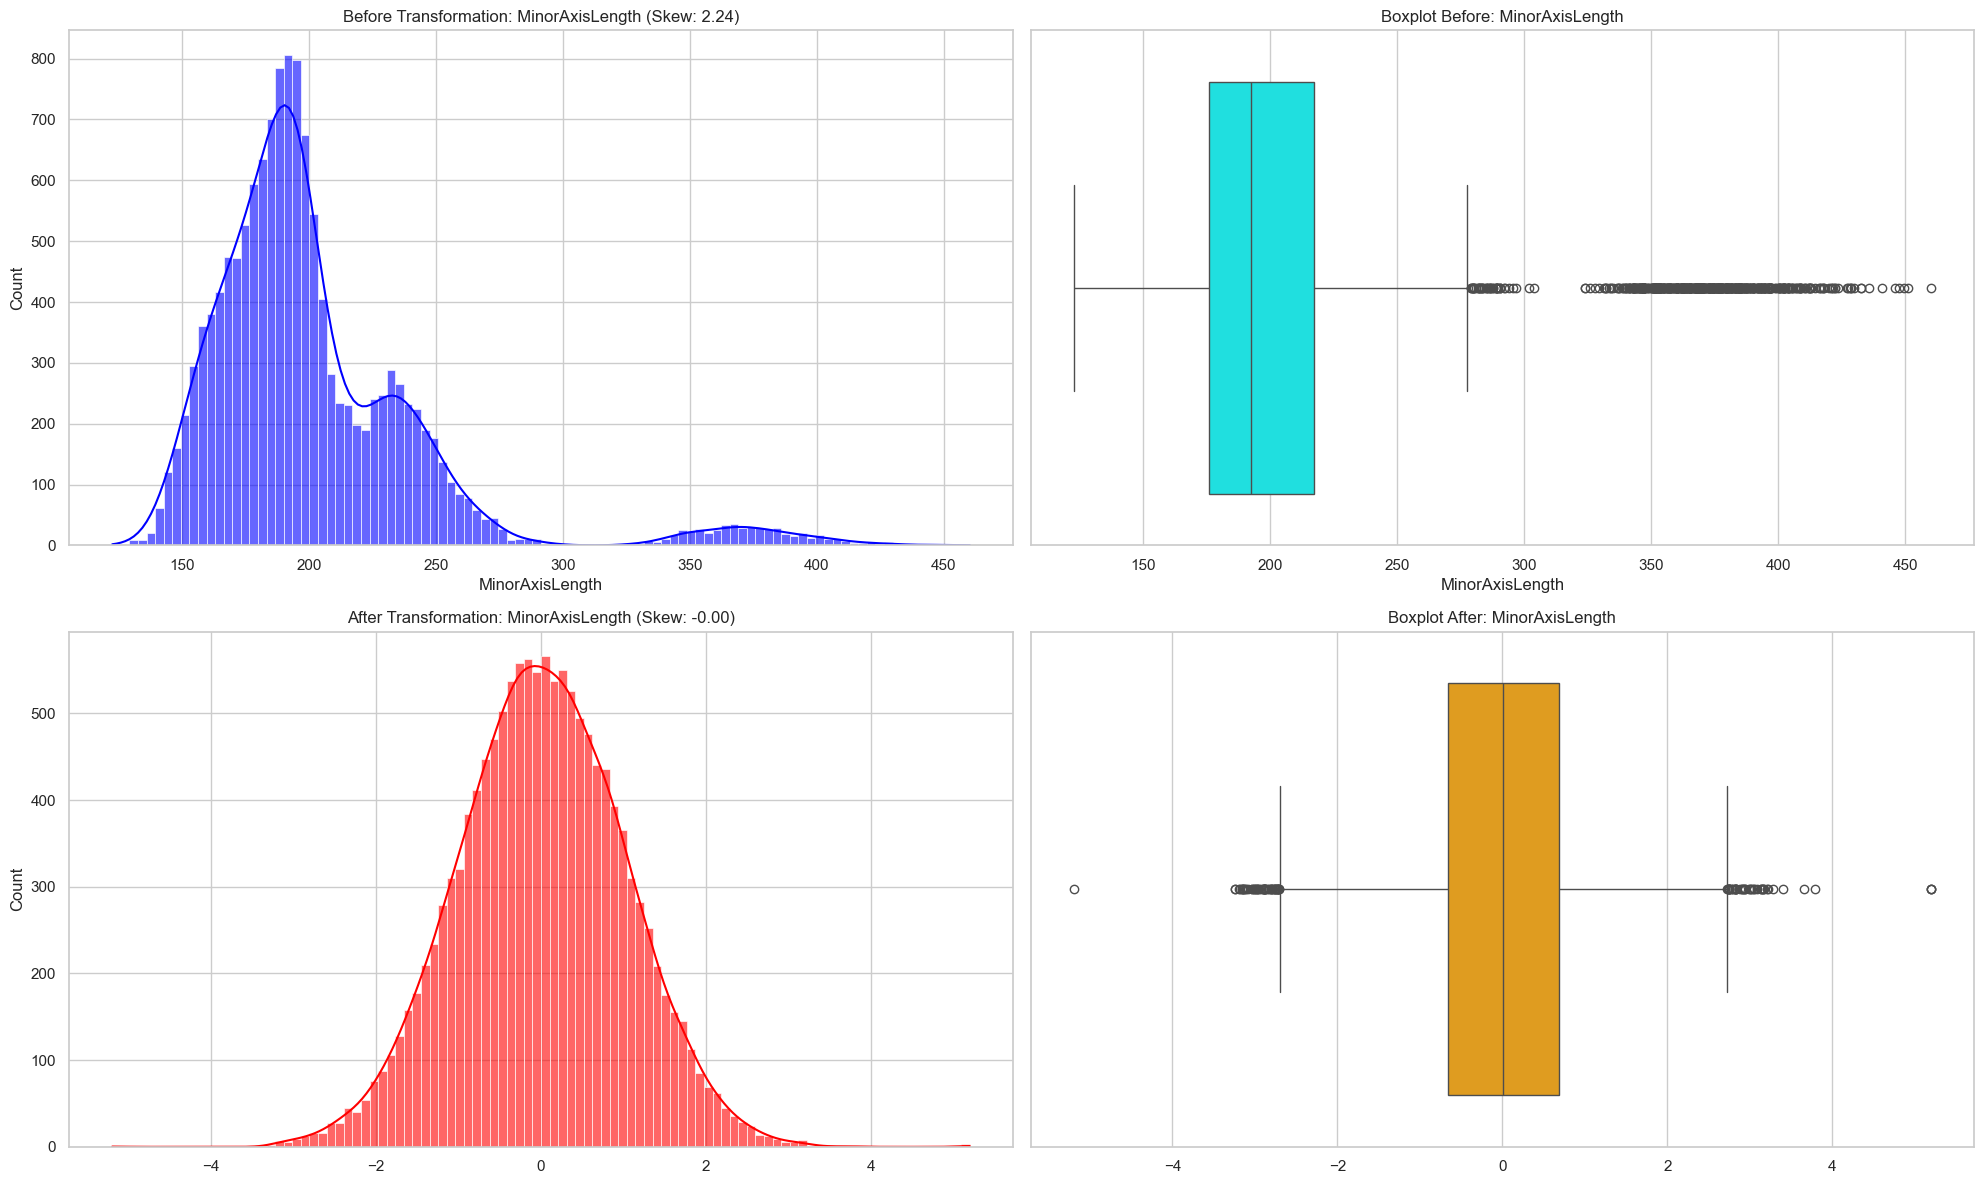

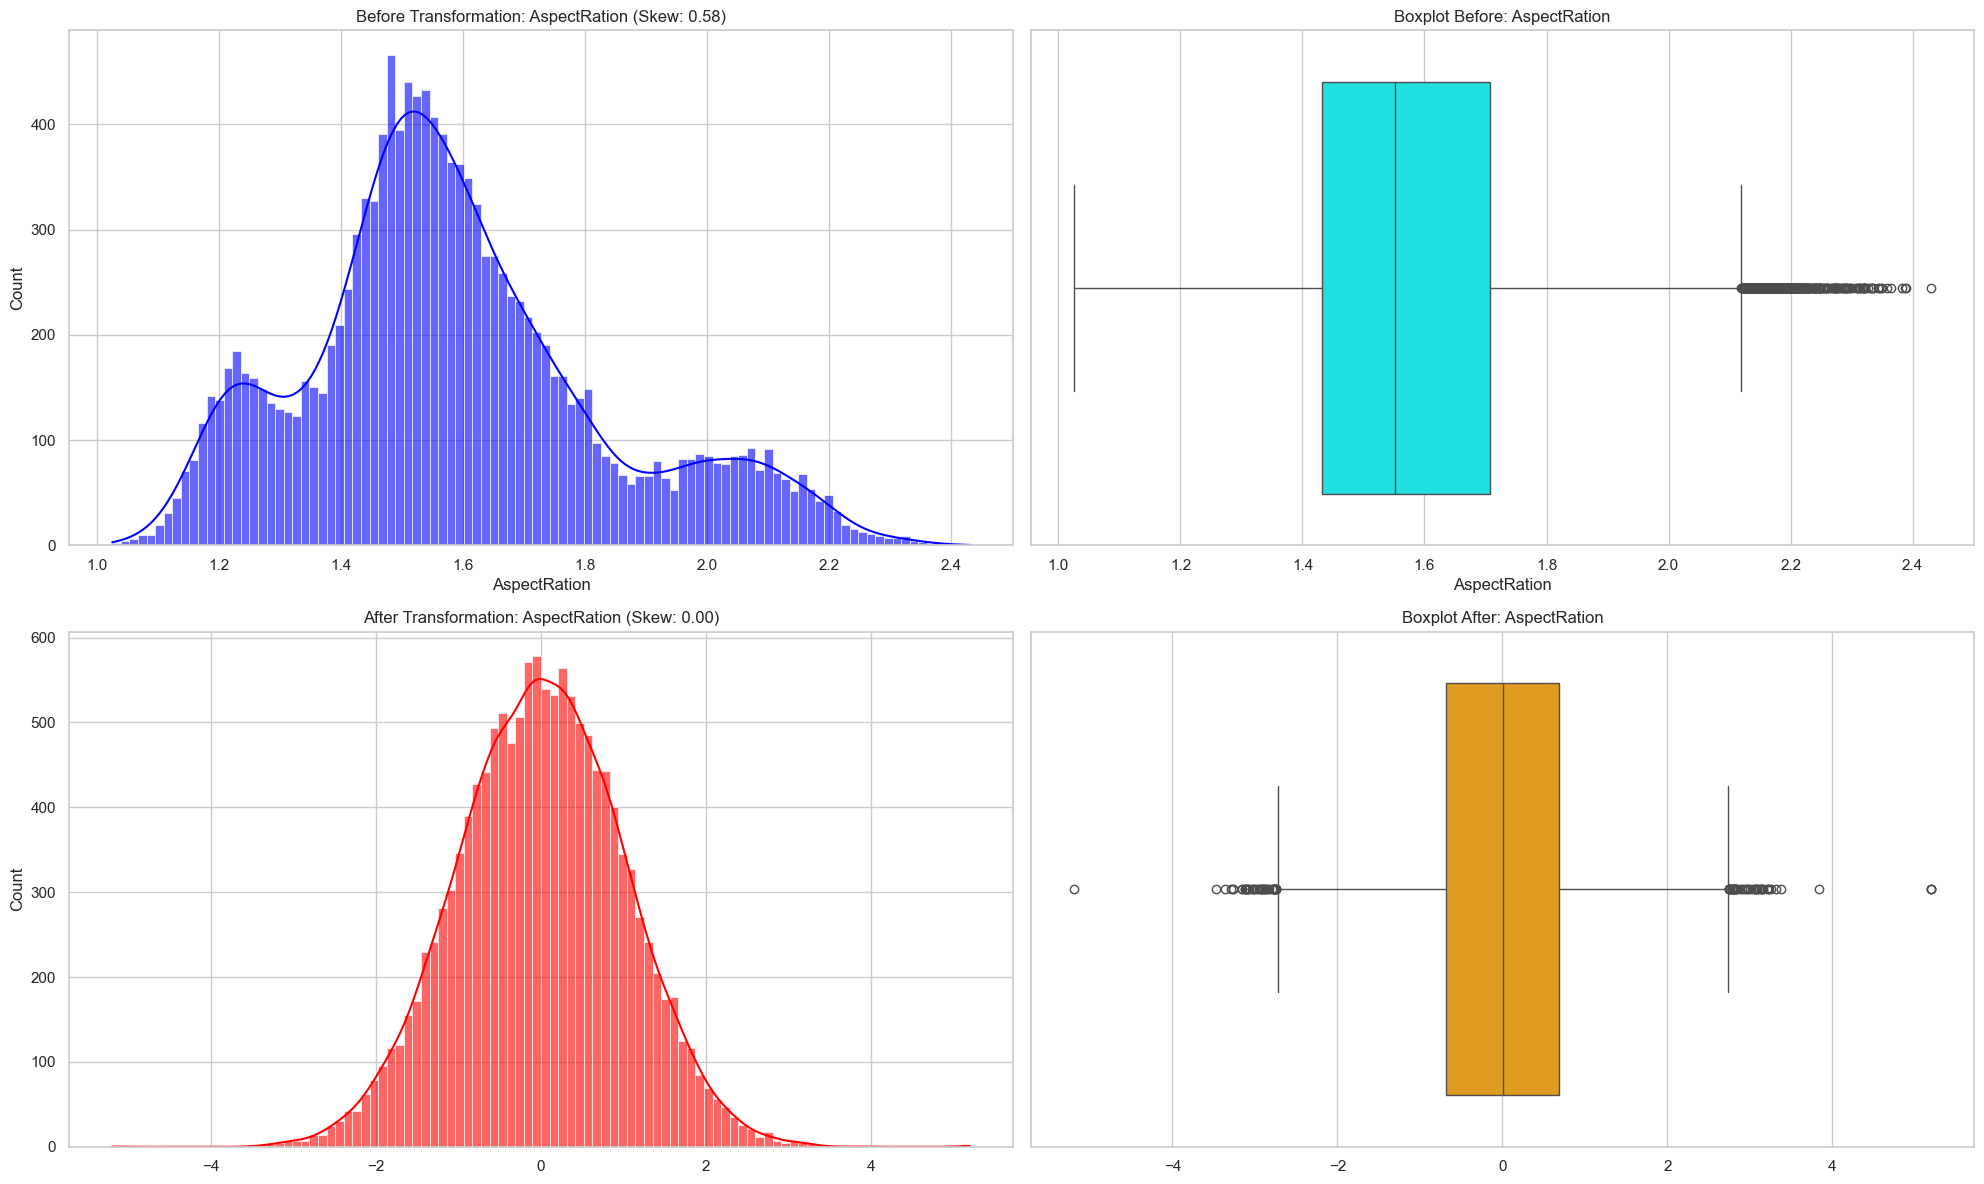

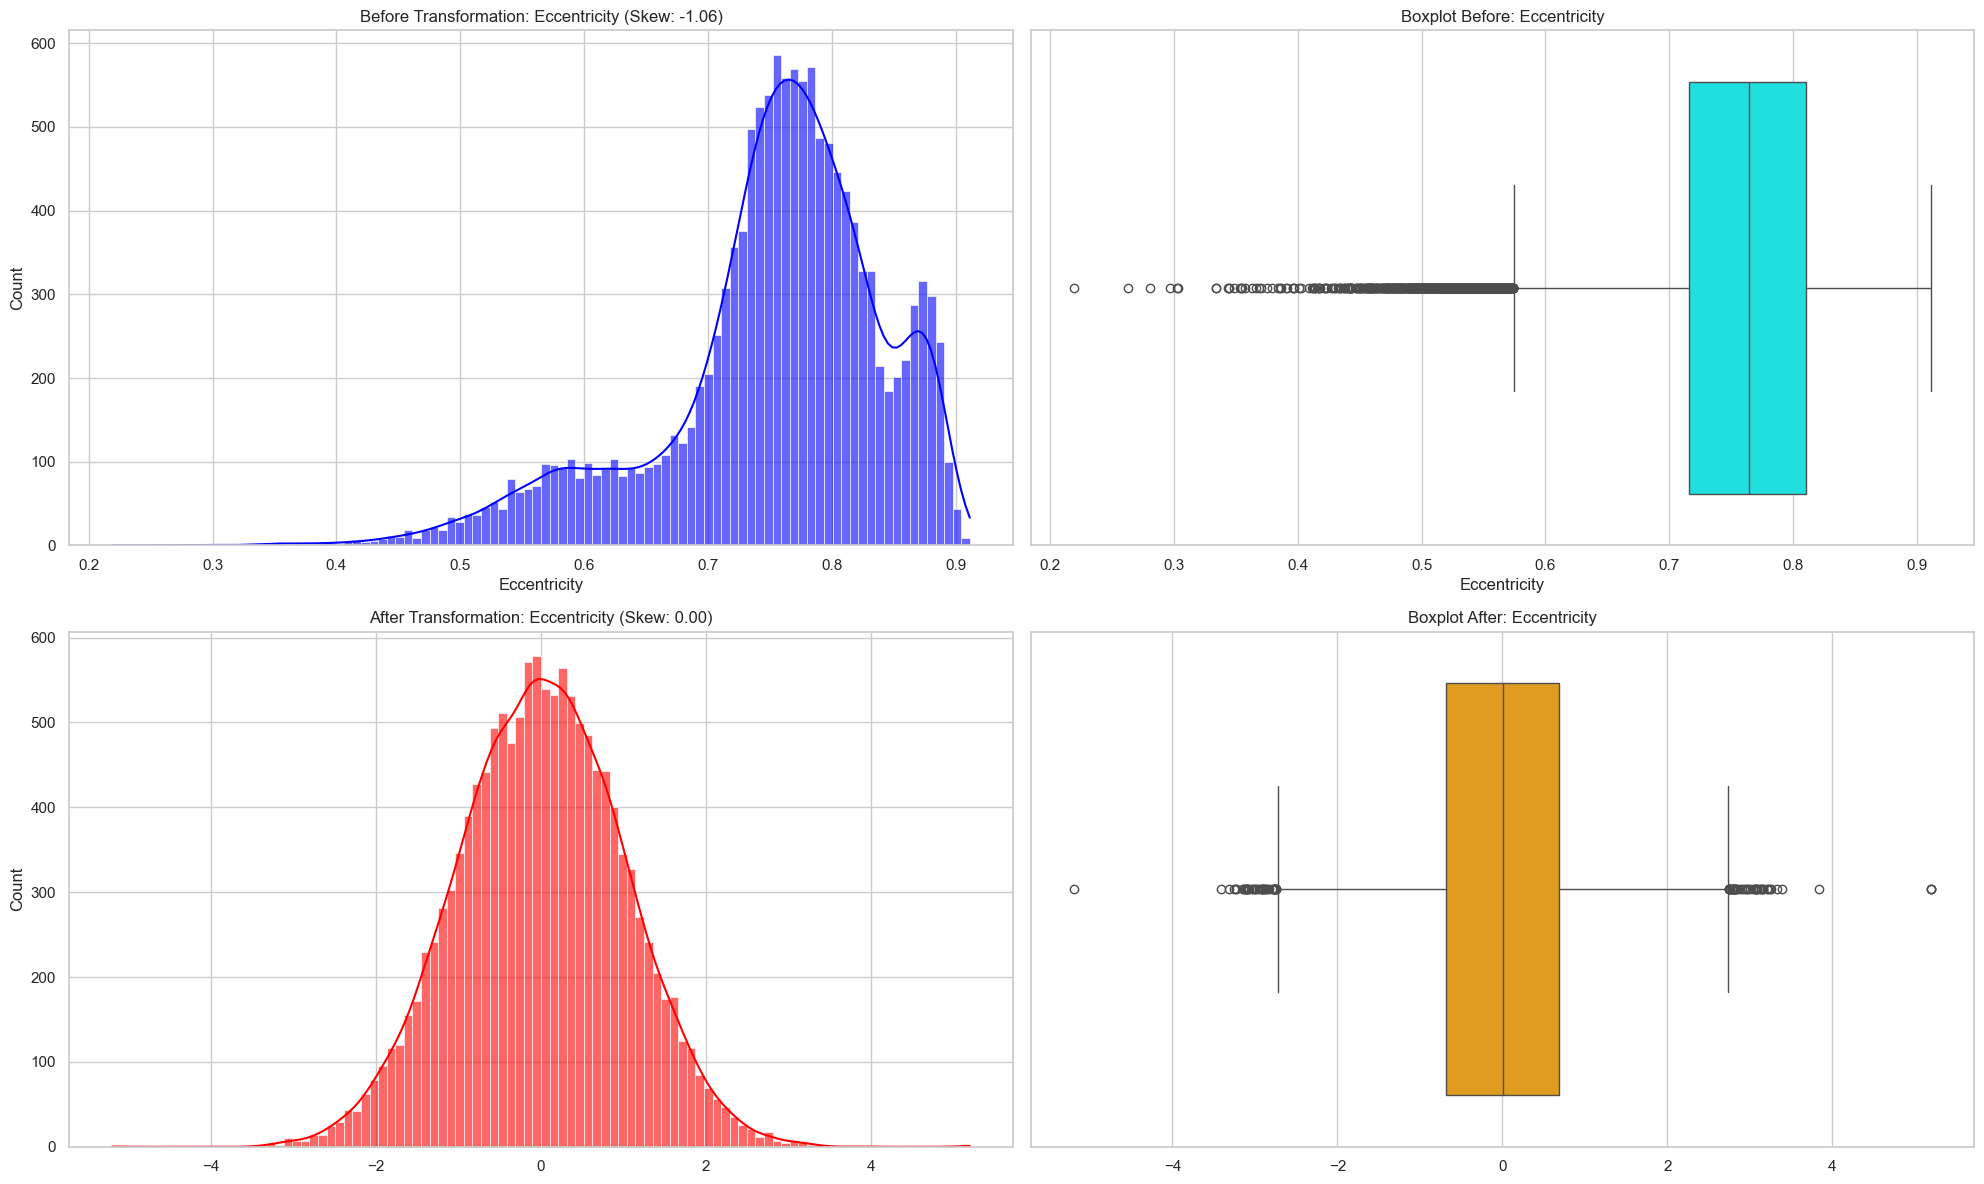

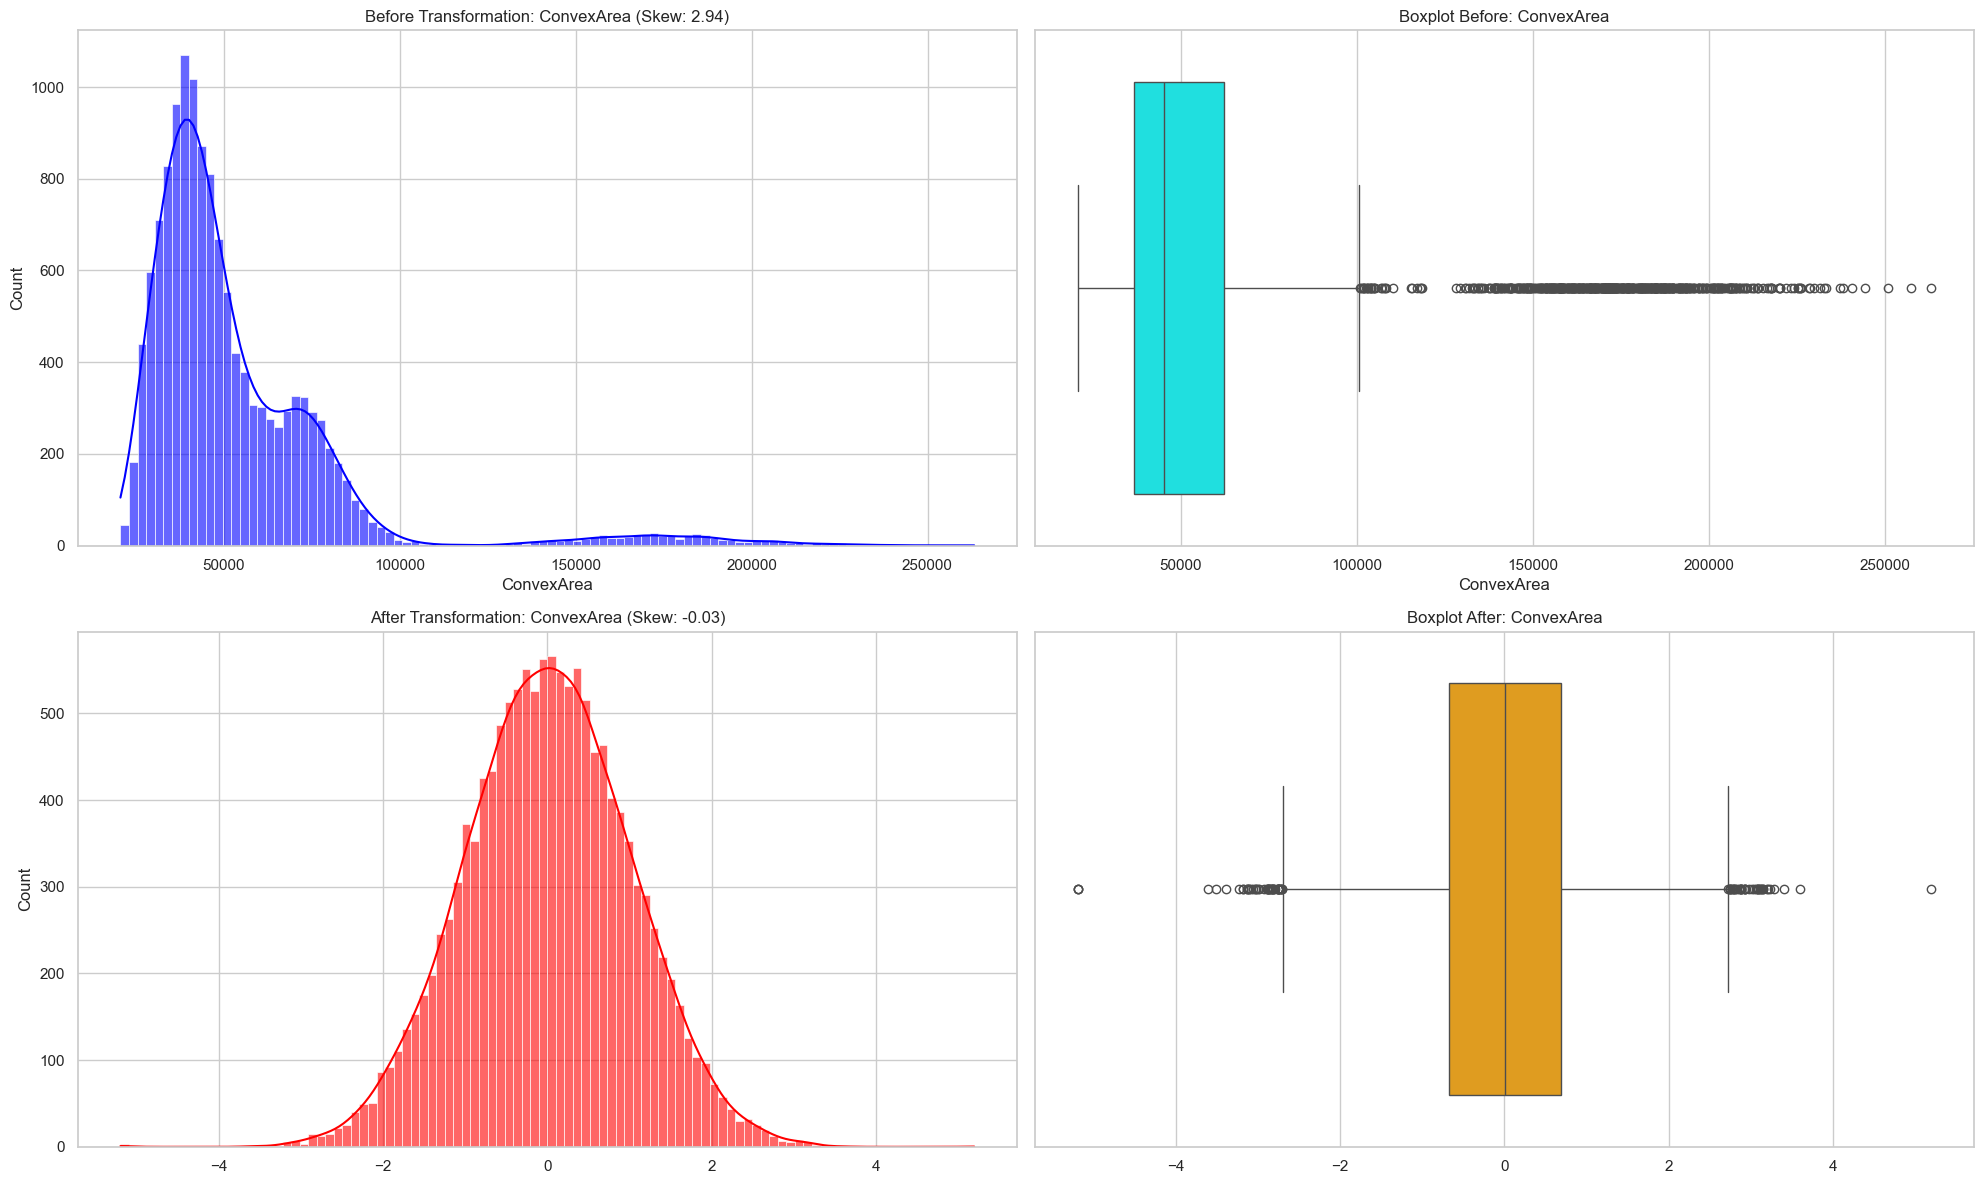

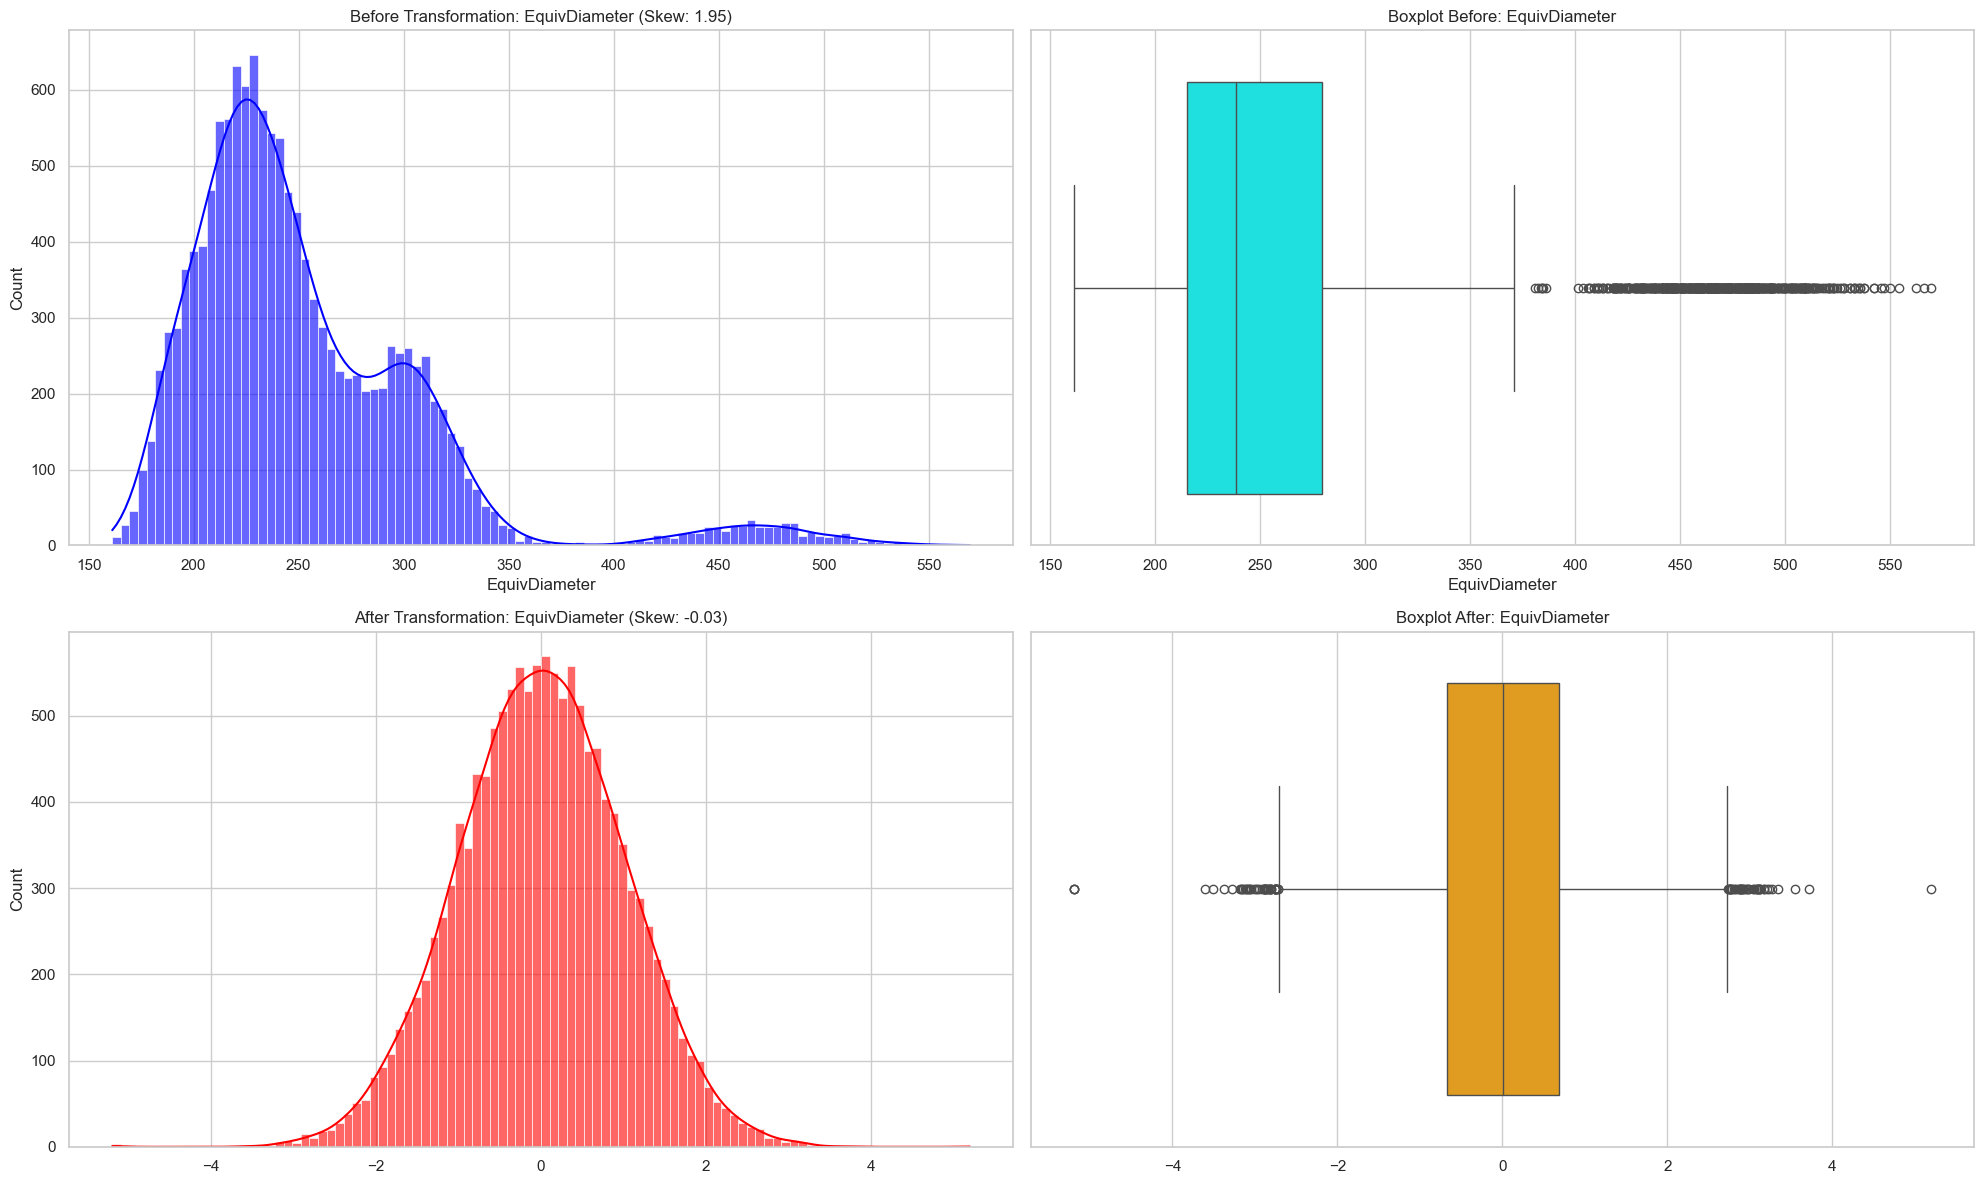

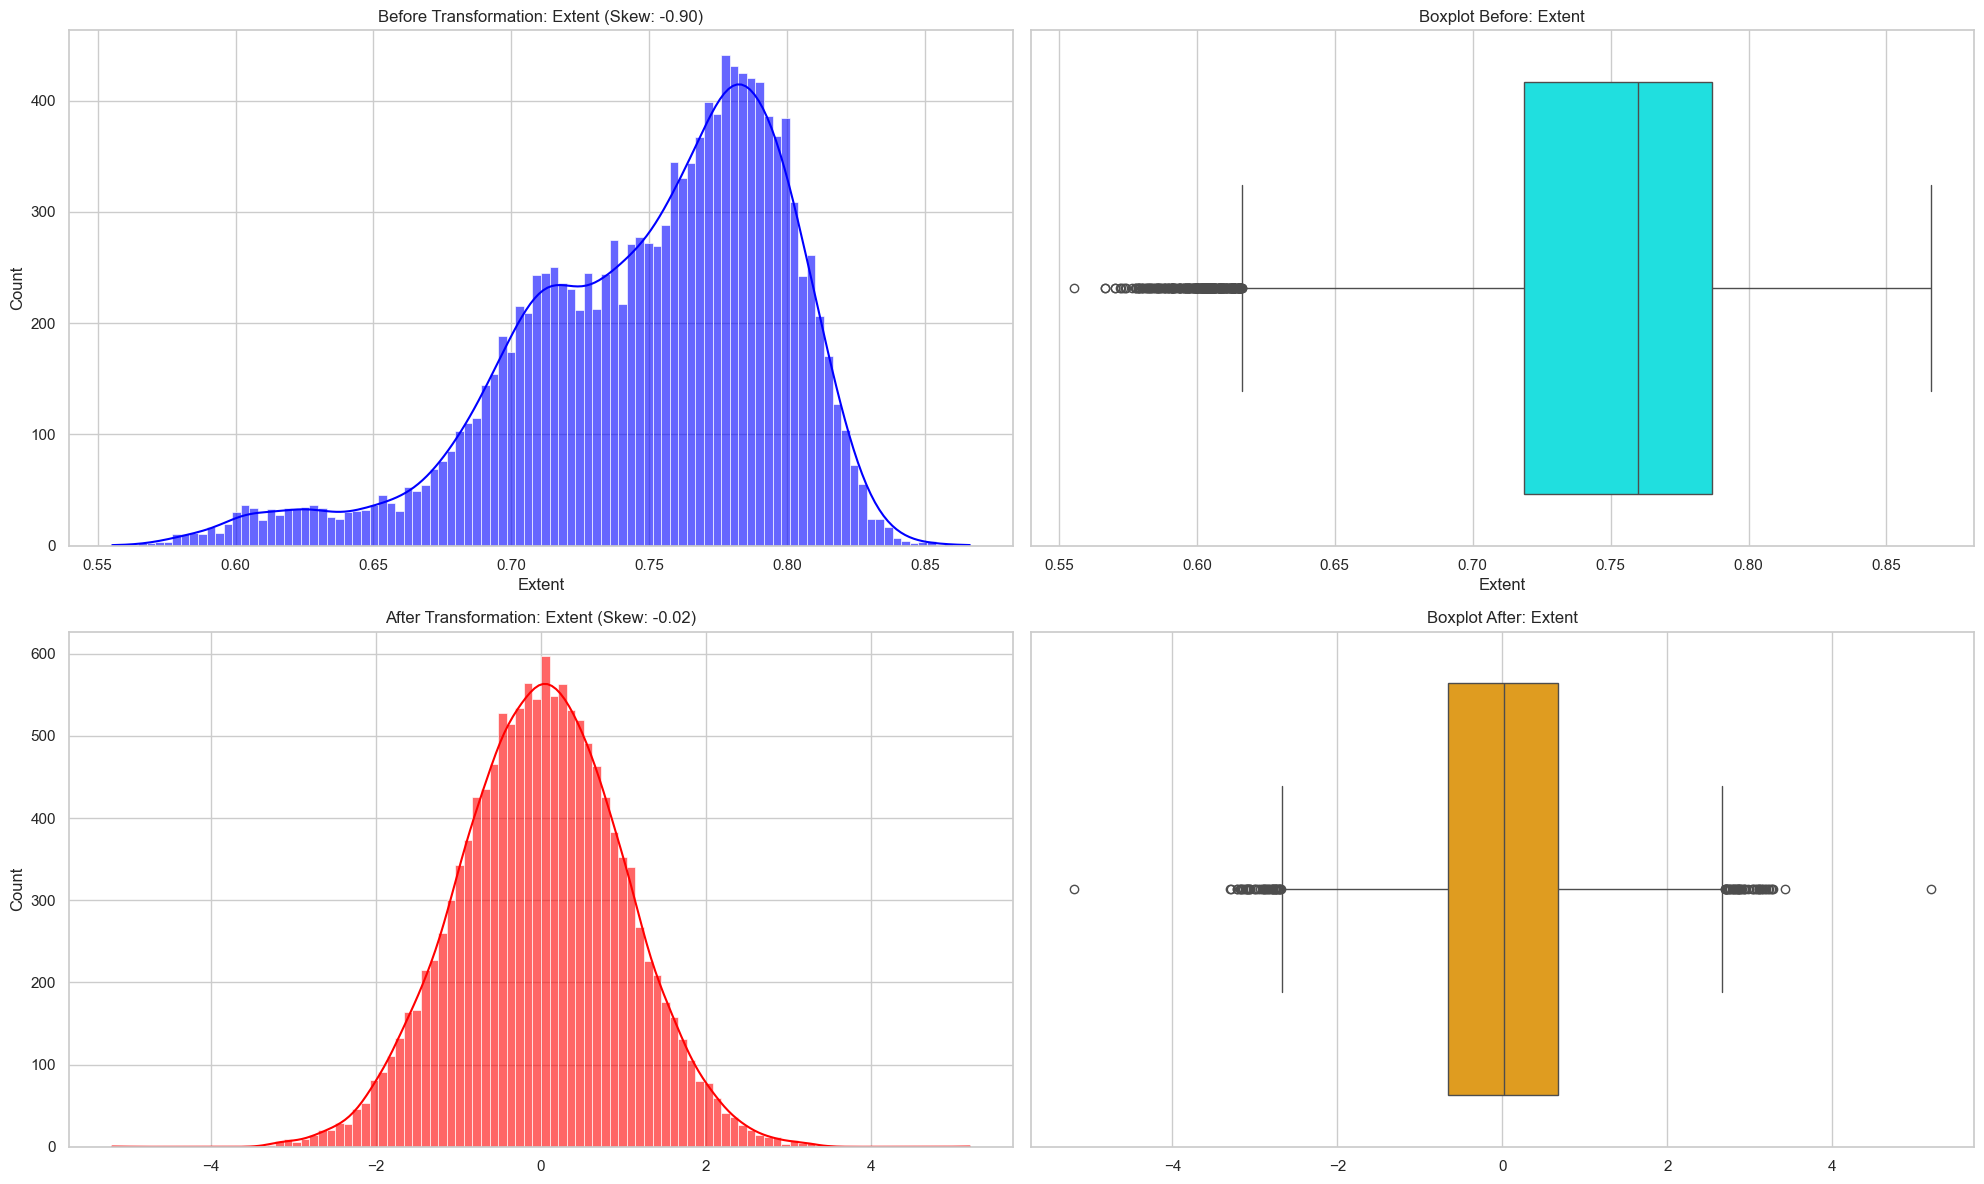

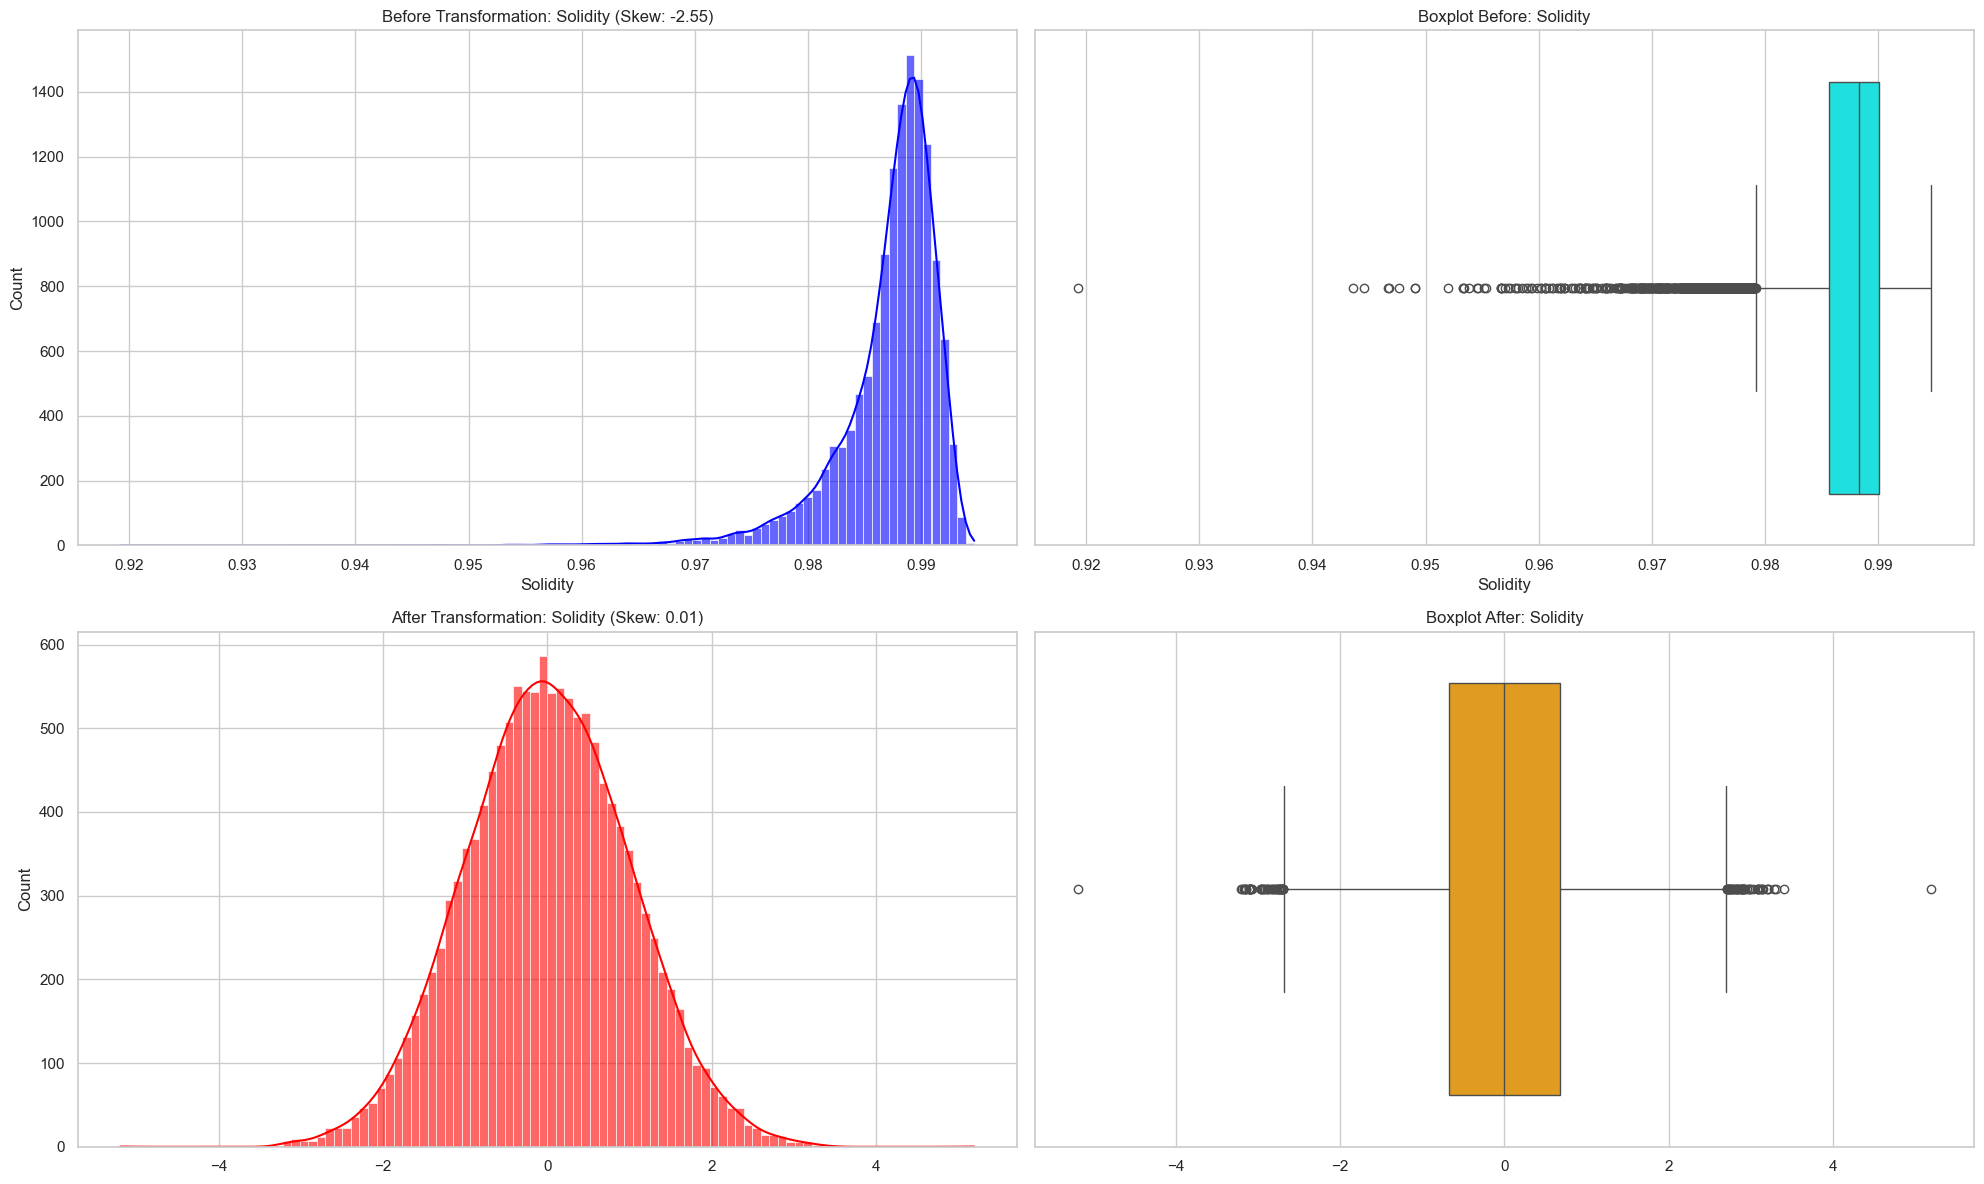

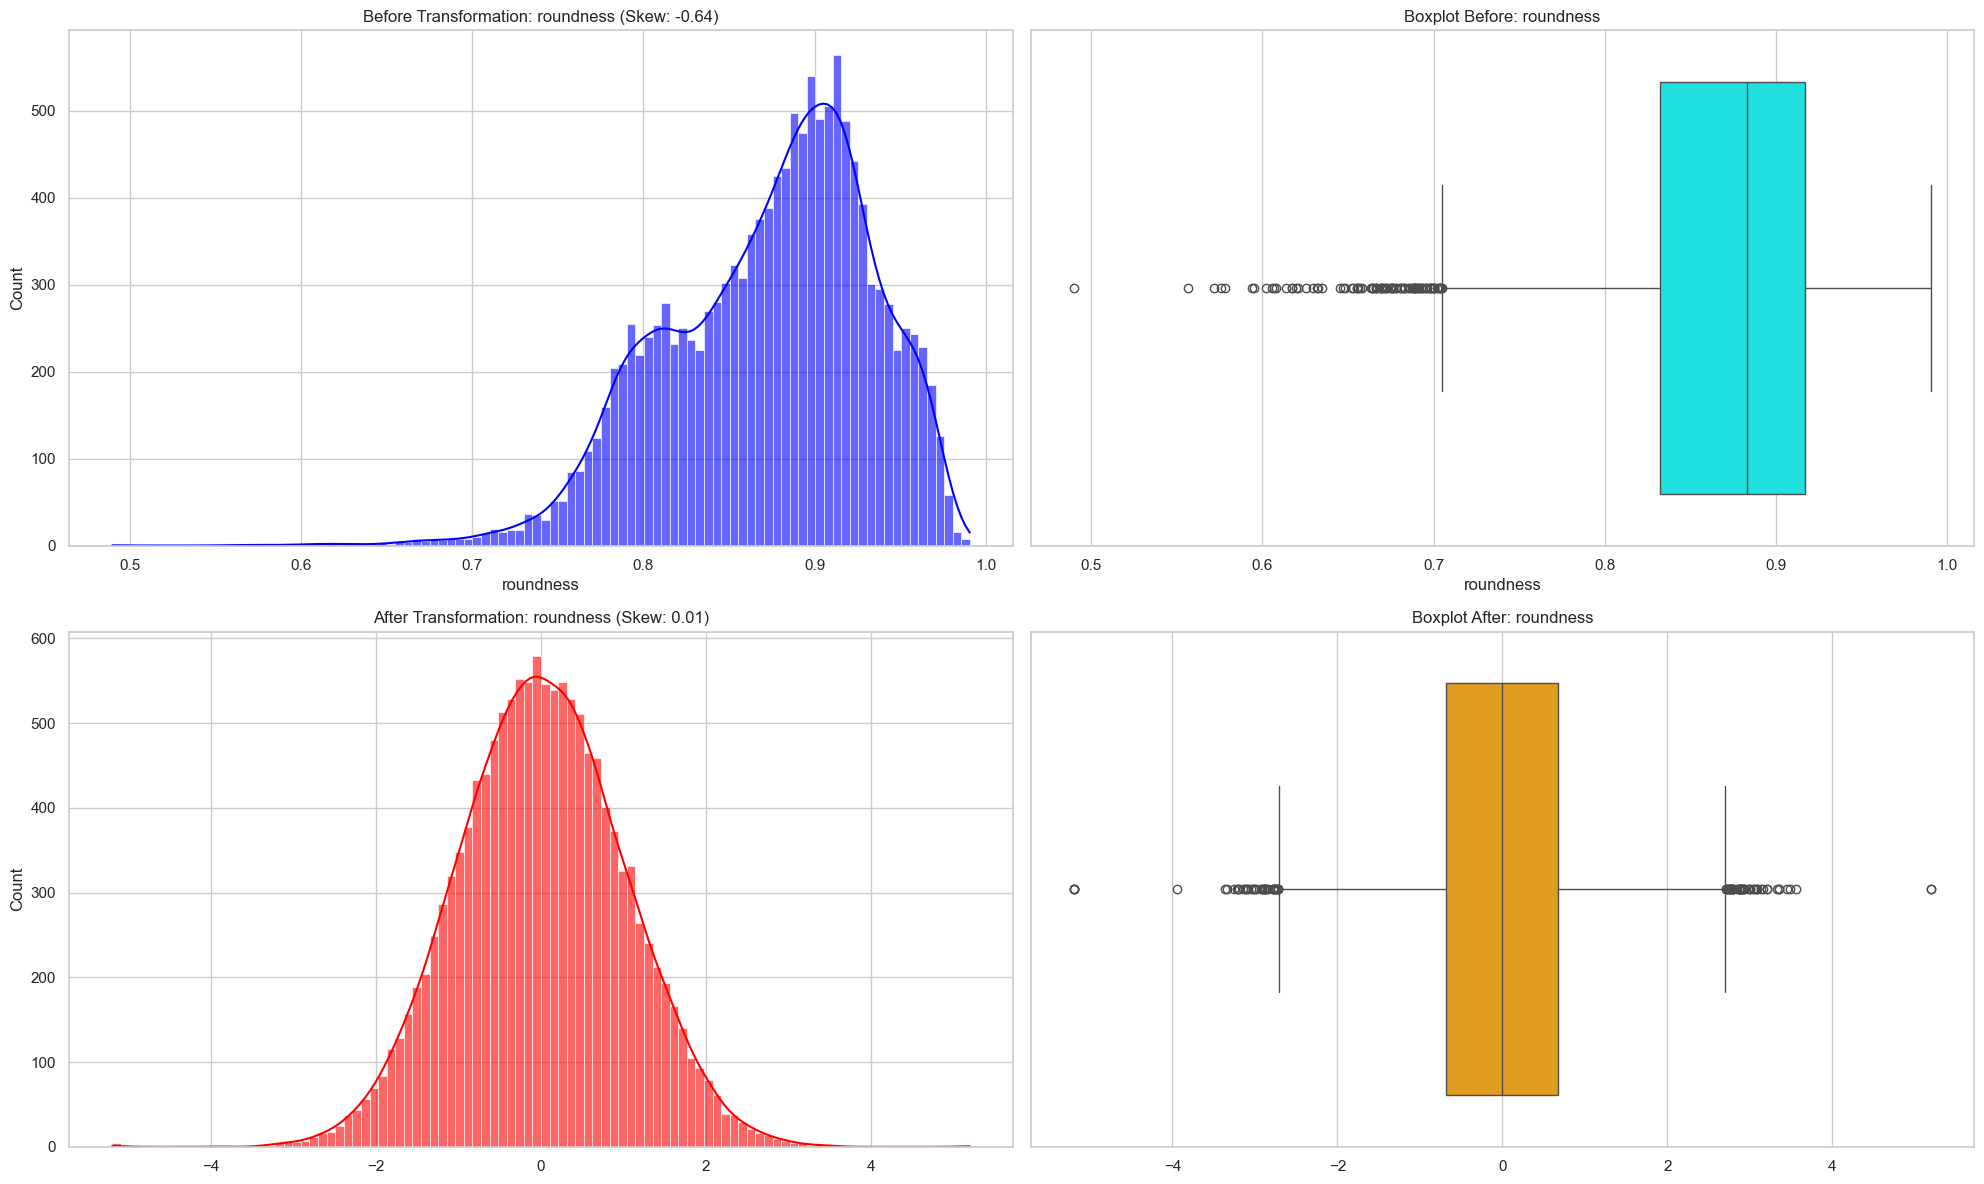

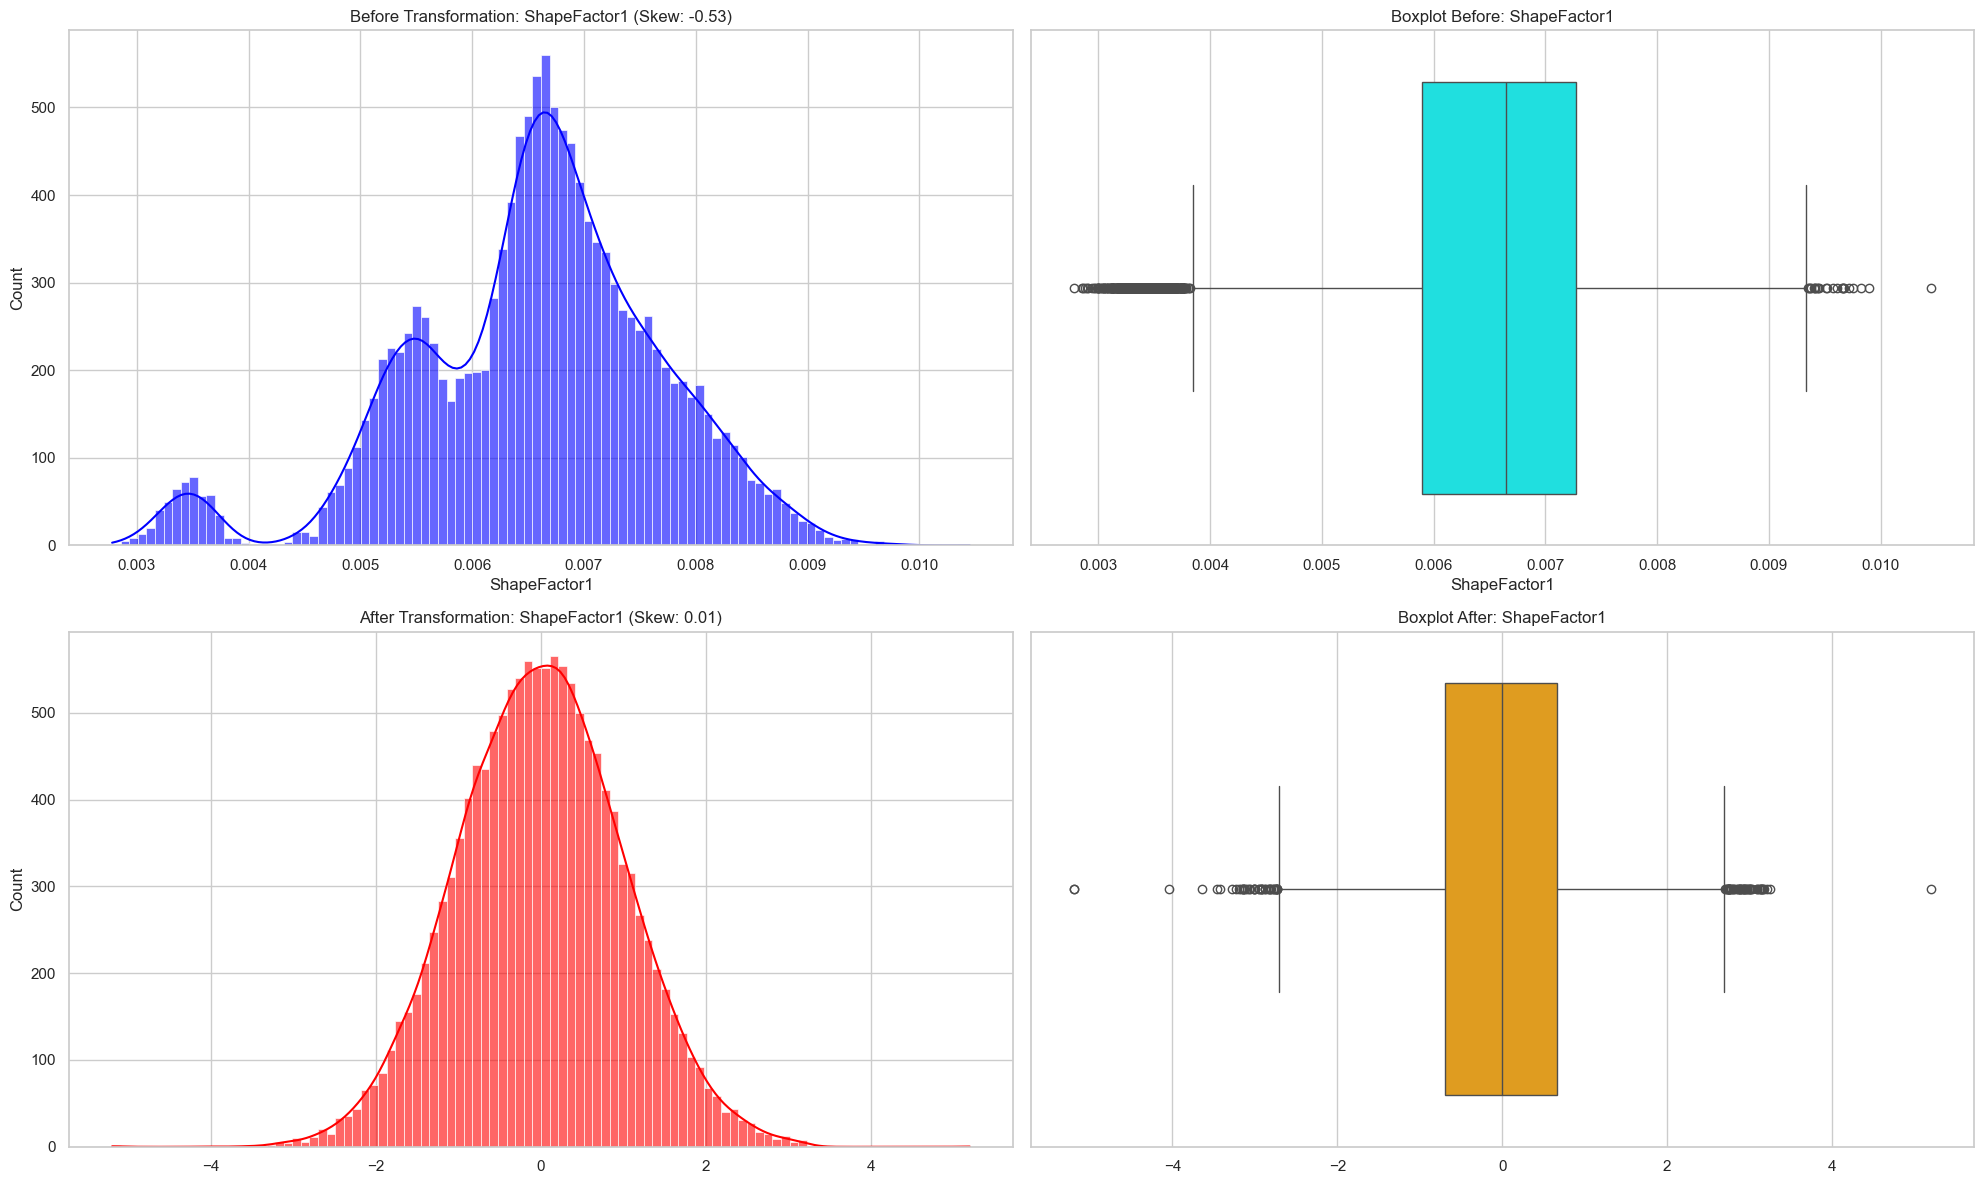

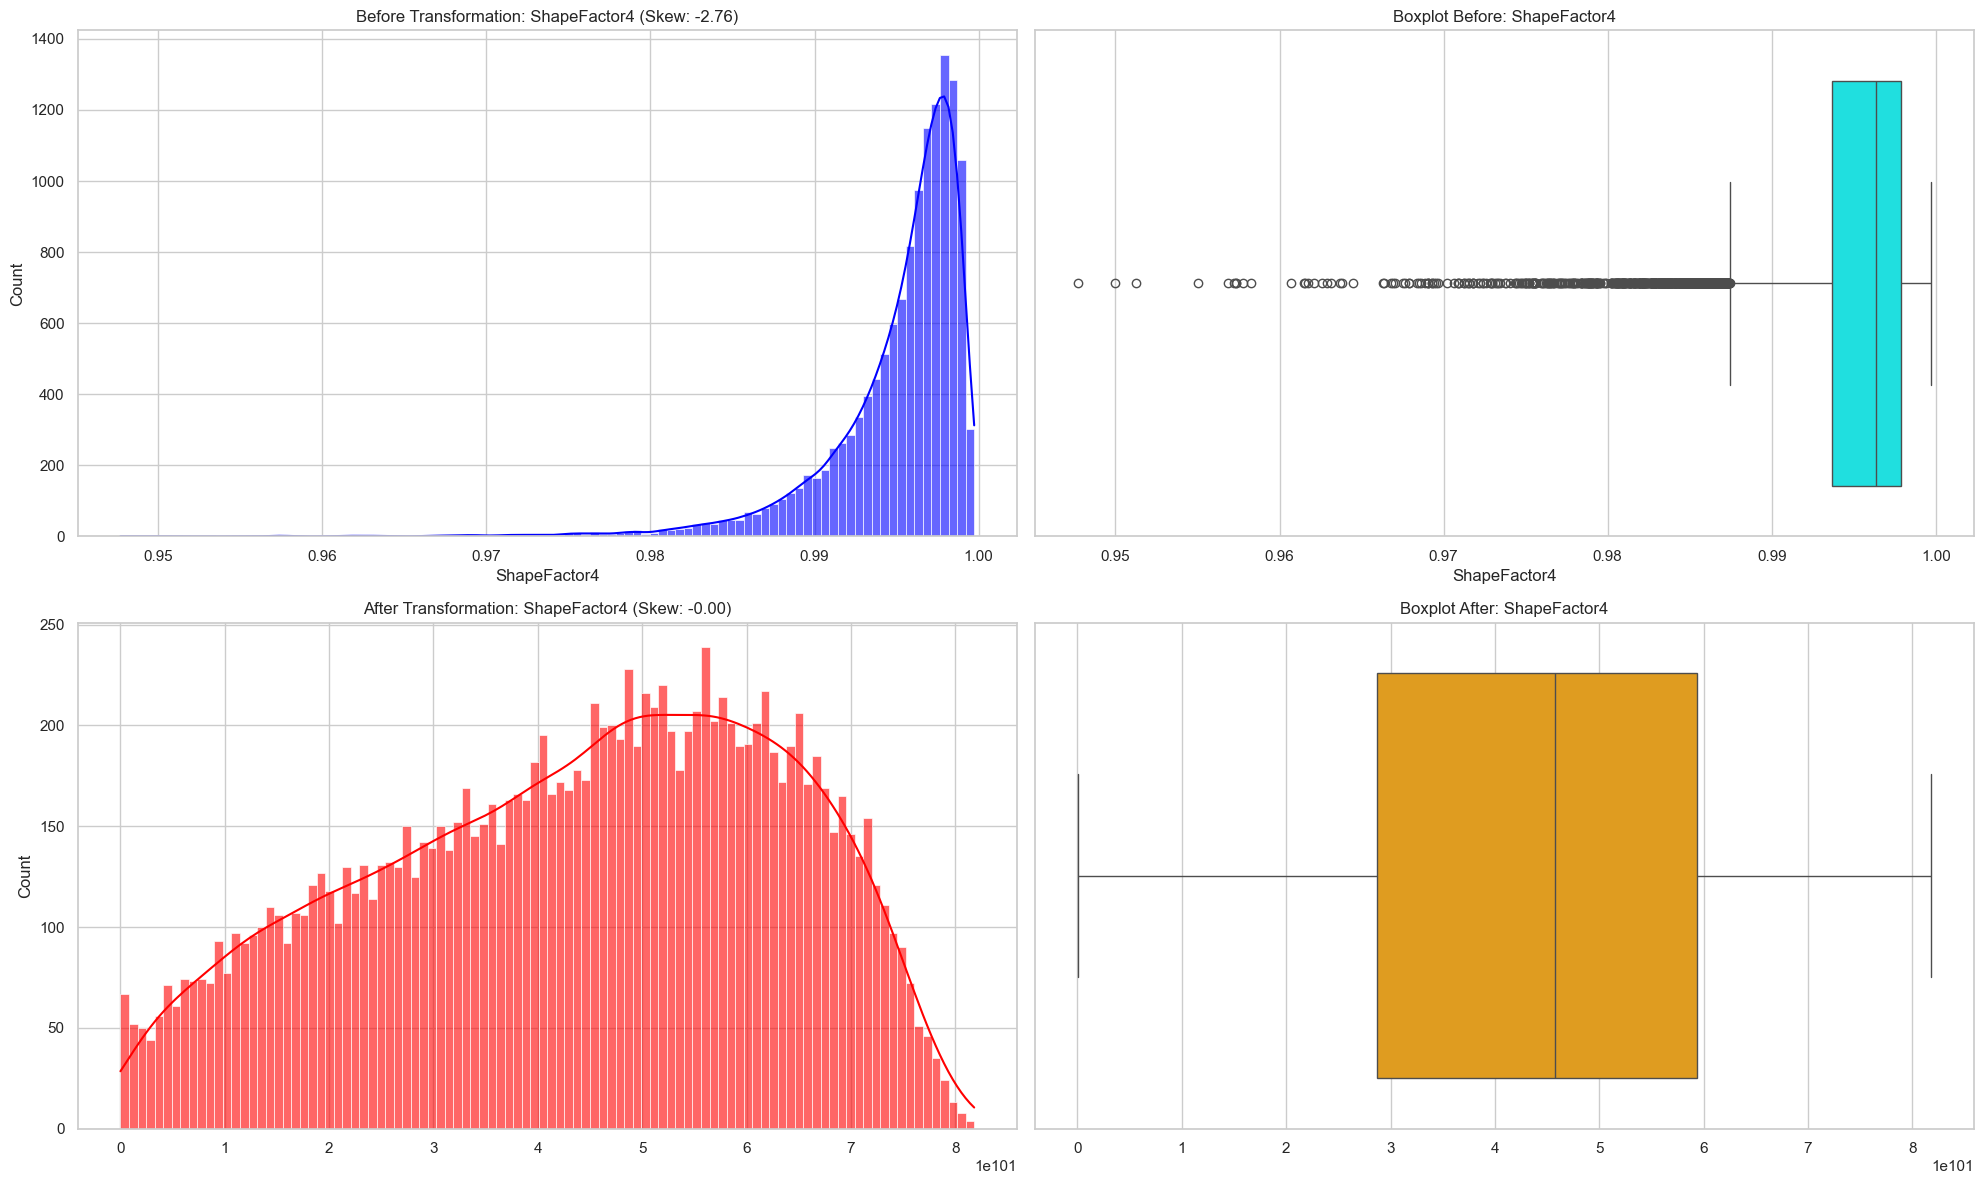

In [159]:
# Plot transformed distributions
for data in transformed_data:
    feature = data["feature"]
    skew_before = data["skew_before"]
    new_skew = data["skew_after"]

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 2 Rows, 2 Columns

    # Histogram Before Transformation
    sns.histplot(data["original"], bins=100, kde=True, ax=axes[0, 0], color='blue', alpha=0.6)
    axes[0, 0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

    # Boxplot Before Transformation
    sns.boxplot(x=data["original"], ax=axes[0, 1], color='cyan')
    axes[0, 1].set_title(f'Boxplot Before: {feature}')

    # Histogram After Transformation
    sns.histplot(data["transformed"], bins=100, kde=True, ax=axes[1, 0], color='red', alpha=0.6)
    axes[1, 0].set_title(f'After Transformation: {feature} (Skew: {new_skew:.2f})')

    # Boxplot After Transformation
    sns.boxplot(x=data["transformed"], ax=axes[1, 1], color='orange')
    axes[1, 1].set_title(f'Boxplot After: {feature}')

    plt.tight_layout()  # Adjust layout
    plt.show()

By applying **quantile or Box-Cox** transformations, we successfully normalize feature distributions, enhancing model performance and stability.


#### Step 6: Apply TF-IDF

We will use now the **TF-IDF transformation** function on categorical text columns to improve feature representation. To ensure this, we first check for textual data in the dataset.

In [160]:
# Detect all text columns dynamically, excluding the target column
text_columns = [col for col in df.select_dtypes(include=['object', 'string']).columns if col != target_column]

if text_columns:
    print(f"\n Detected text columns for TF-IDF transformation: {text_columns}")
else:
    print("\n No text columns detected. Skipping TF-IDF transformation.")

# Convert text columns to string type
for col in text_columns:
    df[col] = df[col].astype(str)

# Apply TF-IDF transformation only on detected text columns
for col in text_columns:
    df = apply_tfidf(df, col)


 No text columns detected. Skipping TF-IDF transformation.


Since no text columns were detected, we skip this step.

#### Step 5: Apply SMOTE and Under-sampling 
To address class imbalance, we apply **SMOTE** to generate synthetic samples for the minority class and **under-sampling** to reduce the majority class size. These techniques help create a more balanced dataset, improving model performance and reducing bias.


In [161]:
# Extract features (X) and target (y)
X = df[numerical_features]
y = df[target_column]

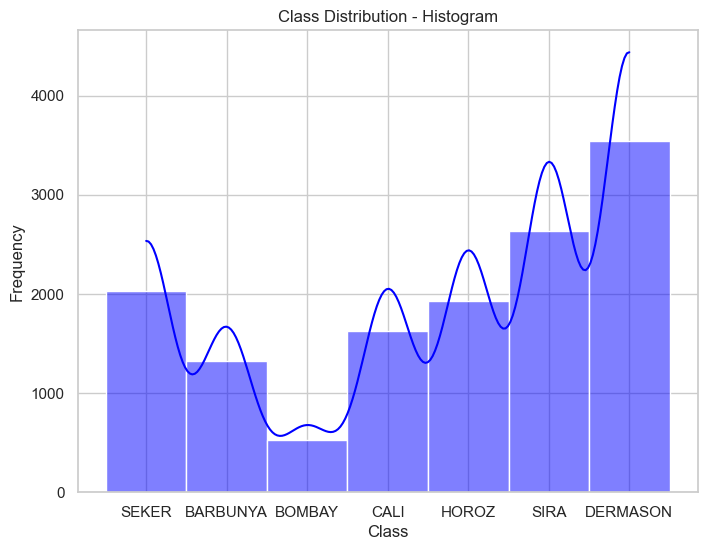

In [162]:
# Set the style
sns.set(style='whitegrid')

# Create the figure
plt.figure(figsize=(8, 6))

# Histogram with KDE
sns.histplot(df[target_column], bins=30, kde=True, color='blue')

# Titles and labels
plt.title('Class Distribution - Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()


The plot illustrate the distribution of price across different bean types:
- The distribution varies significantly across categories, with some bean types (e.g., Dermason) having noticeably higher frequency.
- Certain categories (e.g., Bombay) have fewer occurrences, indicating an uneven distribution.

Understanding price distribution helps in feature selection, model training, and identifying potential biases in the dataset.

In [163]:
# Apply SMOTE to balance classes
X_smote, y_smote = apply_smote(X, df[target_column])


Class Distribution Before SMOTE: Counter({'DERMASON': 3546, 'SIRA': 2636, 'SEKER': 2027, 'HOROZ': 1928, 'CALI': 1630, 'BARBUNYA': 1322, 'BOMBAY': 522})
Imbalance Ratio: 6.79
Moderate imbalance detected. Using Standard SMOTE.
Multi-class detected (7 classes). Adjusting strategy dynamically.
Adjusted Sampling Strategy: {'SEKER': 2482, 'BARBUNYA': 2482, 'BOMBAY': 2482, 'CALI': 2482, 'HOROZ': 2482, 'SIRA': 2636}


In [164]:
# Apply under-sampling if necessary
X_final, y_final = apply_undersampling(X_smote, y_smote)


Class Distribution Before Undersampling: Counter({'DERMASON': 3546, 'SIRA': 2636, 'SEKER': 2482, 'BARBUNYA': 2482, 'BOMBAY': 2482, 'CALI': 2482, 'HOROZ': 2482})
Imbalance Ratio: 1.43
Mild imbalance detected. Applying light undersampling (max_ratio = 2.0)

Class Distribution After Dynamic Undersampling: Counter({'DERMASON': 3546, 'SIRA': 2636, 'BARBUNYA': 2482, 'BOMBAY': 2482, 'CALI': 2482, 'HOROZ': 2482, 'SEKER': 2482})


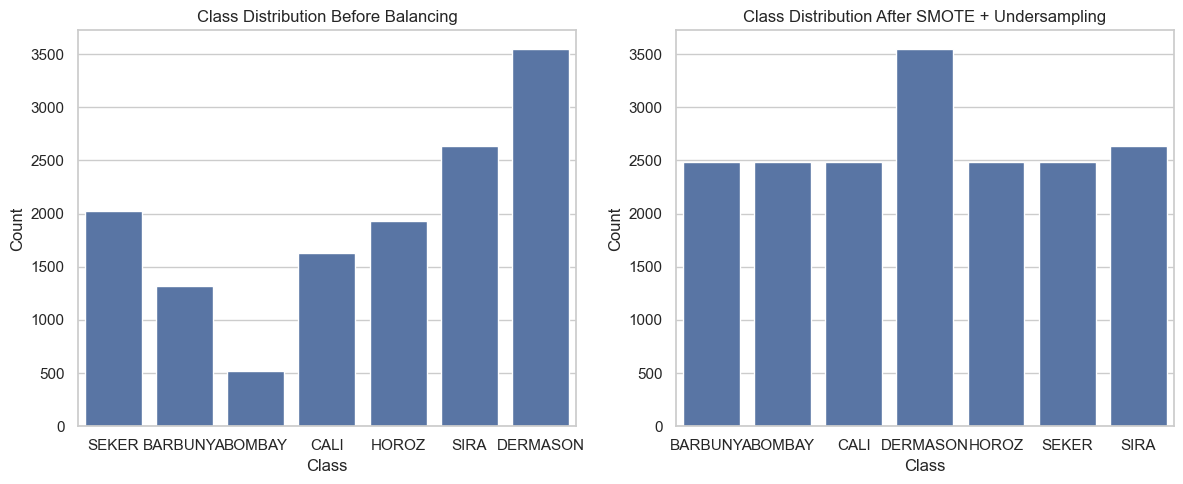

In [165]:
# Plot class distribution before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_final, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE + Undersampling")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

The bar charts illustrate the effect of applying **SMOTE and undersampling** to balance the dataset:

- Left (Before Balancing): The dataset was highly imbalanced, with certain bean types (e.g., Dermason, Sira) having significantly more samples than others (e.g., Bombay). This imbalance could lead to biased model predictions.
- Right (After Balancing): After applying SMOTE (oversampling minority classes) and undersampling majority classes, the dataset is now balanced, ensuring the model can learn from all classes equally.

This final step improves **model performance, fairness, and generalization**, reducing bias toward dominant classes. The pipeline is now ready for **training and evaluation** on a balanced dataset.

### 6.3. Adult Income Dataset
#### Step 1: Load the Dataset
Again, we load the dataset using the load function, ensuring the correct target column is selected and numerical features are properly extracted.
- **The target column is correctly identified** (in this case -`"income"`).
- **All numerical features are extracted properly** for analysis and preprocessing..
- link: https://www.kaggle.com/datasets/wenruliu/adult-income-dataset

In [166]:
# Load the new dataset
target_column = 'income'
df, numerical_features = load_data("adult.csv",target_column)

Dataset Shape: (48842, 15)

Sample Rows:


age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

#### Step 2: Detect Skewed Features
As we can see the dataset contains numerical features. We check for **highly skewed features** using the function we created earlier.

In [167]:
# Detect skewed numerical features
skewed_features, skewness_table = detect_skewed_features(df, numerical_features)

# Display the skewness table
display(skewness_table)

Detecting skewed features...
Skewed Features (>|0.5|): ['age', 'fnlwgt', 'capital-gain', 'capital-loss']


Feature   Skewness
capital-gain        capital-gain  11.894659
capital-loss        capital-loss   4.569809
fnlwgt                    fnlwgt   1.438892
age                          age   0.557580
hours-per-week    hours-per-week   0.238750
educational-num  educational-num  -0.316525

#### Step 3: Transform Skewed Features
To **normalize** the dataset and reduce skewness, we will apply the `best_transform()` function.

In [168]:
# Transform and store skewed features
transformed_data, results_df = transform_and_store_skewed_features(df, skewed_features)

In [169]:
# Display transformation results
display(results_df)

Feature  Skewness Before  Skewness After       Method
0           age         0.557580       -0.014032       boxcox
1        fnlwgt         1.438892        0.015921  yeo-johnson
2  capital-gain        11.894659        3.032359  yeo-johnson
3  capital-loss         4.569809        4.295731  yeo-johnson

#### Step 4: Visualize the Before & After Skewness
We will use the same approach as we have done on the first dataset to visualize the before and after skewness.

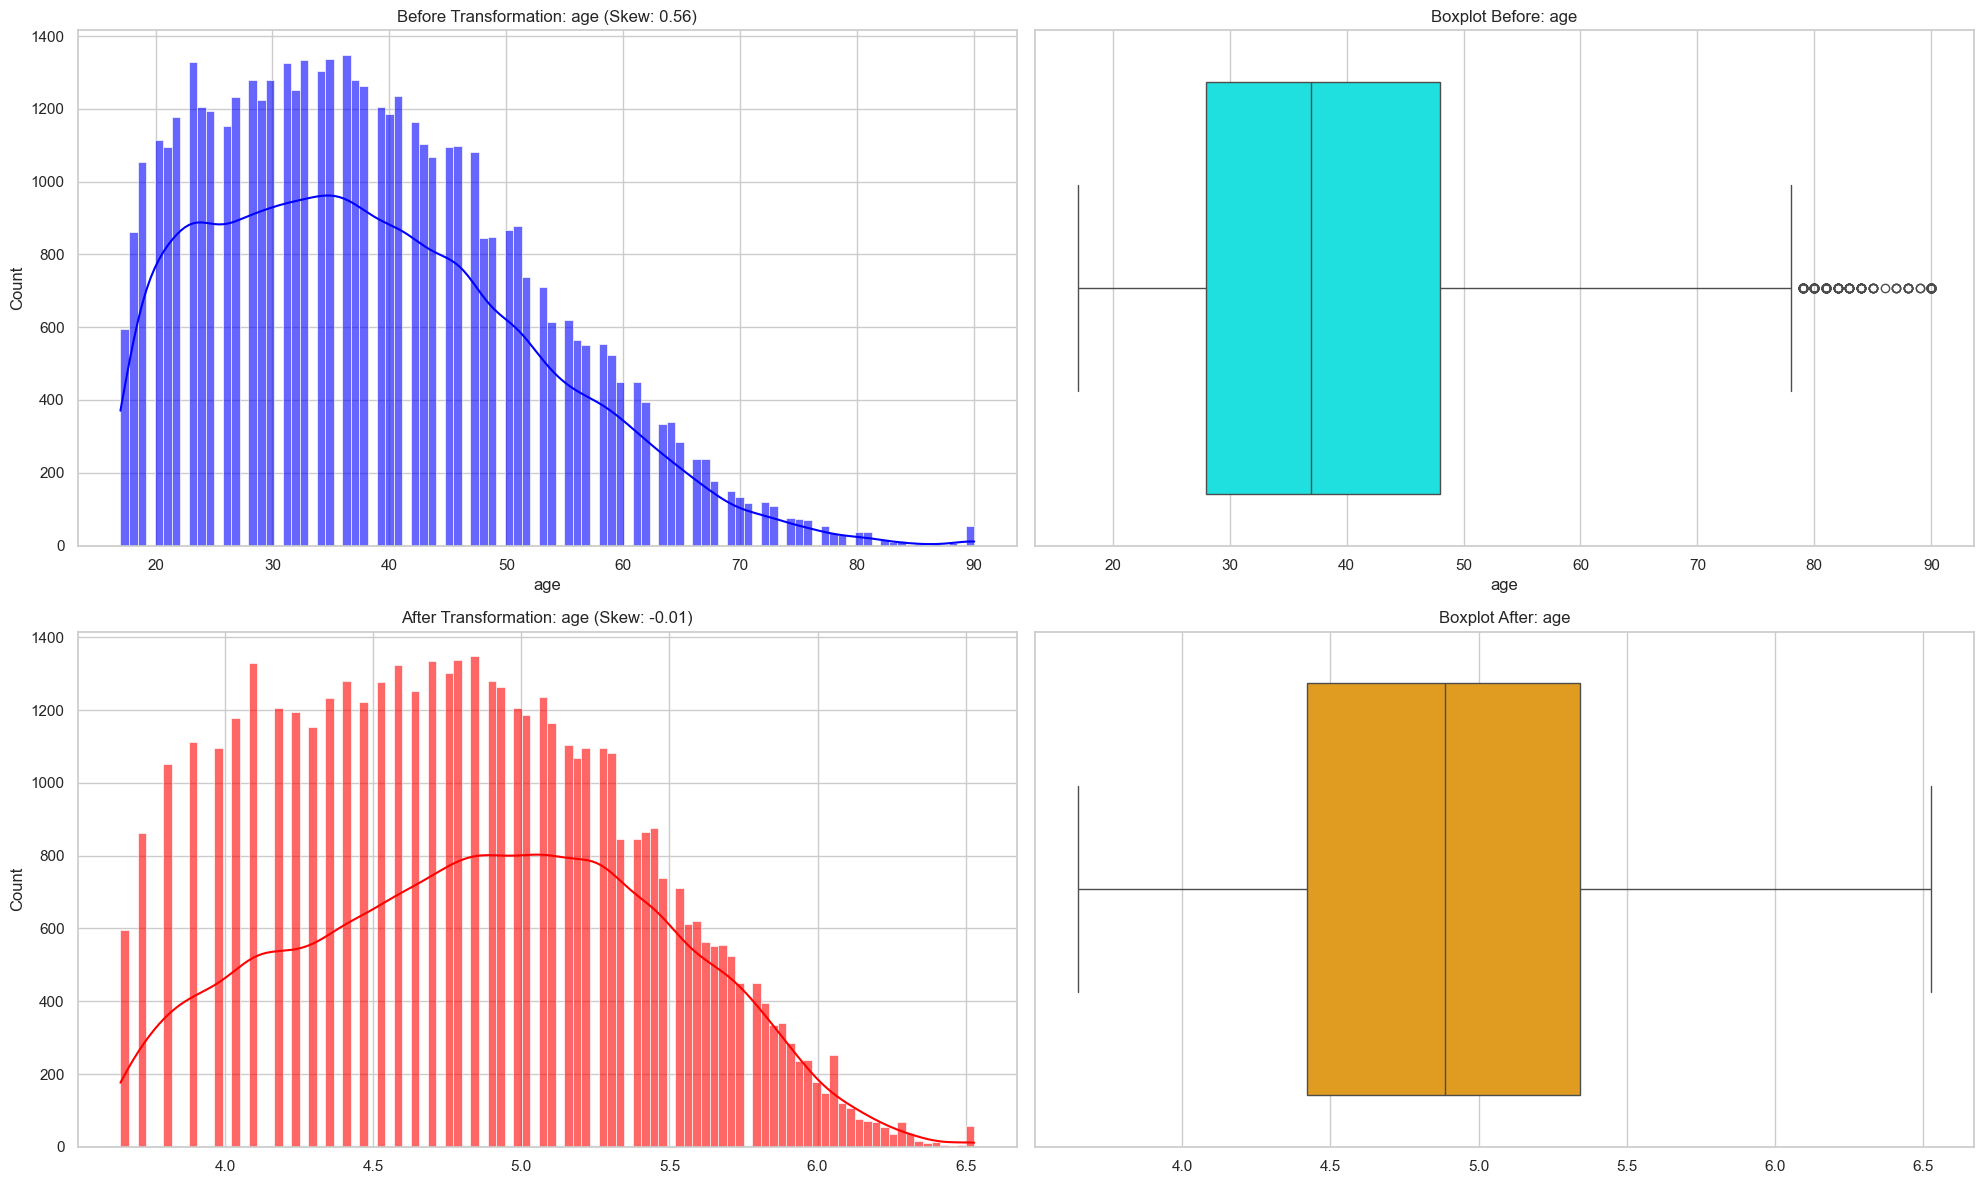

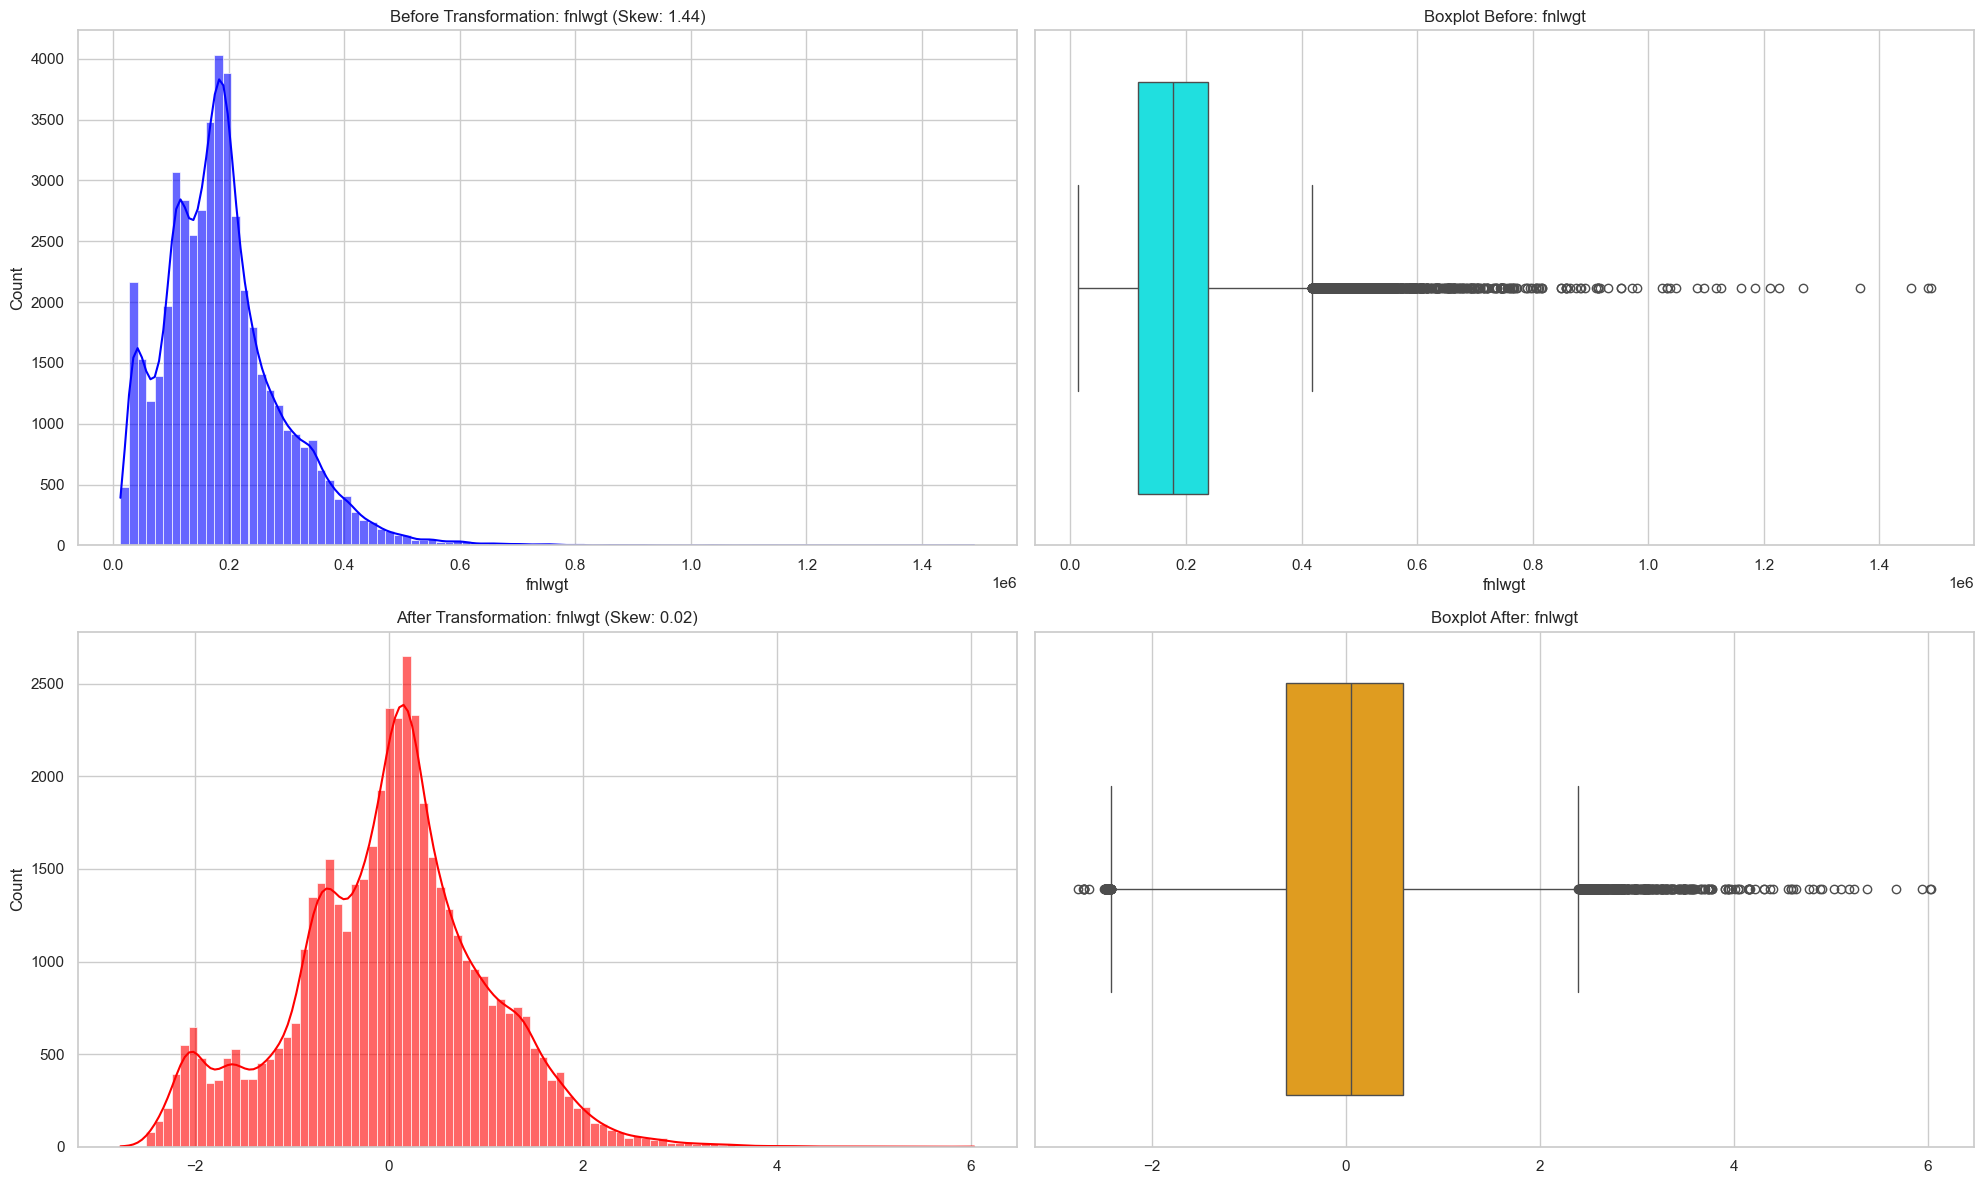

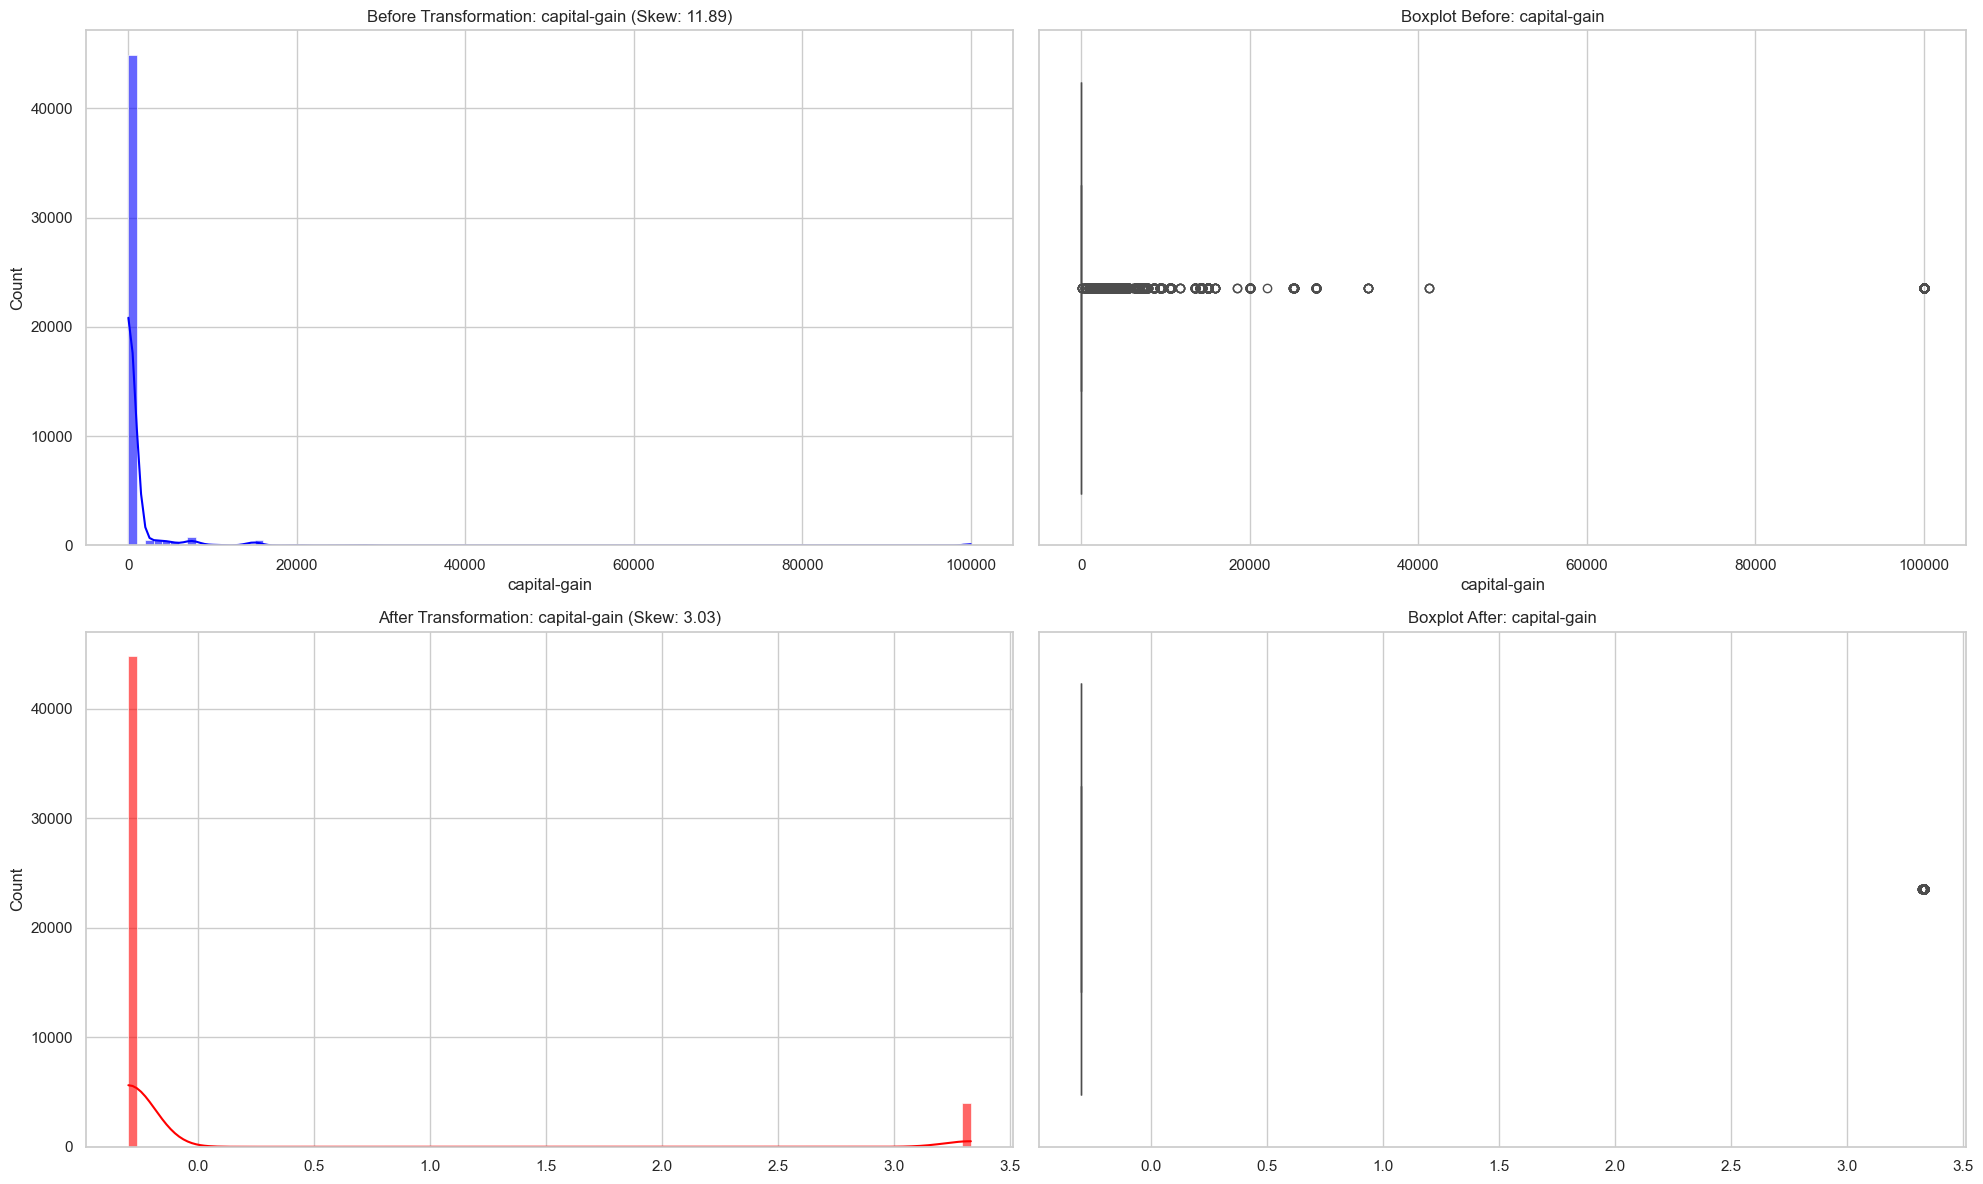

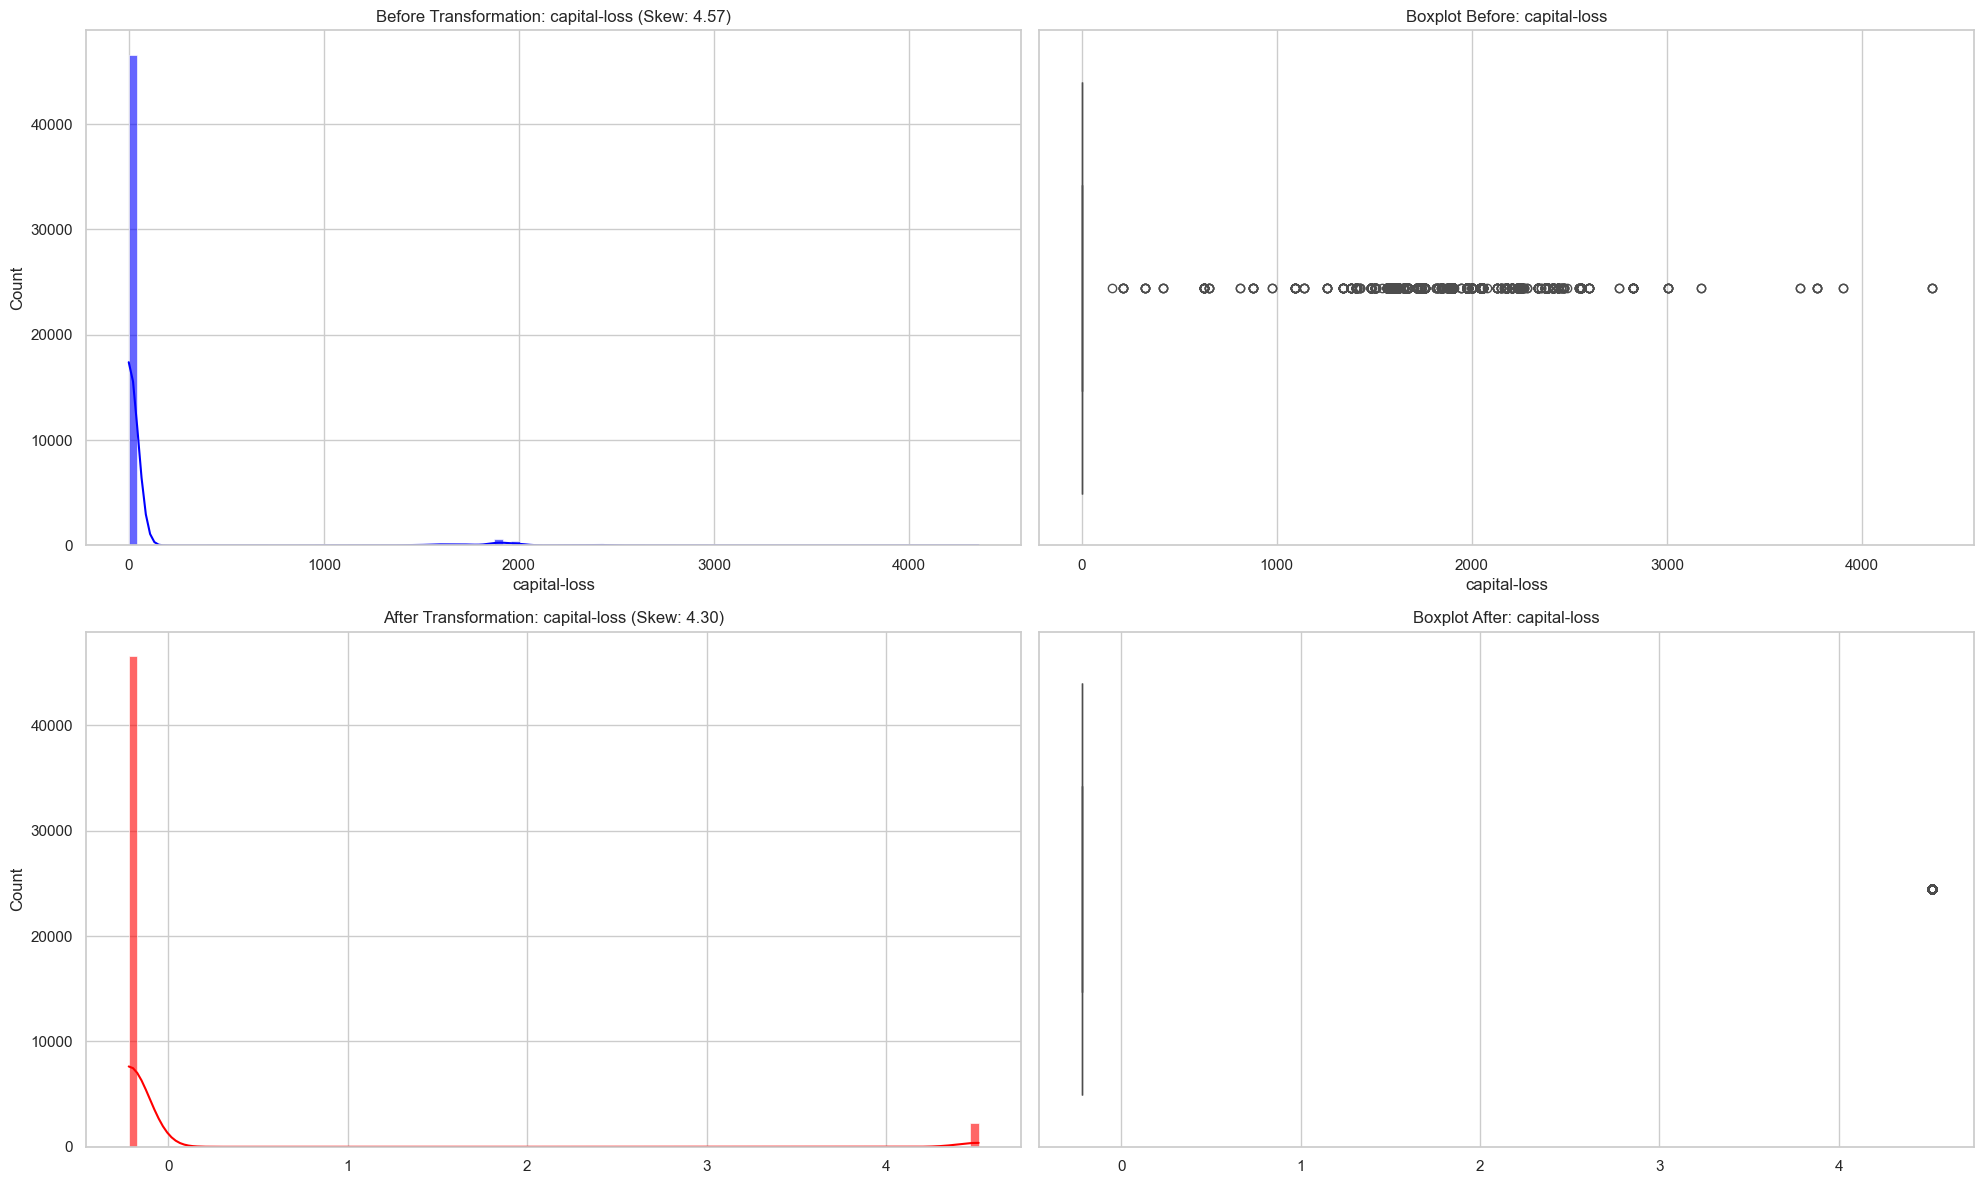

In [170]:
# Plot transformed distributions
for data in transformed_data:
    feature = data["feature"]
    skew_before = data["skew_before"]
    new_skew = data["skew_after"]

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 2 Rows, 2 Columns

    # Histogram Before Transformation
    sns.histplot(data["original"], bins=100, kde=True, ax=axes[0, 0], color='blue', alpha=0.6)
    axes[0, 0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

    # Boxplot Before Transformation
    sns.boxplot(x=data["original"], ax=axes[0, 1], color='cyan')
    axes[0, 1].set_title(f'Boxplot Before: {feature}')

    # Histogram After Transformation
    sns.histplot(data["transformed"], bins=100, kde=True, ax=axes[1, 0], color='red', alpha=0.6)
    axes[1, 0].set_title(f'After Transformation: {feature} (Skew: {new_skew:.2f})')

    # Boxplot After Transformation
    sns.boxplot(x=data["transformed"], ax=axes[1, 1], color='orange')
    axes[1, 1].set_title(f'Boxplot After: {feature}')

    plt.tight_layout()  # Adjust layout
    plt.show()


#### Step 6: Apply TF-IDF

We will use now the **TF-IDF transformation** function on categorical text columns to improve feature representation. This approach helps handle **high-cardinality features** like `occupation` and `native-country`, reducing sparsity while retaining meaningful distinctions between categories.

In [171]:
# Detect all text columns dynamically, excluding the target column
text_columns = [col for col in df.select_dtypes(include=['object', 'string']).columns if col != target_column]

if text_columns:
    print(f"\nDetected text columns for TF-IDF transformation: {text_columns}")
else:
    print("\nNo text columns detected. Skipping TF-IDF transformation.")

# Convert text columns to string type
for col in text_columns:
    df[col] = df[col].astype(str)

# Apply TF-IDF transformation only on detected text columns
for col in text_columns:
    df = apply_tfidf(df, col)


Detected text columns for TF-IDF transformation: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

 Applying TF-IDF on column: workclass
Extracted 13 TF-IDF features for column: workclass
New dataset shape after TF-IDF transformation: (48842, 27)

 Applying TF-IDF on column: education
Extracted 29 TF-IDF features for column: education
New dataset shape after TF-IDF transformation: (48842, 55)

 Applying TF-IDF on column: marital-status
Extracted 14 TF-IDF features for column: marital-status
New dataset shape after TF-IDF transformation: (48842, 68)

 Applying TF-IDF on column: occupation
Extracted 41 TF-IDF features for column: occupation
New dataset shape after TF-IDF transformation: (48842, 108)

 Applying TF-IDF on column: relationship
Extracted 6 TF-IDF features for column: relationship
New dataset shape after TF-IDF transformation: (48842, 113)

 Applying TF-IDF on column: race
Extracted 12 TF-IDF features for column: 

**The TF-IDF (Term Frequency-Inverse Document Frequency)** transformation was applied to categorical text columns to convert them into **numerical features** for machine learning models. The transformation helps represent text data in a meaningful way while reducing the impact of frequently occurring words.

    - Total transformed columns: 8
    - Number of new features added per column:
    - workclass: 13
    - education: 29
    - marital-status: 14
    - occupation: 41
    - relationship: 6
    - race: 12
    - gender: 2
    - native-country: 57
    
**Final dataset shape**: (48842, 181) → The dataset has expanded as new features were generated.


**Visualization: Bar Chart of Feature Expansion**

Show the **number of TF-IDF features extracted per column**, illustrating which categorical variables contributed the most new features.

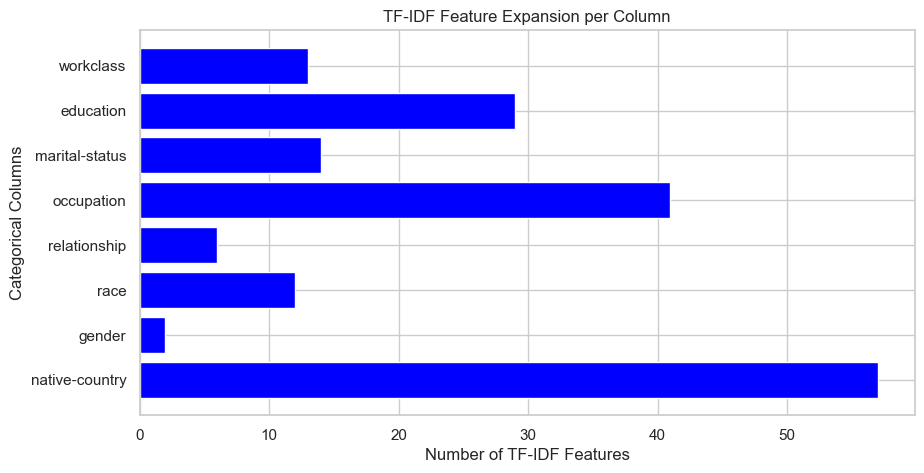

In [172]:
columns = ['workclass', 'education', 'marital-status', 'occupation', 
           'relationship', 'race', 'gender', 'native-country']
tfidf_features = [13, 29, 14, 41, 6, 12, 2, 57]

plt.figure(figsize=(10, 5))
plt.barh(columns, tfidf_features, color='blue')
plt.xlabel("Number of TF-IDF Features")
plt.ylabel("Categorical Columns")
plt.title("TF-IDF Feature Expansion per Column")
plt.gca().invert_yaxis()
plt.show()


The bar chart illustrates the **number of new features** generated for each categorical column using TF-IDF transformation.

Columns with the most TF-IDF features:
- **Native-country (57 features)** and **occupation (41 features)** have the highest expansion, indicating a large variety of unique values in these categories.

Columns with the least TF-IDF features:
- **Gender (2 features)** and **relationship (6 features)** contributed the fewest new features, suggesting a low diversity of unique values.

This transformation converts categorical text data into **numerical representations**, allowing models to leverage textual information effectively. The number of features per column reflects the complexity and diversity of categorical values in the dataset. 

#### Step 5: Apply SMOTE and Under-sampling
To address class imbalance, we apply our **SMOTE** function to generate synthetic samples for the minority class and **undersampling** to reduce the majority class. This balanced approach enhances model performance by preventing bias toward the dominant class while preserving meaningful patterns in the data.


In [173]:
# Extract features (X) and target (y)
X = df[numerical_features]
y = df[target_column]

In [174]:
# Apply SMOTE to balance classes
X_smote, y_smote = apply_smote(X, df[target_column])


Class Distribution Before SMOTE: Counter({'<=50K': 37155, '>50K': 11687})
Imbalance Ratio: 3.18
Moderate imbalance detected. Using Standard SMOTE.


We can see that the class distribution was **imbalanced before SMOTE** (`<=50K`: 37,155, `>50K`: 11,687). After applying **SMOTE**, the distribution is now more balanced (`<=50K`: 37,155, `>50K`: 26,008). This helps our model **learn better from both classes** and reduces bias toward the majority class.

In [175]:
# Apply under-sampling
X_balanced, y_balanced = apply_undersampling(X_smote, y_smote)


Class Distribution Before Undersampling: Counter({'<=50K': 37155, '>50K': 26008})
Imbalance Ratio: 1.43
Mild imbalance detected. Applying light undersampling (max_ratio = 2.0)

Class Distribution After Dynamic Undersampling: Counter({'<=50K': 37155, '>50K': 26008})


Here we can see that before undersampling, the class distribution was **slightly imbalanced** (`<=50K`: 37,155, `>50K`: 26,008) with a **1.43:1 ratio**. After applying **light undersampling**, the distribution remains unchanged as the imbalance was within an acceptable range. This ensures we retain sufficient data while preventing unnecessary loss of valuable information.

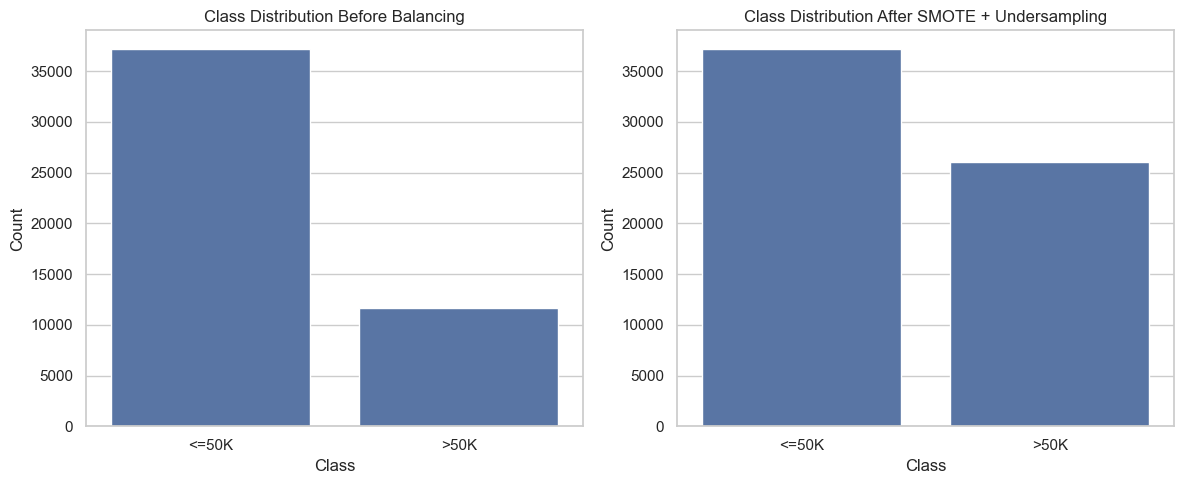

In [176]:
# Plot class distribution before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_balanced, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE + Undersampling")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

The plot illustrates the **class distribution before and after balancing**. Initially, the dataset was highly imbalanced, with significantly fewer instances of the `>50K` class. After applying **SMOTE and undersampling**, the distribution is more balanced, ensuring the model learns effectively from both classes and reducing bias toward the majority class.

## 7. Conclusion
This project addressed the challenges of handling skewed and imbalanced datasets in machine learning. Imbalanced data often leads to biased models that favor the majority class, resulting in suboptimal performance for minority class predictions.

To overcome these issues, we developed a **flexible pipeline** that integrates **data preprocessing, model optimization, and performance evaluation**. The pipeline incorporates various **data balancing techniques** such as **SMOTE, ADASYN, and under-sampling**, along with **data transformation methods like Quantile Transformation and Power Transformation** to enhance feature distributions. Additionally, we leveraged **advanced machine learning models, including LightGBM**, to optimize predictive performance.

The results demonstrate that a well-structured approach combining data transformation and balancing techniques can significantly improve model performance on imbalanced datasets. This work provides a solid foundation for future research and practical applications in domains where data imbalance is a prevalent challenge.

